In [32]:
import pandas as pd
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgbm
import optuna
from sklearn.metrics import log_loss,f1_score

In [3]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt,target
0,0,True,True,True,False,False,False,1,4,3,...,2,1608,275,1,4,139,618822,354805,2020-01-17 12:09:36,1
1,1,False,False,False,True,True,False,1,3,4,...,2,1608,275,1,4,133,571659,346213,2020-06-18 17:48:52,0
2,2,False,False,False,True,False,False,2,0,3,...,1,1600,94,1,4,53,399816,206408,2020-07-08 20:00:10,0
3,3,False,False,False,True,False,False,2,0,2,...,2,1608,275,5,3,74,827967,572323,2020-01-13 18:09:34,0
4,4,True,True,True,False,False,False,1,3,4,...,2,1608,275,1,4,74,831614,573899,2020-03-09 20:39:22,0


In [5]:
test.head()

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,contents_open_dt
0,0,True,False,False,True,True,True,1,1,2,...,1,2,1147,839,1,5,263,393790,236865,2020-12-01 02:24:18
1,1,False,False,False,True,False,False,2,0,2,...,1,2,1611,278,1,4,263,394058,236572,2020-12-17 05:42:53
2,2,True,False,False,True,True,True,2,3,2,...,1,2,1817,490,3,4,177,1002061,704612,2020-12-10 23:33:41
3,3,True,False,False,True,True,True,1,2,2,...,1,2,101,150,5,3,177,1000813,704652,2020-12-03 19:44:55
4,4,True,False,False,True,False,False,1,6,4,...,1,1,985,1097,1,4,177,111146,704413,2020-12-11 21:24:34


In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [13]:
y = train['target']
X= train.drop(['id', 'target', 'contents_open_dt'], axis=1)

cv_data= lgbm.Dataset(X, label=y)

train_date=train[pd.DatetimeIndex(train['contents_open_dt']).month !=11]
val =train[pd.DatetimeIndex(train['contents_open_dt']).month ==11]

y_train= train_date['target']
X_train= train_date.drop(['id', 'target', 'contents_open_dt'], axis=1)

y_test= val['target']
X_test=val.drop(['id', 'target', 'contents_open_dt'], axis=1)

In [14]:
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.95, step=0.1),
        "num_leaves": trial.suggest_int("num_leaves", 5, 100, step=5),
        "max_depth": trial.suggest_int("max_depth", 1, 30, step=3),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 1000, step=50),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1, 30, step=3),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.99, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq",[1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.99, step=0.1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000, step=10),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=False)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    #return np.mean(f1_scores)
    return np.mean(cv_scores)

In [15]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2021-12-16 20:09:01,339] A new study created in memory with name: LGBM Classifier
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(


[1]	valid_0's binary_logloss: 0.664949
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.660306
[3]	valid_0's binary_logloss: 0.658295
[4]	valid_0's binary_logloss: 0.657619
[5]	valid_0's binary_logloss: 0.656339
[6]	valid_0's binary_logloss: 0.656357
[7]	valid_0's binary_logloss: 0.655846
[8]	valid_0's binary_logloss: 0.655697
[9]	valid_0's binary_logloss: 0.655445
[10]	valid_0's binary_logloss: 0.655303
[11]	valid_0's binary_logloss: 0.655303
[12]	valid_0's binary_logloss: 0.655303
[13]	valid_0's binary_logloss: 0.655303
[14]	valid_0's binary_logloss: 0.655303
[15]	valid_0's binary_logloss: 0.655303
[16]	valid_0's binary_logloss: 0.655303
[17]	valid_0's binary_logloss: 0.655303
[18]	valid_0's binary_logloss: 0.655303
[19]	valid_0's binary_logloss: 0.655303
[20]	valid_0's binary_logloss: 0.655303
[21]	valid_0's binary_logloss: 0.655303
[22]	valid_0's binary_logloss: 0.655303
[23]	valid_0's binary_logloss: 0.655303
[24]	valid_0's binary_loglo

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.663122
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.659168
[3]	valid_0's binary_logloss: 0.657588
[4]	valid_0's binary_logloss: 0.656589
[5]	valid_0's binary_logloss: 0.657146
[6]	valid_0's binary_logloss: 0.657132


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1

[7]	valid_0's binary_logloss: 0.656801
[8]	valid_0's binary_logloss: 0.656842
[9]	valid_0's binary_logloss: 0.656401
[10]	valid_0's binary_logloss: 0.656385
[11]	valid_0's binary_logloss: 0.656385
[12]	valid_0's binary_logloss: 0.656385
[13]	valid_0's binary_logloss: 0.656385
[14]	valid_0's binary_logloss: 0.656385
[15]	valid_0's binary_logloss: 0.656385
[16]	valid_0's binary_logloss: 0.656385
[17]	valid_0's binary_logloss: 0.656385
[18]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[19]	valid_0's binary_logloss: 0.656385
[20]	valid_0's binary_logloss: 0.656385
[21]	valid_0's binary_logloss: 0.656385
[22]	valid_0's binary_logloss: 0.656385
[23]	valid_0's binary_logloss: 0.656385
[24]	valid_0's binary_logloss: 0.656385
[25]	valid_0's binary_logloss: 0.656385
[26]	valid_0's binary_logloss: 0.656385
[27]	valid_0's binary_logloss: 0.656385
[28]	valid_0's binary_logloss: 0.656385
[29]	valid_0's binary_logloss: 0.656385
[30]	valid_0's binary_logloss: 0.656385
[31]	valid_0's binary_logloss: 0.656385
[32]	valid_0's binary_logloss: 0.656385
[33]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[34]	valid_0's binary_logloss: 0.656385
[35]	valid_0's binary_logloss: 0.656385
[36]	valid_0's binary_logloss: 0.656385
[37]	valid_0's binary_logloss: 0.656385
[38]	valid_0's binary_logloss: 0.656385
[39]	valid_0's binary_logloss: 0.656385
[40]	valid_0's binary_logloss: 0.656385
[41]	valid_0's binary_logloss: 0.656385
[42]	valid_0's binary_logloss: 0.656385
[43]	valid_0's binary_logloss: 0.656385
[44]	valid_0's binary_logloss: 0.656385
[45]	valid_0's binary_logloss: 0.656385
[46]	valid_0's binary_logloss: 0.656385
[47]	valid_0's binary_logloss: 0.656385
[48]	valid_0's binary_logloss: 0.656385
[49]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[50]	valid_0's binary_logloss: 0.656385
[51]	valid_0's binary_logloss: 0.656385
[52]	valid_0's binary_logloss: 0.656385
[53]	valid_0's binary_logloss: 0.656385
[54]	valid_0's binary_logloss: 0.656385
[55]	valid_0's binary_logloss: 0.656385
[56]	valid_0's binary_logloss: 0.656385
[57]	valid_0's binary_logloss: 0.656385
[58]	valid_0's binary_logloss: 0.656385
[59]	valid_0's binary_logloss: 0.656385
[60]	valid_0's binary_logloss: 0.656385
[61]	valid_0's binary_logloss: 0.656385
[62]	valid_0's binary_logloss: 0.656385
[63]	valid_0's binary_logloss: 0.656385
[64]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[65]	valid_0's binary_logloss: 0.656385
[66]	valid_0's binary_logloss: 0.656385
[67]	valid_0's binary_logloss: 0.656385
[68]	valid_0's binary_logloss: 0.656385
[69]	valid_0's binary_logloss: 0.656385
[70]	valid_0's binary_logloss: 0.656385
[71]	valid_0's binary_logloss: 0.656385
[72]	valid_0's binary_logloss: 0.656385
[73]	valid_0's binary_logloss: 0.656385
[74]	valid_0's binary_logloss: 0.656385
[75]	valid_0's binary_logloss: 0.656385
[76]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[77]	valid_0's binary_logloss: 0.656385
[78]	valid_0's binary_logloss: 0.656385
[79]	valid_0's binary_logloss: 0.656385
[80]	valid_0's binary_logloss: 0.656385
[81]	valid_0's binary_logloss: 0.656385
[82]	valid_0's binary_logloss: 0.656385
[83]	valid_0's binary_logloss: 0.656385
[84]	valid_0's binary_logloss: 0.656385
[85]	valid_0's binary_logloss: 0.656385
[86]	valid_0's binary_logloss: 0.656385
[87]	valid_0's binary_logloss: 0.656385
[88]	valid_0's binary_logloss: 0.656385
[89]	valid_0's binary_logloss: 0.656385
[90]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[91]	valid_0's binary_logloss: 0.656385
[92]	valid_0's binary_logloss: 0.656385
[93]	valid_0's binary_logloss: 0.656385
[94]	valid_0's binary_logloss: 0.656385
[95]	valid_0's binary_logloss: 0.656385
[96]	valid_0's binary_logloss: 0.656385
[97]	valid_0's binary_logloss: 0.656385
[98]	valid_0's binary_logloss: 0.656385
[99]	valid_0's binary_logloss: 0.656385
[100]	valid_0's binary_logloss: 0.656385
[101]	valid_0's binary_logloss: 0.656385
[102]	valid_0's binary_logloss: 0.656385
[103]	valid_0's binary_logloss: 0.656385
[104]	valid_0's binary_logloss: 0.656385
[105]	valid_0's binary_logloss: 0.656385
[106]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[107]	valid_0's binary_logloss: 0.656385
[108]	valid_0's binary_logloss: 0.656385
[109]	valid_0's binary_logloss: 0.656385
[110]	valid_0's binary_logloss: 0.656385
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.656385


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.668479
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.664281
[3]	valid_0's binary_logloss: 0.661553
[4]	valid_0's binary_logloss: 0.660987
[5]	valid_0's binary_logloss: 0.660774
[6]	valid_0's binary_logloss: 0.662669
[7]	valid_0's binary_logloss: 0.662386
[8]	valid_0's binary_logloss: 0.66176
[9]	valid_0's binary_logloss: 0.661784


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[10]	valid_0's binary_logloss: 0.661842
[11]	valid_0's binary_logloss: 0.661935
[12]	valid_0's binary_logloss: 0.661935
[13]	valid_0's binary_logloss: 0.661935
[14]	valid_0's binary_logloss: 0.661935
[15]	valid_0's binary_logloss: 0.661935
[16]	valid_0's binary_logloss: 0.661935
[17]	valid_0's binary_logloss: 0.661935
[18]	valid_0's binary_logloss: 0.661935
[19]	valid_0's binary_logloss: 0.661935
[20]	valid_0's binary_logloss: 0.661935
[21]	valid_0's binary_logloss: 0.661935
[22]	valid_0's binary_logloss: 0.661935
[23]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[24]	valid_0's binary_logloss: 0.661935
[25]	valid_0's binary_logloss: 0.661935
[26]	valid_0's binary_logloss: 0.661935
[27]	valid_0's binary_logloss: 0.661935
[28]	valid_0's binary_logloss: 0.661935
[29]	valid_0's binary_logloss: 0.661935
[30]	valid_0's binary_logloss: 0.661935
[31]	valid_0's binary_logloss: 0.661935
[32]	valid_0's binary_logloss: 0.661935
[33]	valid_0's binary_logloss: 0.661935
[34]	valid_0's binary_logloss: 0.661935
[35]	valid_0's binary_logloss: 0.661935
[36]	valid_0's binary_logloss: 0.661935
[37]	valid_0's binary_logloss: 0.661935
[38]	valid_0's binary_logloss: 0.661935
[39]	valid_0's binary_logloss: 0.661935
[40]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[41]	valid_0's binary_logloss: 0.661935
[42]	valid_0's binary_logloss: 0.661935
[43]	valid_0's binary_logloss: 0.661935
[44]	valid_0's binary_logloss: 0.661935
[45]	valid_0's binary_logloss: 0.661935
[46]	valid_0's binary_logloss: 0.661935
[47]	valid_0's binary_logloss: 0.661935
[48]	valid_0's binary_logloss: 0.661935
[49]	valid_0's binary_logloss: 0.661935
[50]	valid_0's binary_logloss: 0.661935
[51]	valid_0's binary_logloss: 0.661935
[52]	valid_0's binary_logloss: 0.661935
[53]	valid_0's binary_logloss: 0.661935
[54]	valid_0's binary_logloss: 0.661935
[55]	valid_0's binary_logloss: 0.661935
[56]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[57]	valid_0's binary_logloss: 0.661935
[58]	valid_0's binary_logloss: 0.661935
[59]	valid_0's binary_logloss: 0.661935
[60]	valid_0's binary_logloss: 0.661935
[61]	valid_0's binary_logloss: 0.661935
[62]	valid_0's binary_logloss: 0.661935
[63]	valid_0's binary_logloss: 0.661935
[64]	valid_0's binary_logloss: 0.661935
[65]	valid_0's binary_logloss: 0.661935
[66]	valid_0's binary_logloss: 0.661935
[67]	valid_0's binary_logloss: 0.661935
[68]	valid_0's binary_logloss: 0.661935
[69]	valid_0's binary_logloss: 0.661935
[70]	valid_0's binary_logloss: 0.661935
[71]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[72]	valid_0's binary_logloss: 0.661935
[73]	valid_0's binary_logloss: 0.661935
[74]	valid_0's binary_logloss: 0.661935
[75]	valid_0's binary_logloss: 0.661935
[76]	valid_0's binary_logloss: 0.661935
[77]	valid_0's binary_logloss: 0.661935
[78]	valid_0's binary_logloss: 0.661935
[79]	valid_0's binary_logloss: 0.661935
[80]	valid_0's binary_logloss: 0.661935
[81]	valid_0's binary_logloss: 0.661935
[82]	valid_0's binary_logloss: 0.661935
[83]	valid_0's binary_logloss: 0.661935
[84]	valid_0's binary_logloss: 0.661935
[85]	valid_0's binary_logloss: 0.661935
[86]	valid_0's binary_logloss: 0.661935
[87]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[88]	valid_0's binary_logloss: 0.661935
[89]	valid_0's binary_logloss: 0.661935
[90]	valid_0's binary_logloss: 0.661935
[91]	valid_0's binary_logloss: 0.661935
[92]	valid_0's binary_logloss: 0.661935
[93]	valid_0's binary_logloss: 0.661935
[94]	valid_0's binary_logloss: 0.661935
[95]	valid_0's binary_logloss: 0.661935
[96]	valid_0's binary_logloss: 0.661935
[97]	valid_0's binary_logloss: 0.661935
[98]	valid_0's binary_logloss: 0.661935
[99]	valid_0's binary_logloss: 0.661935
[100]	valid_0's binary_logloss: 0.661935
[101]	valid_0's binary_logloss: 0.661935
[102]	valid_0's binary_logloss: 0.661935
[103]	valid_0's binary_logloss: 0.661935


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[104]	valid_0's binary_logloss: 0.661935
[105]	valid_0's binary_logloss: 0.661935
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.660774


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.683566
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.682355
[3]	valid_0's binary_logloss: 0.683924
[4]	valid_0's binary_logloss: 0.68385
[5]	valid_0's binary_logloss: 0.684793
[6]	valid_0's binary_logloss: 0.6839
[7]	valid_0's binary_logloss: 0.683848
[8]	valid_0's binary_logloss: 0.683953
[9]	valid_0's binary_logloss: 0.683914
[10]	valid_0's binary_logloss: 0.684229


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[11]	valid_0's binary_logloss: 0.684508
[12]	valid_0's binary_logloss: 0.684508
[13]	valid_0's binary_logloss: 0.684508
[14]	valid_0's binary_logloss: 0.684508
[15]	valid_0's binary_logloss: 0.684508
[16]	valid_0's binary_logloss: 0.684508
[17]	valid_0's binary_logloss: 0.684508
[18]	valid_0's binary_logloss: 0.684508
[19]	valid_0's binary_logloss: 0.684508
[20]	valid_0's binary_logloss: 0.684508
[21]	valid_0's binary_logloss: 0.684508
[22]	valid_0's binary_logloss: 0.684508
[23]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[24]	valid_0's binary_logloss: 0.684508
[25]	valid_0's binary_logloss: 0.684508
[26]	valid_0's binary_logloss: 0.684508
[27]	valid_0's binary_logloss: 0.684508
[28]	valid_0's binary_logloss: 0.684508
[29]	valid_0's binary_logloss: 0.684508
[30]	valid_0's binary_logloss: 0.684508
[31]	valid_0's binary_logloss: 0.684508
[32]	valid_0's binary_logloss: 0.684508
[33]	valid_0's binary_logloss: 0.684508
[34]	valid_0's binary_logloss: 0.684508
[35]	valid_0's binary_logloss: 0.684508
[36]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[37]	valid_0's binary_logloss: 0.684508
[38]	valid_0's binary_logloss: 0.684508
[39]	valid_0's binary_logloss: 0.684508
[40]	valid_0's binary_logloss: 0.684508
[41]	valid_0's binary_logloss: 0.684508
[42]	valid_0's binary_logloss: 0.684508
[43]	valid_0's binary_logloss: 0.684508
[44]	valid_0's binary_logloss: 0.684508
[45]	valid_0's binary_logloss: 0.684508
[46]	valid_0's binary_logloss: 0.684508
[47]	valid_0's binary_logloss: 0.684508
[48]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[49]	valid_0's binary_logloss: 0.684508
[50]	valid_0's binary_logloss: 0.684508
[51]	valid_0's binary_logloss: 0.684508
[52]	valid_0's binary_logloss: 0.684508
[53]	valid_0's binary_logloss: 0.684508
[54]	valid_0's binary_logloss: 0.684508
[55]	valid_0's binary_logloss: 0.684508
[56]	valid_0's binary_logloss: 0.684508
[57]	valid_0's binary_logloss: 0.684508
[58]	valid_0's binary_logloss: 0.684508
[59]	valid_0's binary_logloss: 0.684508
[60]	valid_0's binary_logloss: 0.684508
[61]	valid_0's binary_logloss: 0.684508
[62]	valid_0's binary_logloss: 0.684508
[63]	valid_0's binary_logloss: 0.684508
[64]	valid_0's binary_logloss: 0.684508
[65]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[66]	valid_0's binary_logloss: 0.684508
[67]	valid_0's binary_logloss: 0.684508
[68]	valid_0's binary_logloss: 0.684508
[69]	valid_0's binary_logloss: 0.684508
[70]	valid_0's binary_logloss: 0.684508
[71]	valid_0's binary_logloss: 0.684508
[72]	valid_0's binary_logloss: 0.684508
[73]	valid_0's binary_logloss: 0.684508
[74]	valid_0's binary_logloss: 0.684508
[75]	valid_0's binary_logloss: 0.684508
[76]	valid_0's binary_logloss: 0.684508
[77]	valid_0's binary_logloss: 0.684508
[78]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[79]	valid_0's binary_logloss: 0.684508
[80]	valid_0's binary_logloss: 0.684508
[81]	valid_0's binary_logloss: 0.684508
[82]	valid_0's binary_logloss: 0.684508
[83]	valid_0's binary_logloss: 0.684508
[84]	valid_0's binary_logloss: 0.684508
[85]	valid_0's binary_logloss: 0.684508
[86]	valid_0's binary_logloss: 0.684508
[87]	valid_0's binary_logloss: 0.684508
[88]	valid_0's binary_logloss: 0.684508
[89]	valid_0's binary_logloss: 0.684508
[90]	valid_0's binary_logloss: 0.684508
[91]	valid_0's binary_logloss: 0.684508
[92]	valid_0's binary_logloss: 0.684508
[93]	valid_0's binary_logloss: 0.684508
[94]	valid_0's binary_logloss: 0.684508


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[95]	valid_0's binary_logloss: 0.684508
[96]	valid_0's binary_logloss: 0.684508
[97]	valid_0's binary_logloss: 0.684508
[98]	valid_0's binary_logloss: 0.684508
[99]	valid_0's binary_logloss: 0.684508
[100]	valid_0's binary_logloss: 0.684508
[101]	valid_0's binary_logloss: 0.684508
[102]	valid_0's binary_logloss: 0.684508
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.682355


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.680982
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.679556
[3]	valid_0's binary_logloss: 0.680247
[4]	valid_0's binary_logloss: 0.681965
[5]	valid_0's binary_logloss: 0.681174
[6]	valid_0's binary_logloss: 0.681386
[7]	valid_0's binary_logloss: 0.681266
[8]	valid_0's binary_logloss: 0.681229
[9]	valid_0's binary_logloss: 0.680881
[10]	valid_0's binary_logloss: 0.680762
[11]	valid_0's binary_logloss: 0.682402


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[12]	valid_0's binary_logloss: 0.682132
[13]	valid_0's binary_logloss: 0.681921
[14]	valid_0's binary_logloss: 0.681921
[15]	valid_0's binary_logloss: 0.681921
[16]	valid_0's binary_logloss: 0.681921
[17]	valid_0's binary_logloss: 0.681921
[18]	valid_0's binary_logloss: 0.681921
[19]	valid_0's binary_logloss: 0.681921
[20]	valid_0's binary_logloss: 0.681921
[21]	valid_0's binary_logloss: 0.681921
[22]	valid_0's binary_logloss: 0.681921
[23]	valid_0's binary_logloss: 0.681921
[24]	valid_0's binary_logloss: 0.681921
[25]	valid_0's binary_logloss: 0.681921
[26]	valid_0's binary_logloss: 0.681921
[27]	valid_0's binary_logloss: 0.681921
[28]	valid_0's binary_logloss: 0.681921

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[29]	valid_0's binary_logloss: 0.681921
[30]	valid_0's binary_logloss: 0.681921
[31]	valid_0's binary_logloss: 0.681921
[32]	valid_0's binary_logloss: 0.681921
[33]	valid_0's binary_logloss: 0.681921
[34]	valid_0's binary_logloss: 0.681921
[35]	valid_0's binary_logloss: 0.681921
[36]	valid_0's binary_logloss: 0.681921
[37]	valid_0's binary_logloss: 0.681921
[38]	valid_0's binary_logloss: 0.681921
[39]	valid_0's binary_logloss: 0.681921
[40]	valid_0's binary_logloss: 0.681921
[41]	valid_0's binary_logloss: 0.681921
[42]	valid_0's binary_logloss: 0.681921
[43]	valid_0's binary_logloss: 0.681921
[44]	valid_0's binary_logloss: 0.681921
[45]	valid_0's binary_logloss: 0.681921


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[46]	valid_0's binary_logloss: 0.681921
[47]	valid_0's binary_logloss: 0.681921
[48]	valid_0's binary_logloss: 0.681921
[49]	valid_0's binary_logloss: 0.681921
[50]	valid_0's binary_logloss: 0.681921
[51]	valid_0's binary_logloss: 0.681921
[52]	valid_0's binary_logloss: 0.681921
[53]	valid_0's binary_logloss: 0.681921
[54]	valid_0's binary_logloss: 0.681921
[55]	valid_0's binary_logloss: 0.681921
[56]	valid_0's binary_logloss: 0.681921
[57]	valid_0's binary_logloss: 0.681921
[58]	valid_0's binary_logloss: 0.681921
[59]	valid_0's binary_logloss: 0.681921
[60]	valid_0's binary_logloss: 0.681921
[61]	valid_0's binary_logloss: 0.681921
[62]	valid_0's binary_logloss: 0.681921


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[63]	valid_0's binary_logloss: 0.681921
[64]	valid_0's binary_logloss: 0.681921
[65]	valid_0's binary_logloss: 0.681921
[66]	valid_0's binary_logloss: 0.681921
[67]	valid_0's binary_logloss: 0.681921
[68]	valid_0's binary_logloss: 0.681921
[69]	valid_0's binary_logloss: 0.681921
[70]	valid_0's binary_logloss: 0.681921
[71]	valid_0's binary_logloss: 0.681921
[72]	valid_0's binary_logloss: 0.681921
[73]	valid_0's binary_logloss: 0.681921
[74]	valid_0's binary_logloss: 0.681921
[75]	valid_0's binary_logloss: 0.681921


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[76]	valid_0's binary_logloss: 0.681921
[77]	valid_0's binary_logloss: 0.681921
[78]	valid_0's binary_logloss: 0.681921
[79]	valid_0's binary_logloss: 0.681921
[80]	valid_0's binary_logloss: 0.681921
[81]	valid_0's binary_logloss: 0.681921
[82]	valid_0's binary_logloss: 0.681921
[83]	valid_0's binary_logloss: 0.681921
[84]	valid_0's binary_logloss: 0.681921

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[85]	valid_0's binary_logloss: 0.681921
[86]	valid_0's binary_logloss: 0.681921
[87]	valid_0's binary_logloss: 0.681921
[88]	valid_0's binary_logloss: 0.681921
[89]	valid_0's binary_logloss: 0.681921
[90]	valid_0's binary_logloss: 0.681921
[91]	valid_0's binary_logloss: 0.681921
[92]	valid_0's binary_logloss: 0.681921
[93]	valid_0's binary_logloss: 0.681921
[94]	valid_0's binary_logloss: 0.681921
[95]	valid_0's binary_logloss: 0.681921
[96]	valid_0's binary_logloss: 0.681921


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[97]	valid_0's binary_logloss: 0.681921
[98]	valid_0's binary_logloss: 0.681921
[99]	valid_0's binary_logloss: 0.681921
[100]	valid_0's binary_logloss: 0.681921
[101]	valid_0's binary_logloss: 0.681921
[102]	valid_0's binary_logloss: 0.681921
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.679556


[I 2021-12-16 20:09:16,594] Trial 0 finished with value: 0.6668748264411521 and parameters: {'learning_rate': 0.9, 'num_leaves': 60, 'max_depth': 25, 'min_data_in_leaf': 750, 'lambda_l1': 10, 'lambda_l2': 20, 'min_gain_to_split': 25.0, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9, 'n_estimators': 1560}. Best is trial 0 with value: 0.6668748264411521.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible 

[1]	valid_0's binary_logloss: 0.677536
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.672045
[3]	valid_0's binary_logloss: 0.668797
[4]	valid_0's binary_logloss: 0.666266
[5]	valid_0's binary_logloss: 0.66514
[6]	valid_0's binary_logloss: 0.661689
[7]	valid_0's binary_logloss: 0.660582
[8]	valid_0's binary_logloss: 0.659778
[9]	valid_0's binary_logloss: 0.658963
[10]	valid_0's binary_logloss: 0.65834
[11]	valid_0's binary_logloss: 0.658273
[12]	valid_0's binary_logloss: 0.657993
[13]	valid_0's binary_logloss: 0.65743
[14]	valid_0's binary_logloss: 0.657202
[15]	valid_0's binary_logloss: 0.65712
[16]	valid_0's binary_logloss: 0.657069
[17]	valid_0's binary_logloss: 0.656509
[18]	valid_0's binary_logloss: 0.656601
[19]	valid_0's binary_logloss: 0.656601
[20]	valid_0's binary_logloss: 0.656635
[21]	valid_0's binary_logloss: 0.656563
[22]	valid_0's binary_logloss: 0.656335
[23]	valid_0's binary_logloss: 0.656271
[24]	valid_0's binary_logloss: 

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.67633
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.670797
[3]	valid_0's binary_logloss: 0.666955
[4]	valid_0's binary_logloss: 0.664114
[5]	valid_0's binary_logloss: 0.663168
[6]	valid_0's binary_logloss: 0.66018
[7]	valid_0's binary_logloss: 0.659128
[8]	valid_0's binary_logloss: 0.658507
[9]	valid_0's binary_logloss: 0.65777
[10]	valid_0's binary_logloss: 0.657408
[11]	valid_0's binary_logloss: 0.657086
[12]	valid_0's binary_logloss: 0.656813


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[13]	valid_0's binary_logloss: 0.656554
[14]	valid_0's binary_logloss: 0.65622
[15]	valid_0's binary_logloss: 0.656065
[16]	valid_0's binary_logloss: 0.65595
[17]	valid_0's binary_logloss: 0.655931
[18]	valid_0's binary_logloss: 0.655905
[19]	valid_0's binary_logloss: 0.655872
[20]	valid_0's binary_logloss: 0.655808
[21]	valid_0's binary_logloss: 0.655698
[22]	valid_0's binary_logloss: 0.65568


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[23]	valid_0's binary_logloss: 0.655654
[24]	valid_0's binary_logloss: 0.655553
[25]	valid_0's binary_logloss: 0.655553
[26]	valid_0's binary_logloss: 0.655553
[27]	valid_0's binary_logloss: 0.655228
[28]	valid_0's binary_logloss: 0.655164
[29]	valid_0's binary_logloss: 0.655164
[30]	valid_0's binary_logloss: 0.655147
[31]	valid_0's binary_logloss: 0.655226
[32]	valid_0's binary_logloss: 0.655226
[33]	valid_0's binary_logloss: 0.655226
[34]	valid_0's binary_logloss: 0.655226
[35]	valid_0's binary_logloss: 0.655226
[36]	valid_0's binary_logloss: 0.655226
[37]	valid_0's binary_logloss: 0.655226
[38]	valid_0's binary_logloss: 0.655226
[39]	valid_0's binary_logloss: 0.655226
[40]	valid_0's binary_logloss: 0.655226
[41]	valid_0's binary_logloss: 0.655226
[42]	valid_0's binary_logloss: 0.655226
[43]	valid_0's binary_logloss: 0.655226
[44]	valid_0's binary_logloss: 0.655226
[45]	valid_0's binary_logloss: 0.655226
[46]	valid_0's binary_logloss: 0.655226
[47]	valid_0's binary_logloss: 0.655226


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[65]	valid_0's binary_logloss: 0.655226
[66]	valid_0's binary_logloss: 0.655226
[67]	valid_0's binary_logloss: 0.655226
[68]	valid_0's binary_logloss: 0.655226
[69]	valid_0's binary_logloss: 0.655226
[70]	valid_0's binary_logloss: 0.655226
[71]	valid_0's binary_logloss: 0.655226
[72]	valid_0's binary_logloss: 0.655226
[73]	valid_0's binary_logloss: 0.655226
[74]	valid_0's binary_logloss: 0.655226
[75]	valid_0's binary_logloss: 0.655226
[76]	valid_0's binary_logloss: 0.655226
[77]	valid_0's binary_logloss: 0.655226
[78]	valid_0's binary_logloss: 0.655226
[79]	valid_0's binary_logloss: 0.655226
[80]	valid_0's binary_logloss: 0.655226
[81]	valid_0's binary_logloss: 0.655226
[82]	valid_0's binary_logloss: 0.655226
[83]	valid_0's binary_logloss: 0.655226
[84]	valid_0's binary_logloss: 0.655226
[85]	valid_0's binary_logloss: 0.655226
[86]	valid_0's binary_logloss: 0.655226


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[87]	valid_0's binary_logloss: 0.655226
[88]	valid_0's binary_logloss: 0.655226
[89]	valid_0's binary_logloss: 0.655226
[90]	valid_0's binary_logloss: 0.655226
[91]	valid_0's binary_logloss: 0.655226
[92]	valid_0's binary_logloss: 0.655226
[93]	valid_0's binary_logloss: 0.655226
[94]	valid_0's binary_logloss: 0.655226
[95]	valid_0's binary_logloss: 0.655226
[96]	valid_0's binary_logloss: 0.655226
[97]	valid_0's binary_logloss: 0.655226
[98]	valid_0's binary_logloss: 0.655226
[99]	valid_0's binary_logloss: 0.655226
[100]	valid_0's binary_logloss: 0.655226
[101]	valid_0's binary_logloss: 0.655226
[102]	valid_0's binary_logloss: 0.655226
[103]	valid_0's binary_logloss: 0.655226
[104]	valid_0's binary_logloss: 0.655226
[105]	valid_0's binary_logloss: 0.655226
[106]	valid_0's binary_logloss: 0.655226
[107]	valid_0's binary_logloss: 0.655226
[108]	valid_0's binary_logloss: 0.655226
[109]	valid_0's binary_logloss: 0.655226


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[110]	valid_0's binary_logloss: 0.655226
[111]	valid_0's binary_logloss: 0.655226
[112]	valid_0's binary_logloss: 0.655226
[113]	valid_0's binary_logloss: 0.655226
[114]	valid_0's binary_logloss: 0.655226
[115]	valid_0's binary_logloss: 0.655226
[116]	valid_0's binary_logloss: 0.655226
[117]	valid_0's binary_logloss: 0.655226
[118]	valid_0's binary_logloss: 0.655226
[119]	valid_0's binary_logloss: 0.655226
[120]	valid_0's binary_logloss: 0.655226
[121]	valid_0's binary_logloss: 0.655226
[122]	valid_0's binary_logloss: 0.655226
[123]	valid_0's binary_logloss: 0.655226
[124]	valid_0's binary_logloss: 0.655226
[125]	valid_0's binary_logloss: 0.655226
[126]	valid_0's binary_logloss: 0.655226
[127]	valid_0's binary_logloss: 0.655226
[128]	valid_0's binary_logloss: 0.655226


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[129]	valid_0's binary_logloss: 0.655226
[130]	valid_0's binary_logloss: 0.655226
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.655147


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.676042
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.670901
[3]	valid_0's binary_logloss: 0.668087
[4]	valid_0's binary_logloss: 0.665364
[5]	valid_0's binary_logloss: 0.665942
[6]	valid_0's binary_logloss: 0.662913
[7]	valid_0's binary_logloss: 0.661236
[8]	valid_0's binary_logloss: 0.660658
[9]	valid_0's binary_logloss: 0.659709
[10]	valid_0's binary_logloss: 0.65935
[11]	valid_0's binary_logloss: 0.659394
[12]	valid_0's binary_logloss: 0.659365


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[13]	valid_0's binary_logloss: 0.659115
[14]	valid_0's binary_logloss: 0.66339
[15]	valid_0's binary_logloss: 0.663351
[16]	valid_0's binary_logloss: 0.66341
[17]	valid_0's binary_logloss: 0.662509
[18]	valid_0's binary_logloss: 0.662314
[19]	valid_0's binary_logloss: 0.662217
[20]	valid_0's binary_logloss: 0.662512
[21]	valid_0's binary_logloss: 0.662512
[22]	valid_0's binary_logloss: 0.662633
[23]	valid_0's binary_logloss: 0.662658
[24]	valid_0's binary_logloss: 0.662658
[25]	valid_0's binary_logloss: 0.662708


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[26]	valid_0's binary_logloss: 0.662708
[27]	valid_0's binary_logloss: 0.662708
[28]	valid_0's binary_logloss: 0.662656
[29]	valid_0's binary_logloss: 0.662656
[30]	valid_0's binary_logloss: 0.662701
[31]	valid_0's binary_logloss: 0.662676
[32]	valid_0's binary_logloss: 0.662603
[33]	valid_0's binary_logloss: 0.662582
[34]	valid_0's binary_logloss: 0.662582
[35]	valid_0's binary_logloss: 0.662582
[36]	valid_0's binary_logloss: 0.662497
[37]	valid_0's binary_logloss: 0.662401
[38]	valid_0's binary_logloss: 0.662168
[39]	valid_0's binary_logloss: 0.662168


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[40]	valid_0's binary_logloss: 0.662192
[41]	valid_0's binary_logloss: 0.662192
[42]	valid_0's binary_logloss: 0.662192
[43]	valid_0's binary_logloss: 0.662192
[44]	valid_0's binary_logloss: 0.662192
[45]	valid_0's binary_logloss: 0.662662
[46]	valid_0's binary_logloss: 0.662662
[47]	valid_0's binary_logloss: 0.662582
[48]	valid_0's binary_logloss: 0.662582
[49]	valid_0's binary_logloss: 0.662582
[50]	valid_0's binary_logloss: 0.662582
[51]	valid_0's binary_logloss: 0.662582
[52]	valid_0's binary_logloss: 0.662582
[53]	valid_0's binary_logloss: 0.662582
[54]	valid_0's binary_logloss: 0.662582
[55]	valid_0's binary_logloss: 0.662582
[56]	valid_0's binary_logloss: 0.662582
[57]	valid_0's binary_logloss: 0.662582
[58]	valid_0's binary_logloss: 0.662582
[59]	valid_0's binary_logloss: 0.662582


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[60]	valid_0's binary_logloss: 0.662582
[61]	valid_0's binary_logloss: 0.662582
[62]	valid_0's binary_logloss: 0.662582
[63]	valid_0's binary_logloss: 0.662582
[64]	valid_0's binary_logloss: 0.662582
[65]	valid_0's binary_logloss: 0.662582
[66]	valid_0's binary_logloss: 0.662582
[67]	valid_0's binary_logloss: 0.662582
[68]	valid_0's binary_logloss: 0.662582
[69]	valid_0's binary_logloss: 0.662582
[70]	valid_0's binary_logloss: 0.662582
[71]	valid_0's binary_logloss: 0.662582
[72]	valid_0's binary_logloss: 0.662582
[73]	valid_0's binary_logloss: 0.662582
[74]	valid_0's binary_logloss: 0.662582
[75]	valid_0's binary_logloss: 0.662582


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[76]	valid_0's binary_logloss: 0.662582
[77]	valid_0's binary_logloss: 0.662582
[78]	valid_0's binary_logloss: 0.662582
[79]	valid_0's binary_logloss: 0.662582
[80]	valid_0's binary_logloss: 0.662582
[81]	valid_0's binary_logloss: 0.662582
[82]	valid_0's binary_logloss: 0.662582
[83]	valid_0's binary_logloss: 0.662582
[84]	valid_0's binary_logloss: 0.662582
[85]	valid_0's binary_logloss: 0.662582
[86]	valid_0's binary_logloss: 0.662582
[87]	valid_0's binary_logloss: 0.662582
[88]	valid_0's binary_logloss: 0.662582
[89]	valid_0's binary_logloss: 0.662582
[90]	valid_0's binary_logloss: 0.662582


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[91]	valid_0's binary_logloss: 0.662582
[92]	valid_0's binary_logloss: 0.662582
[93]	valid_0's binary_logloss: 0.662582
[94]	valid_0's binary_logloss: 0.662582
[95]	valid_0's binary_logloss: 0.662582
[96]	valid_0's binary_logloss: 0.662582
[97]	valid_0's binary_logloss: 0.662582
[98]	valid_0's binary_logloss: 0.662582
[99]	valid_0's binary_logloss: 0.662582
[100]	valid_0's binary_logloss: 0.662582
[101]	valid_0's binary_logloss: 0.662582
[102]	valid_0's binary_logloss: 0.662582
[103]	valid_0's binary_logloss: 0.662582
[104]	valid_0's binary_logloss: 0.662582
[105]	valid_0's binary_logloss: 0.662582
[106]	valid_0's binary_logloss: 0.662582
[107]	valid_0's binary_logloss: 0.662582
[108]	valid_0's binary_logloss: 0.662582
[109]	valid_0's binary_logloss: 0.662582
[110]	valid_0's binary_logloss: 0.662582
[111]	valid_0's binary_logloss: 0.662582


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[112]	valid_0's binary_logloss: 0.662582
[113]	valid_0's binary_logloss: 0.662582
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.659115


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.686551
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.684633
[3]	valid_0's binary_logloss: 0.68396
[4]	valid_0's binary_logloss: 0.683462
[5]	valid_0's binary_logloss: 0.682342
[6]	valid_0's binary_logloss: 0.682102
[7]	valid_0's binary_logloss: 0.681665
[8]	valid_0's binary_logloss: 0.681396
[9]	valid_0's binary_logloss: 0.681411
[10]	valid_0's binary_logloss: 0.68062
[11]	valid_0's binary_logloss: 0.680623
[12]	valid_0's binary_logloss: 0.680449


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[13]	valid_0's binary_logloss: 0.680025
[14]	valid_0's binary_logloss: 0.682319
[15]	valid_0's binary_logloss: 0.681876
[16]	valid_0's binary_logloss: 0.681819
[17]	valid_0's binary_logloss: 0.682825
[18]	valid_0's binary_logloss: 0.682783
[19]	valid_0's binary_logloss: 0.682504
[20]	valid_0's binary_logloss: 0.682884
[21]	valid_0's binary_logloss: 0.683555
[22]	valid_0's binary_logloss: 0.683498
[23]	valid_0's binary_logloss: 0.683573
[24]	valid_0's binary_logloss: 0.683573
[25]	valid_0's binary_logloss: 0.683595
[26]	valid_0's binary_logloss: 0.683426


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[27]	valid_0's binary_logloss: 0.683426
[28]	valid_0's binary_logloss: 0.683419
[29]	valid_0's binary_logloss: 0.683862
[30]	valid_0's binary_logloss: 0.683623
[31]	valid_0's binary_logloss: 0.683637
[32]	valid_0's binary_logloss: 0.683658
[33]	valid_0's binary_logloss: 0.683658
[34]	valid_0's binary_logloss: 0.683658
[35]	valid_0's binary_logloss: 0.683658
[36]	valid_0's binary_logloss: 0.683658
[37]	valid_0's binary_logloss: 0.683658
[38]	valid_0's binary_logloss: 0.683658
[39]	valid_0's binary_logloss: 0.683658
[40]	valid_0's binary_logloss: 0.683658
[41]	valid_0's binary_logloss: 0.683658
[42]	valid_0's binary_logloss: 0.683658
[43]	valid_0's binary_logloss: 0.683658
[44]	valid_0's binary_logloss: 0.683658
[45]	valid_0's binary_logloss: 0.683658


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[46]	valid_0's binary_logloss: 0.683658
[47]	valid_0's binary_logloss: 0.683658
[48]	valid_0's binary_logloss: 0.683658
[49]	valid_0's binary_logloss: 0.683658
[50]	valid_0's binary_logloss: 0.683658
[51]	valid_0's binary_logloss: 0.683658
[52]	valid_0's binary_logloss: 0.683658
[53]	valid_0's binary_logloss: 0.683658
[54]	valid_0's binary_logloss: 0.683658
[55]	valid_0's binary_logloss: 0.683658
[56]	valid_0's binary_logloss: 0.683658
[57]	valid_0's binary_logloss: 0.683658
[58]	valid_0's binary_logloss: 0.683658
[59]	valid_0's binary_logloss: 0.683658
[60]	valid_0's binary_logloss: 0.683658
[61]	valid_0's binary_logloss: 0.683658
[62]	valid_0's binary_logloss: 0.683658
[63]	valid_0's binary_logloss: 0.683658
[64]	valid_0's binary_logloss: 0.683658
[65]	valid_0's binary_logloss: 0.683658
[66]	valid_0's binary_logloss: 0.683658


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[67]	valid_0's binary_logloss: 0.683658
[68]	valid_0's binary_logloss: 0.683658
[69]	valid_0's binary_logloss: 0.683658
[70]	valid_0's binary_logloss: 0.683658
[71]	valid_0's binary_logloss: 0.683658
[72]	valid_0's binary_logloss: 0.683658
[73]	valid_0's binary_logloss: 0.683658
[74]	valid_0's binary_logloss: 0.683658
[75]	valid_0's binary_logloss: 0.683658
[76]	valid_0's binary_logloss: 0.683658
[77]	valid_0's binary_logloss: 0.683658
[78]	valid_0's binary_logloss: 0.683658
[79]	valid_0's binary_logloss: 0.683658
[80]	valid_0's binary_logloss: 0.683658
[81]	valid_0's binary_logloss: 0.683658
[82]	valid_0's binary_logloss: 0.683658
[83]	valid_0's binary_logloss: 0.683658
[84]	valid_0's binary_logloss: 0.683658
[85]	valid_0's binary_logloss: 0.683658


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[86]	valid_0's binary_logloss: 0.683658
[87]	valid_0's binary_logloss: 0.683658
[88]	valid_0's binary_logloss: 0.683658
[89]	valid_0's binary_logloss: 0.683658
[90]	valid_0's binary_logloss: 0.683658
[91]	valid_0's binary_logloss: 0.683658
[92]	valid_0's binary_logloss: 0.683658
[93]	valid_0's binary_logloss: 0.683658
[94]	valid_0's binary_logloss: 0.683658
[95]	valid_0's binary_logloss: 0.683658
[96]	valid_0's binary_logloss: 0.683658
[97]	valid_0's binary_logloss: 0.683658
[98]	valid_0's binary_logloss: 0.683658
[99]	valid_0's binary_logloss: 0.683658
[100]	valid_0's binary_logloss: 0.683658
[101]	valid_0's binary_logloss: 0.683658
[102]	valid_0's binary_logloss: 0.683658
[103]	valid_0's binary_logloss: 0.683658
[104]	valid_0's binary_logloss: 0.683658


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[105]	valid_0's binary_logloss: 0.683658
[106]	valid_0's binary_logloss: 0.683658
[107]	valid_0's binary_logloss: 0.683658
[108]	valid_0's binary_logloss: 0.683658
[109]	valid_0's binary_logloss: 0.683658
[110]	valid_0's binary_logloss: 0.683658
[111]	valid_0's binary_logloss: 0.683658
[112]	valid_0's binary_logloss: 0.683658
[113]	valid_0's binary_logloss: 0.683658
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.680025


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.684627
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.681485
[3]	valid_0's binary_logloss: 0.680588
[4]	valid_0's binary_logloss: 0.679741
[5]	valid_0's binary_logloss: 0.678098
[6]	valid_0's binary_logloss: 0.676601
[7]	valid_0's binary_logloss: 0.676786
[8]	valid_0's binary_logloss: 0.677247
[9]	valid_0's binary_logloss: 0.676987
[10]	valid_0's binary_logloss: 0.676737
[11]	valid_0's binary_logloss: 0.676552
[12]	valid_0's binary_logloss: 0.676466


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[13]	valid_0's binary_logloss: 0.676172
[14]	valid_0's binary_logloss: 0.679568
[15]	valid_0's binary_logloss: 0.679032
[16]	valid_0's binary_logloss: 0.678853
[17]	valid_0's binary_logloss: 0.68086
[18]	valid_0's binary_logloss: 0.680693
[19]	valid_0's binary_logloss: 0.680652
[20]	valid_0's binary_logloss: 0.680602
[21]	valid_0's binary_logloss: 0.680656
[22]	valid_0's binary_logloss: 0.680714
[23]	valid_0's binary_logloss: 0.680587
[24]	valid_0's binary_logloss: 0.680624
[25]	valid_0's binary_logloss: 0.680624


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[26]	valid_0's binary_logloss: 0.680624
[27]	valid_0's binary_logloss: 0.680624
[28]	valid_0's binary_logloss: 0.680624
[29]	valid_0's binary_logloss: 0.680624
[30]	valid_0's binary_logloss: 0.680345
[31]	valid_0's binary_logloss: 0.680345
[32]	valid_0's binary_logloss: 0.680345
[33]	valid_0's binary_logloss: 0.680345
[34]	valid_0's binary_logloss: 0.680345
[35]	valid_0's binary_logloss: 0.680345
[36]	valid_0's binary_logloss: 0.680345
[37]	valid_0's binary_logloss: 0.680345
[38]	valid_0's binary_logloss: 0.680345
[39]	valid_0's binary_logloss: 0.680345
[40]	valid_0's binary_logloss: 0.680345
[41]	valid_0's binary_logloss: 0.680345
[42]	valid_0's binary_logloss: 0.680345
[43]	valid_0's binary_logloss: 0.680345
[44]	valid_0's binary_logloss: 0.680345


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[45]	valid_0's binary_logloss: 0.680345
[46]	valid_0's binary_logloss: 0.680345
[47]	valid_0's binary_logloss: 0.680345
[48]	valid_0's binary_logloss: 0.680345
[49]	valid_0's binary_logloss: 0.680345
[50]	valid_0's binary_logloss: 0.680345
[51]	valid_0's binary_logloss: 0.680345
[52]	valid_0's binary_logloss: 0.680345
[53]	valid_0's binary_logloss: 0.680345
[54]	valid_0's binary_logloss: 0.680345
[55]	valid_0's binary_logloss: 0.680345
[56]	valid_0's binary_logloss: 0.680345
[57]	valid_0's binary_logloss: 0.680345
[58]	valid_0's binary_logloss: 0.680345
[59]	valid_0's binary_logloss: 0.680345
[60]	valid_0's binary_logloss: 0.680345
[61]	valid_0's binary_logloss: 0.680345
[62]	valid_0's binary_logloss: 0.680345
[63]	valid_0's binary_logloss: 0.680345
[64]	valid_0's binary_logloss: 0.680345


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[65]	valid_0's binary_logloss: 0.680345
[66]	valid_0's binary_logloss: 0.680345
[67]	valid_0's binary_logloss: 0.680345
[68]	valid_0's binary_logloss: 0.680345
[69]	valid_0's binary_logloss: 0.680345
[70]	valid_0's binary_logloss: 0.680345
[71]	valid_0's binary_logloss: 0.680345
[72]	valid_0's binary_logloss: 0.680345
[73]	valid_0's binary_logloss: 0.680345
[74]	valid_0's binary_logloss: 0.680345
[75]	valid_0's binary_logloss: 0.680345
[76]	valid_0's binary_logloss: 0.680345
[77]	valid_0's binary_logloss: 0.680345
[78]	valid_0's binary_logloss: 0.680345
[79]	valid_0's binary_logloss: 0.680345
[80]	valid_0's binary_logloss: 0.680345
[81]	valid_0's binary_logloss: 0.680345
[82]	valid_0's binary_logloss: 0.680345
[83]	valid_0's binary_logloss: 0.680345
[84]	valid_0's binary_logloss: 0.680345


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[85]	valid_0's binary_logloss: 0.680345
[86]	valid_0's binary_logloss: 0.680345
[87]	valid_0's binary_logloss: 0.680345
[88]	valid_0's binary_logloss: 0.680345
[89]	valid_0's binary_logloss: 0.680345
[90]	valid_0's binary_logloss: 0.680345
[91]	valid_0's binary_logloss: 0.680345
[92]	valid_0's binary_logloss: 0.680345
[93]	valid_0's binary_logloss: 0.680345
[94]	valid_0's binary_logloss: 0.680345
[95]	valid_0's binary_logloss: 0.680345
[96]	valid_0's binary_logloss: 0.680345
[97]	valid_0's binary_logloss: 0.680345
[98]	valid_0's binary_logloss: 0.680345
[99]	valid_0's binary_logloss: 0.680345
[100]	valid_0's binary_logloss: 0.680345
[101]	valid_0's binary_logloss: 0.680345
[102]	valid_0's binary_logloss: 0.680345
[103]	valid_0's binary_logloss: 0.680345
[104]	valid_0's binary_logloss: 0.680345
[105]	valid_0's binary_logloss: 0.680345


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[106]	valid_0's binary_logloss: 0.680345
[107]	valid_0's binary_logloss: 0.680345
[108]	valid_0's binary_logloss: 0.680345
[109]	valid_0's binary_logloss: 0.680345
[110]	valid_0's binary_logloss: 0.680345
[111]	valid_0's binary_logloss: 0.680345
[112]	valid_0's binary_logloss: 0.680345
[113]	valid_0's binary_logloss: 0.680345
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.676172


[I 2021-12-16 20:09:30,821] Trial 1 finished with value: 0.6651460675758446 and parameters: {'learning_rate': 0.6, 'num_leaves': 55, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 90, 'lambda_l2': 90, 'min_gain_to_split': 10.0, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'n_estimators': 1480}. Best is trial 1 with value: 0.6651460675758446.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is 

[1]	valid_0's binary_logloss: 0.683003
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.676914
[3]	valid_0's binary_logloss: 0.673001
[4]	valid_0's binary_logloss: 0.670213
[5]	valid_0's binary_logloss: 0.667018
[6]	valid_0's binary_logloss: 0.664683
[7]	valid_0's binary_logloss: 0.663239
[8]	valid_0's binary_logloss: 0.662069
[9]	valid_0's binary_logloss: 0.661428
[10]	valid_0's binary_logloss: 0.660899
[11]	valid_0's binary_logloss: 0.66058
[12]	valid_0's binary_logloss: 0.66034
[13]	valid_0's binary_logloss: 0.660077
[14]	valid_0's binary_logloss: 0.659762
[15]	valid_0's binary_logloss: 0.659621
[16]	valid_0's binary_logloss: 0.65909
[17]	valid_0's binary_logloss: 0.65873
[18]	valid_0's binary_logloss: 0.658477
[19]	valid_0's binary_logloss: 0.657944
[20]	valid_0's binary_logloss: 0.657944
[21]	valid_0's binary_logloss: 0.657791
[22]	valid_0's binary_logloss: 0.657756
[23]	valid_0's binary_logloss: 0.657682
[24]	valid_0's binary_logloss: 

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.682805
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.676201
[3]	valid_0's binary_logloss: 0.671961
[4]	valid_0's binary_logloss: 0.669155
[5]	valid_0's binary_logloss: 0.665893
[6]	valid_0's binary_logloss: 0.663714
[7]	valid_0's binary_logloss: 0.662013
[8]	valid_0's binary_logloss: 0.661152
[9]	valid_0's binary_logloss: 0.660334
[10]	valid_0's binary_logloss: 0.659825


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[11]	valid_0's binary_logloss: 0.659375
[12]	valid_0's binary_logloss: 0.659216
[13]	valid_0's binary_logloss: 0.658886
[14]	valid_0's binary_logloss: 0.658628
[15]	valid_0's binary_logloss: 0.658337
[16]	valid_0's binary_logloss: 0.657972
[17]	valid_0's binary_logloss: 0.657586
[18]	valid_0's binary_logloss: 0.657327
[19]	valid_0's binary_logloss: 0.657163
[20]	valid_0's binary_logloss: 0.657103
[21]	valid_0's binary_logloss: 0.656929
[22]	valid_0's binary_logloss: 0.656942
[23]	valid_0's binary_logloss: 0.656904


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[24]	valid_0's binary_logloss: 0.656904
[25]	valid_0's binary_logloss: 0.656768
[26]	valid_0's binary_logloss: 0.656768
[27]	valid_0's binary_logloss: 0.656768
[28]	valid_0's binary_logloss: 0.65673
[29]	valid_0's binary_logloss: 0.656628
[30]	valid_0's binary_logloss: 0.656435
[31]	valid_0's binary_logloss: 0.656362
[32]	valid_0's binary_logloss: 0.656307
[33]	valid_0's binary_logloss: 0.656307
[34]	valid_0's binary_logloss: 0.656307
[35]	valid_0's binary_logloss: 0.656307
[36]	valid_0's binary_logloss: 0.656307
[37]	valid_0's binary_logloss: 0.656307
[38]	valid_0's binary_logloss: 0.656307
[39]	valid_0's binary_logloss: 0.656307
[40]	valid_0's binary_logloss: 0.656307
[41]	valid_0's binary_logloss: 0.656307
[42]	valid_0's binary_logloss: 0.656307
[43]	valid_0's binary_logloss: 0.656307
[44]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[45]	valid_0's binary_logloss: 0.656307
[46]	valid_0's binary_logloss: 0.656307
[47]	valid_0's binary_logloss: 0.656307
[48]	valid_0's binary_logloss: 0.656307
[49]	valid_0's binary_logloss: 0.656307
[50]	valid_0's binary_logloss: 0.656307
[51]	valid_0's binary_logloss: 0.656307
[52]	valid_0's binary_logloss: 0.656307
[53]	valid_0's binary_logloss: 0.656307
[54]	valid_0's binary_logloss: 0.656307
[55]	valid_0's binary_logloss: 0.656307
[56]	valid_0's binary_logloss: 0.656307
[57]	valid_0's binary_logloss: 0.656307
[58]	valid_0's binary_logloss: 0.656307
[59]	valid_0's binary_logloss: 0.656307
[60]	valid_0's binary_logloss: 0.656307
[61]	valid_0's binary_logloss: 0.656307
[62]	valid_0's binary_logloss: 0.656307
[63]	valid_0's binary_logloss: 0.656307
[64]	valid_0's binary_logloss: 0.656307
[65]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[66]	valid_0's binary_logloss: 0.656307
[67]	valid_0's binary_logloss: 0.656307
[68]	valid_0's binary_logloss: 0.656307
[69]	valid_0's binary_logloss: 0.656307
[70]	valid_0's binary_logloss: 0.656307
[71]	valid_0's binary_logloss: 0.656307
[72]	valid_0's binary_logloss: 0.656307
[73]	valid_0's binary_logloss: 0.656307
[74]	valid_0's binary_logloss: 0.656307
[75]	valid_0's binary_logloss: 0.656307
[76]	valid_0's binary_logloss: 0.656307
[77]	valid_0's binary_logloss: 0.656307
[78]	valid_0's binary_logloss: 0.656307
[79]	valid_0's binary_logloss: 0.656307
[80]	valid_0's binary_logloss: 0.656307
[81]	valid_0's binary_logloss: 0.656307
[82]	valid_0's binary_logloss: 0.656307
[83]	valid_0's binary_logloss: 0.656307
[84]	valid_0's binary_logloss: 0.656307
[85]	valid_0's binary_logloss: 0.656307
[86]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[87]	valid_0's binary_logloss: 0.656307
[88]	valid_0's binary_logloss: 0.656307
[89]	valid_0's binary_logloss: 0.656307
[90]	valid_0's binary_logloss: 0.656307
[91]	valid_0's binary_logloss: 0.656307
[92]	valid_0's binary_logloss: 0.656307
[93]	valid_0's binary_logloss: 0.656307
[94]	valid_0's binary_logloss: 0.656307
[95]	valid_0's binary_logloss: 0.656307
[96]	valid_0's binary_logloss: 0.656307
[97]	valid_0's binary_logloss: 0.656307
[98]	valid_0's binary_logloss: 0.656307
[99]	valid_0's binary_logloss: 0.656307
[100]	valid_0's binary_logloss: 0.656307
[101]	valid_0's binary_logloss: 0.656307
[102]	valid_0's binary_logloss: 0.656307
[103]	valid_0's binary_logloss: 0.656307
[104]	valid_0's binary_logloss: 0.656307
[105]	valid_0's binary_logloss: 0.656307
[106]	valid_0's binary_logloss: 0.656307
[107]	valid_0's binary_logloss: 0.656307
[108]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[109]	valid_0's binary_logloss: 0.656307
[110]	valid_0's binary_logloss: 0.656307
[111]	valid_0's binary_logloss: 0.656307
[112]	valid_0's binary_logloss: 0.656307
[113]	valid_0's binary_logloss: 0.656307
[114]	valid_0's binary_logloss: 0.656307
[115]	valid_0's binary_logloss: 0.656307
[116]	valid_0's binary_logloss: 0.656307
[117]	valid_0's binary_logloss: 0.656307
[118]	valid_0's binary_logloss: 0.656307
[119]	valid_0's binary_logloss: 0.656307
[120]	valid_0's binary_logloss: 0.656307
[121]	valid_0's binary_logloss: 0.656307
[122]	valid_0's binary_logloss: 0.656307
[123]	valid_0's binary_logloss: 0.656307
[124]	valid_0's binary_logloss: 0.656307
[125]	valid_0's binary_logloss: 0.656307
[126]	valid_0's binary_logloss: 0.656307
[127]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[128]	valid_0's binary_logloss: 0.656307
[129]	valid_0's binary_logloss: 0.656307
[130]	valid_0's binary_logloss: 0.656307
[131]	valid_0's binary_logloss: 0.656307
[132]	valid_0's binary_logloss: 0.656307
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.656307


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.682773
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.677344
[3]	valid_0's binary_logloss: 0.67407
[4]	valid_0's binary_logloss: 0.67134
[5]	valid_0's binary_logloss: 0.667214
[6]	valid_0's binary_logloss: 0.664208
[7]	valid_0's binary_logloss: 0.662584
[8]	valid_0's binary_logloss: 0.661659
[9]	valid_0's binary_logloss: 0.660642
[10]	valid_0's binary_logloss: 0.659988
[11]	valid_0's binary_logloss: 0.659529
[12]	valid_0's binary_logloss: 0.659254
[13]	valid_0's binary_logloss: 0.659517


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[14]	valid_0's binary_logloss: 0.659043
[15]	valid_0's binary_logloss: 0.658879
[16]	valid_0's binary_logloss: 0.658579
[17]	valid_0's binary_logloss: 0.658231
[18]	valid_0's binary_logloss: 0.658186
[19]	valid_0's binary_logloss: 0.658081
[20]	valid_0's binary_logloss: 0.657823
[21]	valid_0's binary_logloss: 0.658074
[22]	valid_0's binary_logloss: 0.658041
[23]	valid_0's binary_logloss: 0.658058
[24]	valid_0's binary_logloss: 0.658301
[25]	valid_0's binary_logloss: 0.658241
[26]	valid_0's binary_logloss: 0.65791
[27]	valid_0's binary_logloss: 0.65791
[28]	valid_0's binary_logloss: 0.657858
[29]	valid_0's binary_logloss: 0.657775


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[30]	valid_0's binary_logloss: 0.657588
[31]	valid_0's binary_logloss: 0.657588
[32]	valid_0's binary_logloss: 0.657588
[33]	valid_0's binary_logloss: 0.657543
[34]	valid_0's binary_logloss: 0.657543
[35]	valid_0's binary_logloss: 0.657543
[36]	valid_0's binary_logloss: 0.657543
[37]	valid_0's binary_logloss: 0.657543
[38]	valid_0's binary_logloss: 0.657543
[39]	valid_0's binary_logloss: 0.657543
[40]	valid_0's binary_logloss: 0.657543
[41]	valid_0's binary_logloss: 0.657543
[42]	valid_0's binary_logloss: 0.657543
[43]	valid_0's binary_logloss: 0.657543
[44]	valid_0's binary_logloss: 0.657543
[45]	valid_0's binary_logloss: 0.657543
[46]	valid_0's binary_logloss: 0.657543
[47]	valid_0's binary_logloss: 0.657543
[48]	valid_0's binary_logloss: 0.657543
[49]	valid_0's binary_logloss: 0.657543
[50]	valid_0's binary_logloss: 0.657543


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[51]	valid_0's binary_logloss: 0.657543
[52]	valid_0's binary_logloss: 0.657543
[53]	valid_0's binary_logloss: 0.657543
[54]	valid_0's binary_logloss: 0.657543
[55]	valid_0's binary_logloss: 0.657543
[56]	valid_0's binary_logloss: 0.657543
[57]	valid_0's binary_logloss: 0.657543
[58]	valid_0's binary_logloss: 0.657543
[59]	valid_0's binary_logloss: 0.657543
[60]	valid_0's binary_logloss: 0.657543
[61]	valid_0's binary_logloss: 0.657543
[62]	valid_0's binary_logloss: 0.657543
[63]	valid_0's binary_logloss: 0.657543
[64]	valid_0's binary_logloss: 0.657543
[65]	valid_0's binary_logloss: 0.657543
[66]	valid_0's binary_logloss: 0.657543
[67]	valid_0's binary_logloss: 0.657543
[68]	valid_0's binary_logloss: 0.657543
[69]	valid_0's binary_logloss: 0.657543
[70]	valid_0's binary_logloss: 0.657543
[71]	valid_0's binary_logloss: 0.657543
[72]	valid_0's binary_logloss: 0.657543


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[73]	valid_0's binary_logloss: 0.657543
[74]	valid_0's binary_logloss: 0.657543
[75]	valid_0's binary_logloss: 0.657543
[76]	valid_0's binary_logloss: 0.657543
[77]	valid_0's binary_logloss: 0.657543
[78]	valid_0's binary_logloss: 0.657543
[79]	valid_0's binary_logloss: 0.657543
[80]	valid_0's binary_logloss: 0.657543
[81]	valid_0's binary_logloss: 0.657543
[82]	valid_0's binary_logloss: 0.657543
[83]	valid_0's binary_logloss: 0.657543
[84]	valid_0's binary_logloss: 0.657543
[85]	valid_0's binary_logloss: 0.657543
[86]	valid_0's binary_logloss: 0.657543
[87]	valid_0's binary_logloss: 0.657543
[88]	valid_0's binary_logloss: 0.657543
[89]	valid_0's binary_logloss: 0.657543
[90]	valid_0's binary_logloss: 0.657543
[91]	valid_0's binary_logloss: 0.657543
[92]	valid_0's binary_logloss: 0.657543
[93]	valid_0's binary_logloss: 0.657543
[94]	valid_0's binary_logloss: 0.657543


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[95]	valid_0's binary_logloss: 0.657543
[96]	valid_0's binary_logloss: 0.657543
[97]	valid_0's binary_logloss: 0.657543
[98]	valid_0's binary_logloss: 0.657543
[99]	valid_0's binary_logloss: 0.657543
[100]	valid_0's binary_logloss: 0.657543
[101]	valid_0's binary_logloss: 0.657543
[102]	valid_0's binary_logloss: 0.657543
[103]	valid_0's binary_logloss: 0.657543
[104]	valid_0's binary_logloss: 0.657543
[105]	valid_0's binary_logloss: 0.657543
[106]	valid_0's binary_logloss: 0.657543
[107]	valid_0's binary_logloss: 0.657543
[108]	valid_0's binary_logloss: 0.657543
[109]	valid_0's binary_logloss: 0.657543
[110]	valid_0's binary_logloss: 0.657543
[111]	valid_0's binary_logloss: 0.657543
[112]	valid_0's binary_logloss: 0.657543
[113]	valid_0's binary_logloss: 0.657543
[114]	valid_0's binary_logloss: 0.657543
[115]	valid_0's binary_logloss: 0.657543
[116]	valid_0's binary_logloss: 0.657543


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[117]	valid_0's binary_logloss: 0.657543
[118]	valid_0's binary_logloss: 0.657543
[119]	valid_0's binary_logloss: 0.657543
[120]	valid_0's binary_logloss: 0.657543
[121]	valid_0's binary_logloss: 0.657543
[122]	valid_0's binary_logloss: 0.657543
[123]	valid_0's binary_logloss: 0.657543
[124]	valid_0's binary_logloss: 0.657543
[125]	valid_0's binary_logloss: 0.657543
[126]	valid_0's binary_logloss: 0.657543
[127]	valid_0's binary_logloss: 0.657543
[128]	valid_0's binary_logloss: 0.657543
[129]	valid_0's binary_logloss: 0.657543
[130]	valid_0's binary_logloss: 0.657543
[131]	valid_0's binary_logloss: 0.657543
[132]	valid_0's binary_logloss: 0.657543
[133]	valid_0's binary_logloss: 0.657543
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.657543


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.687632
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.684926
[3]	valid_0's binary_logloss: 0.683746
[4]	valid_0's binary_logloss: 0.682787
[5]	valid_0's binary_logloss: 0.68251
[6]	valid_0's binary_logloss: 0.681817
[7]	valid_0's binary_logloss: 0.681698
[8]	valid_0's binary_logloss: 0.681352
[9]	valid_0's binary_logloss: 0.680834
[10]	valid_0's binary_logloss: 0.680225
[11]	valid_0's binary_logloss: 0.68058
[12]	valid_0's binary_logloss: 0.680373


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[13]	valid_0's binary_logloss: 0.680358
[14]	valid_0's binary_logloss: 0.680468
[15]	valid_0's binary_logloss: 0.680621
[16]	valid_0's binary_logloss: 0.680748
[17]	valid_0's binary_logloss: 0.681527
[18]	valid_0's binary_logloss: 0.681422
[19]	valid_0's binary_logloss: 0.681154
[20]	valid_0's binary_logloss: 0.681077
[21]	valid_0's binary_logloss: 0.681007
[22]	valid_0's binary_logloss: 0.680895
[23]	valid_0's binary_logloss: 0.680848


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[24]	valid_0's binary_logloss: 0.680886
[25]	valid_0's binary_logloss: 0.68081
[26]	valid_0's binary_logloss: 0.680787
[27]	valid_0's binary_logloss: 0.680787
[28]	valid_0's binary_logloss: 0.680787
[29]	valid_0's binary_logloss: 0.680783
[30]	valid_0's binary_logloss: 0.680749
[31]	valid_0's binary_logloss: 0.680749
[32]	valid_0's binary_logloss: 0.680749
[33]	valid_0's binary_logloss: 0.680749
[34]	valid_0's binary_logloss: 0.680749
[35]	valid_0's binary_logloss: 0.680749
[36]	valid_0's binary_logloss: 0.680749
[37]	valid_0's binary_logloss: 0.680749
[38]	valid_0's binary_logloss: 0.680749
[39]	valid_0's binary_logloss: 0.680749
[40]	valid_0's binary_logloss: 0.680749
[41]	valid_0's binary_logloss: 0.680749
[42]	valid_0's binary_logloss: 0.680749
[43]	valid_0's binary_logloss: 0.680749
[44]	valid_0's binary_logloss: 0.680749
[45]	valid_0's binary_logloss: 0.680749


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[46]	valid_0's binary_logloss: 0.680749
[47]	valid_0's binary_logloss: 0.680749
[48]	valid_0's binary_logloss: 0.680749
[49]	valid_0's binary_logloss: 0.680749
[50]	valid_0's binary_logloss: 0.680749
[51]	valid_0's binary_logloss: 0.680749
[52]	valid_0's binary_logloss: 0.680749
[53]	valid_0's binary_logloss: 0.680749
[54]	valid_0's binary_logloss: 0.680749
[55]	valid_0's binary_logloss: 0.680749
[56]	valid_0's binary_logloss: 0.680749
[57]	valid_0's binary_logloss: 0.680749
[58]	valid_0's binary_logloss: 0.680749
[59]	valid_0's binary_logloss: 0.680749
[60]	valid_0's binary_logloss: 0.680749
[61]	valid_0's binary_logloss: 0.680749
[62]	valid_0's binary_logloss: 0.680749
[63]	valid_0's binary_logloss: 0.680749
[64]	valid_0's binary_logloss: 0.680749
[65]	valid_0's binary_logloss: 0.680749
[66]	valid_0's binary_logloss: 0.680749


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[67]	valid_0's binary_logloss: 0.680749
[68]	valid_0's binary_logloss: 0.680749
[69]	valid_0's binary_logloss: 0.680749
[70]	valid_0's binary_logloss: 0.680749
[71]	valid_0's binary_logloss: 0.680749
[72]	valid_0's binary_logloss: 0.680749
[73]	valid_0's binary_logloss: 0.680749
[74]	valid_0's binary_logloss: 0.680749
[75]	valid_0's binary_logloss: 0.680749
[76]	valid_0's binary_logloss: 0.680749
[77]	valid_0's binary_logloss: 0.680749
[78]	valid_0's binary_logloss: 0.680749
[79]	valid_0's binary_logloss: 0.680749
[80]	valid_0's binary_logloss: 0.680749
[81]	valid_0's binary_logloss: 0.680749
[82]	valid_0's binary_logloss: 0.680749
[83]	valid_0's binary_logloss: 0.680749
[84]	valid_0's binary_logloss: 0.680749
[85]	valid_0's binary_logloss: 0.680749
[86]	valid_0's binary_logloss: 0.680749
[87]	valid_0's binary_logloss: 0.680749


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[88]	valid_0's binary_logloss: 0.680749
[89]	valid_0's binary_logloss: 0.680749
[90]	valid_0's binary_logloss: 0.680749
[91]	valid_0's binary_logloss: 0.680749
[92]	valid_0's binary_logloss: 0.680749
[93]	valid_0's binary_logloss: 0.680749
[94]	valid_0's binary_logloss: 0.680749
[95]	valid_0's binary_logloss: 0.680749
[96]	valid_0's binary_logloss: 0.680749
[97]	valid_0's binary_logloss: 0.680749
[98]	valid_0's binary_logloss: 0.680749
[99]	valid_0's binary_logloss: 0.680749
[100]	valid_0's binary_logloss: 0.680749
[101]	valid_0's binary_logloss: 0.680749
[102]	valid_0's binary_logloss: 0.680749
[103]	valid_0's binary_logloss: 0.680749
[104]	valid_0's binary_logloss: 0.680749
[105]	valid_0's binary_logloss: 0.680749


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[106]	valid_0's binary_logloss: 0.680749
[107]	valid_0's binary_logloss: 0.680749
[108]	valid_0's binary_logloss: 0.680749
[109]	valid_0's binary_logloss: 0.680749
[110]	valid_0's binary_logloss: 0.680749
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.680225


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.686786
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.68302
[3]	valid_0's binary_logloss: 0.68114
[4]	valid_0's binary_logloss: 0.679486
[5]	valid_0's binary_logloss: 0.678282
[6]	valid_0's binary_logloss: 0.677307
[7]	valid_0's binary_logloss: 0.676598
[8]	valid_0's binary_logloss: 0.676393
[9]	valid_0's binary_logloss: 0.676116
[10]	valid_0's binary_logloss: 0.675401
[11]	valid_0's binary_logloss: 0.675382


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[12]	valid_0's binary_logloss: 0.675783
[13]	valid_0's binary_logloss: 0.675827
[14]	valid_0's binary_logloss: 0.676537
[15]	valid_0's binary_logloss: 0.676528
[16]	valid_0's binary_logloss: 0.67617
[17]	valid_0's binary_logloss: 0.676362
[18]	valid_0's binary_logloss: 0.676207


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[19]	valid_0's binary_logloss: 0.676218
[20]	valid_0's binary_logloss: 0.676242
[21]	valid_0's binary_logloss: 0.677757
[22]	valid_0's binary_logloss: 0.677494
[23]	valid_0's binary_logloss: 0.677637
[24]	valid_0's binary_logloss: 0.677426
[25]	valid_0's binary_logloss: 0.677382
[26]	valid_0's binary_logloss: 0.67686
[27]	valid_0's binary_logloss: 0.6768
[28]	valid_0's binary_logloss: 0.6768
[29]	valid_0's binary_logloss: 0.6768
[30]	valid_0's binary_logloss: 0.6768
[31]	valid_0's binary_logloss: 0.6768


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[32]	valid_0's binary_logloss: 0.6768
[33]	valid_0's binary_logloss: 0.6768
[34]	valid_0's binary_logloss: 0.6768
[35]	valid_0's binary_logloss: 0.6768
[36]	valid_0's binary_logloss: 0.6768
[37]	valid_0's binary_logloss: 0.6768
[38]	valid_0's binary_logloss: 0.6768
[39]	valid_0's binary_logloss: 0.6768
[40]	valid_0's binary_logloss: 0.6768
[41]	valid_0's binary_logloss: 0.6768
[42]	valid_0's binary_logloss: 0.6768
[43]	valid_0's binary_logloss: 0.6768
[44]	valid_0's binary_logloss: 0.6768
[45]	valid_0's binary_logloss: 0.6768
[46]	valid_0's binary_logloss: 0.6768
[47]	valid_0's binary_logloss: 0.6768
[48]	valid_0's binary_logloss: 0.6768
[49]	valid_0's binary_logloss: 0.6768
[50]	valid_0's binary_logloss: 0.6768
[51]	valid_0's binary_logloss: 0.6768
[52]	valid_0's binary_logloss: 0.6768
[53]	valid_0's binary_logloss: 0.6768


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[54]	valid_0's binary_logloss: 0.6768
[55]	valid_0's binary_logloss: 0.6768
[56]	valid_0's binary_logloss: 0.6768
[57]	valid_0's binary_logloss: 0.6768
[58]	valid_0's binary_logloss: 0.6768
[59]	valid_0's binary_logloss: 0.6768
[60]	valid_0's binary_logloss: 0.6768
[61]	valid_0's binary_logloss: 0.6768
[62]	valid_0's binary_logloss: 0.6768
[63]	valid_0's binary_logloss: 0.6768
[64]	valid_0's binary_logloss: 0.6768
[65]	valid_0's binary_logloss: 0.6768
[66]	valid_0's binary_logloss: 0.6768
[67]	valid_0's binary_logloss: 0.6768
[68]	valid_0's binary_logloss: 0.6768
[69]	valid_0's binary_logloss: 0.6768
[70]	valid_0's binary_logloss: 0.6768
[71]	valid_0's binary_logloss: 0.6768
[72]	valid_0's binary_logloss: 0.6768
[73]	valid_0's binary_logloss: 0.6768
[74]	valid_0's binary_logloss: 0.6768
[75]	valid_0's binary_logloss: 0.6768
[76]	valid_0's binary_logloss: 0.6768


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[77]	valid_0's binary_logloss: 0.6768
[78]	valid_0's binary_logloss: 0.6768
[79]	valid_0's binary_logloss: 0.6768
[80]	valid_0's binary_logloss: 0.6768
[81]	valid_0's binary_logloss: 0.6768
[82]	valid_0's binary_logloss: 0.6768
[83]	valid_0's binary_logloss: 0.6768
[84]	valid_0's binary_logloss: 0.6768
[85]	valid_0's binary_logloss: 0.6768
[86]	valid_0's binary_logloss: 0.6768
[87]	valid_0's binary_logloss: 0.6768
[88]	valid_0's binary_logloss: 0.6768
[89]	valid_0's binary_logloss: 0.6768
[90]	valid_0's binary_logloss: 0.6768
[91]	valid_0's binary_logloss: 0.6768
[92]	valid_0's binary_logloss: 0.6768
[93]	valid_0's binary_logloss: 0.6768
[94]	valid_0's binary_logloss: 0.6768
[95]	valid_0's binary_logloss: 0.6768
[96]	valid_0's binary_logloss: 0.6768
[97]	valid_0's binary_logloss: 0.6768
[98]	valid_0's binary_logloss: 0.6768
[99]	valid_0's binary_logloss: 0.6768
[100]	valid_0's binary_logloss: 0.6768


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[101]	valid_0's binary_logloss: 0.6768
[102]	valid_0's binary_logloss: 0.6768
[103]	valid_0's binary_logloss: 0.6768
[104]	valid_0's binary_logloss: 0.6768
[105]	valid_0's binary_logloss: 0.6768
[106]	valid_0's binary_logloss: 0.6768
[107]	valid_0's binary_logloss: 0.6768
[108]	valid_0's binary_logloss: 0.6768
[109]	valid_0's binary_logloss: 0.6768
[110]	valid_0's binary_logloss: 0.6768
[111]	valid_0's binary_logloss: 0.6768
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.675382


[I 2021-12-16 20:09:44,622] Trial 2 finished with value: 0.6653472752959054 and parameters: {'learning_rate': 0.30000000000000004, 'num_leaves': 25, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 50, 'lambda_l2': 95, 'min_gain_to_split': 22.0, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6, 'n_estimators': 730}. Best is trial 1 with value: 0.6651460675758446.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is 

[1]	valid_0's binary_logloss: 0.671971
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.667978
[3]	valid_0's binary_logloss: 0.666234
[4]	valid_0's binary_logloss: 0.665363
[5]	valid_0's binary_logloss: 0.66477
[6]	valid_0's binary_logloss: 0.662963
[7]	valid_0's binary_logloss: 0.662339
[8]	valid_0's binary_logloss: 0.662339
[9]	valid_0's binary_logloss: 0.661582
[10]	valid_0's binary_logloss: 0.661582
[11]	valid_0's binary_logloss: 0.661582
[12]	valid_0's binary_logloss: 0.661582
[13]	valid_0's binary_logloss: 0.661582
[14]	valid_0's binary_logloss: 0.661582
[15]	valid_0's binary_logloss: 0.661582
[16]	valid_0's binary_logloss: 0.661582
[17]	valid_0's binary_logloss: 0.661582
[18]	valid_0's binary_logloss: 0.661582
[19]	valid_0's binary_logloss: 0.661582
[20]	valid_0's binary_logloss: 0.661582
[21]	valid_0's binary_logloss: 0.661582
[22]	valid_0's binary_logloss: 0.661582
[23]	valid_0's binary_logloss: 0.661582
[24]	valid_0's binary_loglos

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.671117
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.666398
[3]	valid_0's binary_logloss: 0.663549
[4]	valid_0's binary_logloss: 0.663309
[5]	valid_0's binary_logloss: 0.662396
[6]	valid_0's binary_logloss: 0.661851
[7]	valid_0's binary_logloss: 0.661062
[8]	valid_0's binary_logloss: 0.661062
[9]	valid_0's binary_logloss: 0.661062
[10]	valid_0's binary_logloss: 0.661062
[11]	valid_0's binary_logloss: 0.661062
[12]	valid_0's binary_logloss: 0.661062
[13]	valid_0's binary_logloss: 0.661062
[14]	valid_0's binary_logloss: 0.661062
[15]	valid_0's binary_logloss: 0.661062
[16]	valid_0's binary_logloss: 0.661062
[17]	valid_0's binary_logloss: 0.661062
[18]	valid_0's binary_logloss: 0.661062
[19]	valid_0's binary_logloss: 0.661062
[20]	valid_0's binary_logloss: 0.661062
[21]	valid_0's binary_logloss: 0.661062
[22]	valid_0's binary_logloss: 0.661062
[23]	valid_0's binary_logloss: 0.661062
[24]	valid_0's binary_loglo

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[33]	valid_0's binary_logloss: 0.661062
[34]	valid_0's binary_logloss: 0.661062
[35]	valid_0's binary_logloss: 0.661062
[36]	valid_0's binary_logloss: 0.661062
[37]	valid_0's binary_logloss: 0.661062
[38]	valid_0's binary_logloss: 0.661062
[39]	valid_0's binary_logloss: 0.661062
[40]	valid_0's binary_logloss: 0.661062
[41]	valid_0's binary_logloss: 0.661062
[42]	valid_0's binary_logloss: 0.661062
[43]	valid_0's binary_logloss: 0.661062
[44]	valid_0's binary_logloss: 0.661062
[45]	valid_0's binary_logloss: 0.661062
[46]	valid_0's binary_logloss: 0.661062
[47]	valid_0's binary_logloss: 0.661062
[48]	valid_0's binary_logloss: 0.661062
[49]	valid_0's binary_logloss: 0.661062
[50]	valid_0's binary_logloss: 0.661062
[51]	valid_0's binary_logloss: 0.661062
[52]	valid_0's binary_logloss: 0.661062
[53]	valid_0's binary_logloss: 0.661062
[54]	valid_0's binary_logloss: 0.661062
[55]	valid_0's binary_logloss: 0.661062
[56]	valid_0's binary_logloss: 0.661062
[57]	valid_0's binary_logloss: 0.661062


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[64]	valid_0's binary_logloss: 0.661062
[65]	valid_0's binary_logloss: 0.661062
[66]	valid_0's binary_logloss: 0.661062
[67]	valid_0's binary_logloss: 0.661062
[68]	valid_0's binary_logloss: 0.661062
[69]	valid_0's binary_logloss: 0.661062
[70]	valid_0's binary_logloss: 0.661062
[71]	valid_0's binary_logloss: 0.661062
[72]	valid_0's binary_logloss: 0.661062
[73]	valid_0's binary_logloss: 0.661062
[74]	valid_0's binary_logloss: 0.661062
[75]	valid_0's binary_logloss: 0.661062
[76]	valid_0's binary_logloss: 0.661062
[77]	valid_0's binary_logloss: 0.661062
[78]	valid_0's binary_logloss: 0.661062
[79]	valid_0's binary_logloss: 0.661062
[80]	valid_0's binary_logloss: 0.661062
[81]	valid_0's binary_logloss: 0.661062
[82]	valid_0's binary_logloss: 0.661062
[83]	valid_0's binary_logloss: 0.661062
[84]	valid_0's binary_logloss: 0.661062
[85]	valid_0's binary_logloss: 0.661062
[86]	valid_0's binary_logloss: 0.661062
[87]	valid_0's binary_logloss: 0.661062
[88]	valid_0's binary_logloss: 0.661062


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[95]	valid_0's binary_logloss: 0.661062
[96]	valid_0's binary_logloss: 0.661062
[97]	valid_0's binary_logloss: 0.661062
[98]	valid_0's binary_logloss: 0.661062
[99]	valid_0's binary_logloss: 0.661062
[100]	valid_0's binary_logloss: 0.661062
[101]	valid_0's binary_logloss: 0.661062
[102]	valid_0's binary_logloss: 0.661062
[103]	valid_0's binary_logloss: 0.661062
[104]	valid_0's binary_logloss: 0.661062
[105]	valid_0's binary_logloss: 0.661062
[106]	valid_0's binary_logloss: 0.661062
[107]	valid_0's binary_logloss: 0.661062
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.661062


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.67366
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.669372
[3]	valid_0's binary_logloss: 0.669744
[4]	valid_0's binary_logloss: 0.669011
[5]	valid_0's binary_logloss: 0.667823
[6]	valid_0's binary_logloss: 0.667535
[7]	valid_0's binary_logloss: 0.666788
[8]	valid_0's binary_logloss: 0.666001
[9]	valid_0's binary_logloss: 0.666001
[10]	valid_0's binary_logloss: 0.666001
[11]	valid_0's binary_logloss: 0.666001
[12]	valid_0's binary_logloss: 0.666001
[13]	valid_0's binary_logloss: 0.666001
[14]	valid_0's binary_logloss: 0.666001
[15]	valid_0's binary_logloss: 0.666001
[16]	valid_0's binary_logloss: 0.666001
[17]	valid_0's binary_logloss: 0.666001
[18]	valid_0's binary_logloss: 0.666001
[19]	valid_0's binary_logloss: 0.666001
[20]	valid_0's binary_logloss: 0.666001
[21]	valid_0's binary_logloss: 0.666001
[22]	valid_0's binary_logloss: 0.666001
[23]	valid_0's binary_logloss: 0.666001
[24]	valid_0's binary_loglos

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[32]	valid_0's binary_logloss: 0.666001
[33]	valid_0's binary_logloss: 0.666001
[34]	valid_0's binary_logloss: 0.666001
[35]	valid_0's binary_logloss: 0.666001
[36]	valid_0's binary_logloss: 0.666001
[37]	valid_0's binary_logloss: 0.666001
[38]	valid_0's binary_logloss: 0.666001
[39]	valid_0's binary_logloss: 0.666001
[40]	valid_0's binary_logloss: 0.666001
[41]	valid_0's binary_logloss: 0.666001
[42]	valid_0's binary_logloss: 0.666001
[43]	valid_0's binary_logloss: 0.666001
[44]	valid_0's binary_logloss: 0.666001
[45]	valid_0's binary_logloss: 0.666001
[46]	valid_0's binary_logloss: 0.666001
[47]	valid_0's binary_logloss: 0.666001
[48]	valid_0's binary_logloss: 0.666001
[49]	valid_0's binary_logloss: 0.666001
[50]	valid_0's binary_logloss: 0.666001
[51]	valid_0's binary_logloss: 0.666001
[52]	valid_0's binary_logloss: 0.666001
[53]	valid_0's binary_logloss: 0.666001
[54]	valid_0's binary_logloss: 0.666001
[55]	valid_0's binary_logloss: 0.666001
[56]	valid_0's binary_logloss: 0.666001


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[60]	valid_0's binary_logloss: 0.666001
[61]	valid_0's binary_logloss: 0.666001
[62]	valid_0's binary_logloss: 0.666001
[63]	valid_0's binary_logloss: 0.666001
[64]	valid_0's binary_logloss: 0.666001
[65]	valid_0's binary_logloss: 0.666001
[66]	valid_0's binary_logloss: 0.666001
[67]	valid_0's binary_logloss: 0.666001
[68]	valid_0's binary_logloss: 0.666001
[69]	valid_0's binary_logloss: 0.666001
[70]	valid_0's binary_logloss: 0.666001
[71]	valid_0's binary_logloss: 0.666001
[72]	valid_0's binary_logloss: 0.666001
[73]	valid_0's binary_logloss: 0.666001
[74]	valid_0's binary_logloss: 0.666001
[75]	valid_0's binary_logloss: 0.666001
[76]	valid_0's binary_logloss: 0.666001
[77]	valid_0's binary_logloss: 0.666001
[78]	valid_0's binary_logloss: 0.666001
[79]	valid_0's binary_logloss: 0.666001
[80]	valid_0's binary_logloss: 0.666001
[81]	valid_0's binary_logloss: 0.666001
[82]	valid_0's binary_logloss: 0.666001
[83]	valid_0's binary_logloss: 0.666001
[84]	valid_0's binary_logloss: 0.666001


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[93]	valid_0's binary_logloss: 0.666001
[94]	valid_0's binary_logloss: 0.666001
[95]	valid_0's binary_logloss: 0.666001
[96]	valid_0's binary_logloss: 0.666001
[97]	valid_0's binary_logloss: 0.666001
[98]	valid_0's binary_logloss: 0.666001
[99]	valid_0's binary_logloss: 0.666001
[100]	valid_0's binary_logloss: 0.666001
[101]	valid_0's binary_logloss: 0.666001
[102]	valid_0's binary_logloss: 0.666001
[103]	valid_0's binary_logloss: 0.666001
[104]	valid_0's binary_logloss: 0.666001
[105]	valid_0's binary_logloss: 0.666001
[106]	valid_0's binary_logloss: 0.666001
[107]	valid_0's binary_logloss: 0.666001
[108]	valid_0's binary_logloss: 0.666001
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.666001


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.682617
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.682379
[3]	valid_0's binary_logloss: 0.683338
[4]	valid_0's binary_logloss: 0.684177
[5]	valid_0's binary_logloss: 0.68461
[6]	valid_0's binary_logloss: 0.684379
[7]	valid_0's binary_logloss: 0.683194
[8]	valid_0's binary_logloss: 0.682591
[9]	valid_0's binary_logloss: 0.682648
[10]	valid_0's binary_logloss: 0.682648
[11]	valid_0's binary_logloss: 0.682648
[12]	valid_0's binary_logloss: 0.682648
[13]	valid_0's binary_logloss: 0.682648
[14]	valid_0's binary_logloss: 0.682648
[15]	valid_0's binary_logloss: 0.682648
[16]	valid_0's binary_logloss: 0.682648
[17]	valid_0's binary_logloss: 0.682648
[18]	valid_0's binary_logloss: 0.682648
[19]	valid_0's binary_logloss: 0.682648
[20]	valid_0's binary_logloss: 0.682648
[21]	valid_0's binary_logloss: 0.682648
[22]	valid_0's binary_logloss: 0.682648
[23]	valid_0's binary_logloss: 0.682648
[24]	valid_0's binary_loglos

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[29]	valid_0's binary_logloss: 0.682648
[30]	valid_0's binary_logloss: 0.682648
[31]	valid_0's binary_logloss: 0.682648
[32]	valid_0's binary_logloss: 0.682648
[33]	valid_0's binary_logloss: 0.682648
[34]	valid_0's binary_logloss: 0.682648
[35]	valid_0's binary_logloss: 0.682648
[36]	valid_0's binary_logloss: 0.682648
[37]	valid_0's binary_logloss: 0.682648
[38]	valid_0's binary_logloss: 0.682648
[39]	valid_0's binary_logloss: 0.682648
[40]	valid_0's binary_logloss: 0.682648
[41]	valid_0's binary_logloss: 0.682648
[42]	valid_0's binary_logloss: 0.682648
[43]	valid_0's binary_logloss: 0.682648
[44]	valid_0's binary_logloss: 0.682648
[45]	valid_0's binary_logloss: 0.682648
[46]	valid_0's binary_logloss: 0.682648
[47]	valid_0's binary_logloss: 0.682648
[48]	valid_0's binary_logloss: 0.682648
[49]	valid_0's binary_logloss: 0.682648
[50]	valid_0's binary_logloss: 0.682648
[51]	valid_0's binary_logloss: 0.682648
[52]	valid_0's binary_logloss: 0.682648
[53]	valid_0's binary_logloss: 0.682648


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[59]	valid_0's binary_logloss: 0.682648
[60]	valid_0's binary_logloss: 0.682648
[61]	valid_0's binary_logloss: 0.682648
[62]	valid_0's binary_logloss: 0.682648
[63]	valid_0's binary_logloss: 0.682648
[64]	valid_0's binary_logloss: 0.682648
[65]	valid_0's binary_logloss: 0.682648
[66]	valid_0's binary_logloss: 0.682648
[67]	valid_0's binary_logloss: 0.682648
[68]	valid_0's binary_logloss: 0.682648
[69]	valid_0's binary_logloss: 0.682648
[70]	valid_0's binary_logloss: 0.682648
[71]	valid_0's binary_logloss: 0.682648
[72]	valid_0's binary_logloss: 0.682648
[73]	valid_0's binary_logloss: 0.682648
[74]	valid_0's binary_logloss: 0.682648
[75]	valid_0's binary_logloss: 0.682648
[76]	valid_0's binary_logloss: 0.682648
[77]	valid_0's binary_logloss: 0.682648
[78]	valid_0's binary_logloss: 0.682648
[79]	valid_0's binary_logloss: 0.682648
[80]	valid_0's binary_logloss: 0.682648
[81]	valid_0's binary_logloss: 0.682648
[82]	valid_0's binary_logloss: 0.682648
[83]	valid_0's binary_logloss: 0.682648


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[92]	valid_0's binary_logloss: 0.682648
[93]	valid_0's binary_logloss: 0.682648
[94]	valid_0's binary_logloss: 0.682648
[95]	valid_0's binary_logloss: 0.682648
[96]	valid_0's binary_logloss: 0.682648
[97]	valid_0's binary_logloss: 0.682648
[98]	valid_0's binary_logloss: 0.682648
[99]	valid_0's binary_logloss: 0.682648
[100]	valid_0's binary_logloss: 0.682648
[101]	valid_0's binary_logloss: 0.682648
[102]	valid_0's binary_logloss: 0.682648
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.682379


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.680788
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.679268
[3]	valid_0's binary_logloss: 0.679406
[4]	valid_0's binary_logloss: 0.677978
[5]	valid_0's binary_logloss: 0.679069
[6]	valid_0's binary_logloss: 0.67924
[7]	valid_0's binary_logloss: 0.678997
[8]	valid_0's binary_logloss: 0.678864
[9]	valid_0's binary_logloss: 0.678251
[10]	valid_0's binary_logloss: 0.678875
[11]	valid_0's binary_logloss: 0.678933
[12]	valid_0's binary_logloss: 0.679995
[13]	valid_0's binary_logloss: 0.679995
[14]	valid_0's binary_logloss: 0.679995
[15]	valid_0's binary_logloss: 0.679995
[16]	valid_0's binary_logloss: 0.679995
[17]	valid_0's binary_logloss: 0.679995
[18]	valid_0's binary_logloss: 0.679995
[19]	valid_0's binary_logloss: 0.679995
[20]	valid_0's binary_logloss: 0.679995
[21]	valid_0's binary_logloss: 0.679995
[22]	valid_0's binary_logloss: 0.679995
[23]	valid_0's binary_logloss: 0.679995
[24]	valid_0's binary_loglos

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[29]	valid_0's binary_logloss: 0.679995
[30]	valid_0's binary_logloss: 0.679995
[31]	valid_0's binary_logloss: 0.679995
[32]	valid_0's binary_logloss: 0.679995
[33]	valid_0's binary_logloss: 0.679995
[34]	valid_0's binary_logloss: 0.679995
[35]	valid_0's binary_logloss: 0.679995
[36]	valid_0's binary_logloss: 0.679995
[37]	valid_0's binary_logloss: 0.679995
[38]	valid_0's binary_logloss: 0.679995
[39]	valid_0's binary_logloss: 0.679995
[40]	valid_0's binary_logloss: 0.679995
[41]	valid_0's binary_logloss: 0.679995
[42]	valid_0's binary_logloss: 0.679995
[43]	valid_0's binary_logloss: 0.679995
[44]	valid_0's binary_logloss: 0.679995
[45]	valid_0's binary_logloss: 0.679995
[46]	valid_0's binary_logloss: 0.679995
[47]	valid_0's binary_logloss: 0.679995
[48]	valid_0's binary_logloss: 0.679995
[49]	valid_0's binary_logloss: 0.679995
[50]	valid_0's binary_logloss: 0.679995
[51]	valid_0's binary_logloss: 0.679995
[52]	valid_0's binary_logloss: 0.679995
[53]	valid_0's binary_logloss: 0.679995


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[54]	valid_0's binary_logloss: 0.679995
[55]	valid_0's binary_logloss: 0.679995
[56]	valid_0's binary_logloss: 0.679995
[57]	valid_0's binary_logloss: 0.679995
[58]	valid_0's binary_logloss: 0.679995
[59]	valid_0's binary_logloss: 0.679995
[60]	valid_0's binary_logloss: 0.679995
[61]	valid_0's binary_logloss: 0.679995
[62]	valid_0's binary_logloss: 0.679995
[63]	valid_0's binary_logloss: 0.679995
[64]	valid_0's binary_logloss: 0.679995
[65]	valid_0's binary_logloss: 0.679995
[66]	valid_0's binary_logloss: 0.679995
[67]	valid_0's binary_logloss: 0.679995
[68]	valid_0's binary_logloss: 0.679995
[69]	valid_0's binary_logloss: 0.679995
[70]	valid_0's binary_logloss: 0.679995
[71]	valid_0's binary_logloss: 0.679995
[72]	valid_0's binary_logloss: 0.679995
[73]	valid_0's binary_logloss: 0.679995
[74]	valid_0's binary_logloss: 0.679995
[75]	valid_0's binary_logloss: 0.679995
[76]	valid_0's binary_logloss: 0.679995
[77]	valid_0's binary_logloss: 0.679995
[78]	valid_0's binary_logloss: 0.679995


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[84]	valid_0's binary_logloss: 0.679995
[85]	valid_0's binary_logloss: 0.679995
[86]	valid_0's binary_logloss: 0.679995
[87]	valid_0's binary_logloss: 0.679995
[88]	valid_0's binary_logloss: 0.679995
[89]	valid_0's binary_logloss: 0.679995
[90]	valid_0's binary_logloss: 0.679995
[91]	valid_0's binary_logloss: 0.679995
[92]	valid_0's binary_logloss: 0.679995
[93]	valid_0's binary_logloss: 0.679995
[94]	valid_0's binary_logloss: 0.679995
[95]	valid_0's binary_logloss: 0.679995
[96]	valid_0's binary_logloss: 0.679995
[97]	valid_0's binary_logloss: 0.679995
[98]	valid_0's binary_logloss: 0.679995
[99]	valid_0's binary_logloss: 0.679995
[100]	valid_0's binary_logloss: 0.679995
[101]	valid_0's binary_logloss: 0.679995
[102]	valid_0's binary_logloss: 0.679995
[103]	valid_0's binary_logloss: 0.679995
[104]	valid_0's binary_logloss: 0.679995
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.677978


[I 2021-12-16 20:09:54,654] Trial 3 finished with value: 0.6698006620069968 and parameters: {'learning_rate': 0.8, 'num_leaves': 100, 'max_depth': 25, 'min_data_in_leaf': 450, 'lambda_l1': 45, 'lambda_l2': 10, 'min_gain_to_split': 25.0, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.8, 'n_estimators': 1300}. Best is trial 1 with value: 0.6651460675758446.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible

[1]	valid_0's binary_logloss: 0.683278
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.681283
[3]	valid_0's binary_logloss: 0.677011
[4]	valid_0's binary_logloss: 0.675612
[5]	valid_0's binary_logloss: 0.673051
[6]	valid_0's binary_logloss: 0.671702
[7]	valid_0's binary_logloss: 0.670979
[8]	valid_0's binary_logloss: 0.670653
[9]	valid_0's binary_logloss: 0.669978
[10]	valid_0's binary_logloss: 0.669304
[11]	valid_0's binary_logloss: 0.669077
[12]	valid_0's binary_logloss: 0.6686
[13]	valid_0's binary_logloss: 0.667895
[14]	valid_0's binary_logloss: 0.666733
[15]	valid_0's binary_logloss: 0.66674
[16]	valid_0's binary_logloss: 0.66636
[17]	valid_0's binary_logloss: 0.665909
[18]	valid_0's binary_logloss: 0.66612
[19]	valid_0's binary_logloss: 0.665091
[20]	valid_0's binary_logloss: 0.664575
[21]	valid_0's binary_logloss: 0.664139
[22]	valid_0's binary_logloss: 0.663851
[23]	valid_0's binary_logloss: 0.663706
[24]	valid_0's binary_logloss: 0

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.681372
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.678789
[3]	valid_0's binary_logloss: 0.674504
[4]	valid_0's binary_logloss: 0.672145
[5]	valid_0's binary_logloss: 0.670962
[6]	valid_0's binary_logloss: 0.668386
[7]	valid_0's binary_logloss: 0.667544
[8]	valid_0's binary_logloss: 0.667741
[9]	valid_0's binary_logloss: 0.667029
[10]	valid_0's binary_logloss: 0.666359
[11]	valid_0's binary_logloss: 0.665818
[12]	valid_0's binary_logloss: 0.66527
[13]	valid_0's binary_logloss: 0.664549
[14]	valid_0's binary_logloss: 0.664064
[15]	valid_0's binary_logloss: 0.664306
[16]	valid_0's binary_logloss: 0.663789
[17]	valid_0's binary_logloss: 0.663561
[18]	valid_0's binary_logloss: 0.663416
[19]	valid_0's binary_logloss: 0.662684
[20]	valid_0's binary_logloss: 0.662381


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[21]	valid_0's binary_logloss: 0.662287
[22]	valid_0's binary_logloss: 0.662196
[23]	valid_0's binary_logloss: 0.66192
[24]	valid_0's binary_logloss: 0.661694
[25]	valid_0's binary_logloss: 0.661593
[26]	valid_0's binary_logloss: 0.661567
[27]	valid_0's binary_logloss: 0.661399
[28]	valid_0's binary_logloss: 0.661071
[29]	valid_0's binary_logloss: 0.661284
[30]	valid_0's binary_logloss: 0.660883
[31]	valid_0's binary_logloss: 0.661176
[32]	valid_0's binary_logloss: 0.661019
[33]	valid_0's binary_logloss: 0.660952
[34]	valid_0's binary_logloss: 0.661019
[35]	valid_0's binary_logloss: 0.661133
[36]	valid_0's binary_logloss: 0.660923
[37]	valid_0's binary_logloss: 0.660966
[38]	valid_0's binary_logloss: 0.661151
[39]	valid_0's binary_logloss: 0.661345


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[40]	valid_0's binary_logloss: 0.661044
[41]	valid_0's binary_logloss: 0.661053
[42]	valid_0's binary_logloss: 0.660871
[43]	valid_0's binary_logloss: 0.660757
[44]	valid_0's binary_logloss: 0.660529
[45]	valid_0's binary_logloss: 0.660729
[46]	valid_0's binary_logloss: 0.660502
[47]	valid_0's binary_logloss: 0.660405
[48]	valid_0's binary_logloss: 0.660535
[49]	valid_0's binary_logloss: 0.660728
[50]	valid_0's binary_logloss: 0.660464
[51]	valid_0's binary_logloss: 0.660504
[52]	valid_0's binary_logloss: 0.660519
[53]	valid_0's binary_logloss: 0.660697
[54]	valid_0's binary_logloss: 0.660498
[55]	valid_0's binary_logloss: 0.660394
[56]	valid_0's binary_logloss: 0.660408
[57]	valid_0's binary_logloss: 0.660178
[58]	valid_0's binary_logloss: 0.660369
[59]	valid_0's binary_logloss: 0.660232
[60]	valid_0's binary_logloss: 0.660054


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[61]	valid_0's binary_logloss: 0.660158
[62]	valid_0's binary_logloss: 0.660084
[63]	valid_0's binary_logloss: 0.660055
[64]	valid_0's binary_logloss: 0.659954
[65]	valid_0's binary_logloss: 0.65997
[66]	valid_0's binary_logloss: 0.659881
[67]	valid_0's binary_logloss: 0.66014
[68]	valid_0's binary_logloss: 0.659912
[69]	valid_0's binary_logloss: 0.659897
[70]	valid_0's binary_logloss: 0.659897
[71]	valid_0's binary_logloss: 0.659969
[72]	valid_0's binary_logloss: 0.659921
[73]	valid_0's binary_logloss: 0.659994
[74]	valid_0's binary_logloss: 0.659906
[75]	valid_0's binary_logloss: 0.659798
[76]	valid_0's binary_logloss: 0.659938
[77]	valid_0's binary_logloss: 0.659932


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[78]	valid_0's binary_logloss: 0.659795
[79]	valid_0's binary_logloss: 0.659939
[80]	valid_0's binary_logloss: 0.65988
[81]	valid_0's binary_logloss: 0.659892
[82]	valid_0's binary_logloss: 0.659853
[83]	valid_0's binary_logloss: 0.659978
[84]	valid_0's binary_logloss: 0.659996
[85]	valid_0's binary_logloss: 0.66005
[86]	valid_0's binary_logloss: 0.659903
[87]	valid_0's binary_logloss: 0.659943
[88]	valid_0's binary_logloss: 0.659864
[89]	valid_0's binary_logloss: 0.659857
[90]	valid_0's binary_logloss: 0.659798
[91]	valid_0's binary_logloss: 0.6599
[92]	valid_0's binary_logloss: 0.659852
[93]	valid_0's binary_logloss: 0.659788
[94]	valid_0's binary_logloss: 0.659744


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[95]	valid_0's binary_logloss: 0.659817
[96]	valid_0's binary_logloss: 0.659666
[97]	valid_0's binary_logloss: 0.659659
[98]	valid_0's binary_logloss: 0.659714
[99]	valid_0's binary_logloss: 0.659643
[100]	valid_0's binary_logloss: 0.659577
[101]	valid_0's binary_logloss: 0.659533
[102]	valid_0's binary_logloss: 0.659599
[103]	valid_0's binary_logloss: 0.659666
[104]	valid_0's binary_logloss: 0.659724
[105]	valid_0's binary_logloss: 0.65966
[106]	valid_0's binary_logloss: 0.65978
[107]	valid_0's binary_logloss: 0.6597
[108]	valid_0's binary_logloss: 0.659636
[109]	valid_0's binary_logloss: 0.659646
[110]	valid_0's binary_logloss: 0.659482
[111]	valid_0's binary_logloss: 0.659516
[112]	valid_0's binary_logloss: 0.659423
[113]	valid_0's binary_logloss: 0.65955
[114]	valid_0's binary_logloss: 0.659425


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[115]	valid_0's binary_logloss: 0.659381
[116]	valid_0's binary_logloss: 0.65955
[117]	valid_0's binary_logloss: 0.659494
[118]	valid_0's binary_logloss: 0.659395
[119]	valid_0's binary_logloss: 0.659389
[120]	valid_0's binary_logloss: 0.659461
[121]	valid_0's binary_logloss: 0.659527
[122]	valid_0's binary_logloss: 0.659523
[123]	valid_0's binary_logloss: 0.659567
[124]	valid_0's binary_logloss: 0.659271
[125]	valid_0's binary_logloss: 0.659305
[126]	valid_0's binary_logloss: 0.659363
[127]	valid_0's binary_logloss: 0.659268
[128]	valid_0's binary_logloss: 0.659567
[129]	valid_0's binary_logloss: 0.659467
[130]	valid_0's binary_logloss: 0.659462
[131]	valid_0's binary_logloss: 0.659448
[132]	valid_0's binary_logloss: 0.659443
[133]	valid_0's binary_logloss: 0.659288


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[134]	valid_0's binary_logloss: 0.659301
[135]	valid_0's binary_logloss: 0.659447
[136]	valid_0's binary_logloss: 0.659442
[137]	valid_0's binary_logloss: 0.659277
[138]	valid_0's binary_logloss: 0.659328
[139]	valid_0's binary_logloss: 0.659504
[140]	valid_0's binary_logloss: 0.659487
[141]	valid_0's binary_logloss: 0.659593
[142]	valid_0's binary_logloss: 0.659323
[143]	valid_0's binary_logloss: 0.659341
[144]	valid_0's binary_logloss: 0.659229
[145]	valid_0's binary_logloss: 0.659305
[146]	valid_0's binary_logloss: 0.659261
[147]	valid_0's binary_logloss: 0.659373
[148]	valid_0's binary_logloss: 0.659291
[149]	valid_0's binary_logloss: 0.659238
[150]	valid_0's binary_logloss: 0.659207
[151]	valid_0's binary_logloss: 0.659128
[152]	valid_0's binary_logloss: 0.659102
[153]	valid_0's binary_logloss: 0.659186
[154]	valid_0's binary_logloss: 0.659137


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[155]	valid_0's binary_logloss: 0.659263
[156]	valid_0's binary_logloss: 0.659224
[157]	valid_0's binary_logloss: 0.659475
[158]	valid_0's binary_logloss: 0.659438
[159]	valid_0's binary_logloss: 0.659234
[160]	valid_0's binary_logloss: 0.659209
[161]	valid_0's binary_logloss: 0.659029
[162]	valid_0's binary_logloss: 0.659121
[163]	valid_0's binary_logloss: 0.659049
[164]	valid_0's binary_logloss: 0.658986
[165]	valid_0's binary_logloss: 0.658891
[166]	valid_0's binary_logloss: 0.658929
[167]	valid_0's binary_logloss: 0.658975
[168]	valid_0's binary_logloss: 0.659088
[169]	valid_0's binary_logloss: 0.658983
[170]	valid_0's binary_logloss: 0.659071
[171]	valid_0's binary_logloss: 0.658965
[172]	valid_0's binary_logloss: 0.658976
[173]	valid_0's binary_logloss: 0.658872
[174]	valid_0's binary_logloss: 0.658874
[175]	valid_0's binary_logloss: 0.65897


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[176]	valid_0's binary_logloss: 0.658888
[177]	valid_0's binary_logloss: 0.658835
[178]	valid_0's binary_logloss: 0.658909
[179]	valid_0's binary_logloss: 0.658883
[180]	valid_0's binary_logloss: 0.658975
[181]	valid_0's binary_logloss: 0.658941
[182]	valid_0's binary_logloss: 0.658816
[183]	valid_0's binary_logloss: 0.658786
[184]	valid_0's binary_logloss: 0.658756
[185]	valid_0's binary_logloss: 0.658862
[186]	valid_0's binary_logloss: 0.658819
[187]	valid_0's binary_logloss: 0.658844
[188]	valid_0's binary_logloss: 0.658763
[189]	valid_0's binary_logloss: 0.658732
[190]	valid_0's binary_logloss: 0.658784
[191]	valid_0's binary_logloss: 0.658769
[192]	valid_0's binary_logloss: 0.65886
[193]	valid_0's binary_logloss: 0.658767


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[194]	valid_0's binary_logloss: 0.65866
[195]	valid_0's binary_logloss: 0.658592
[196]	valid_0's binary_logloss: 0.658632
[197]	valid_0's binary_logloss: 0.658683
[198]	valid_0's binary_logloss: 0.658587
[199]	valid_0's binary_logloss: 0.658701
[200]	valid_0's binary_logloss: 0.658696
[201]	valid_0's binary_logloss: 0.658657
[202]	valid_0's binary_logloss: 0.658746
[203]	valid_0's binary_logloss: 0.658824
[204]	valid_0's binary_logloss: 0.658738
[205]	valid_0's binary_logloss: 0.658738
[206]	valid_0's binary_logloss: 0.658659
[207]	valid_0's binary_logloss: 0.658704
[208]	valid_0's binary_logloss: 0.658651
[209]	valid_0's binary_logloss: 0.658624
[210]	valid_0's binary_logloss: 0.658666
[211]	valid_0's binary_logloss: 0.658735


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[212]	valid_0's binary_logloss: 0.658777
[213]	valid_0's binary_logloss: 0.658648
[214]	valid_0's binary_logloss: 0.65862
[215]	valid_0's binary_logloss: 0.658715
[216]	valid_0's binary_logloss: 0.658693
[217]	valid_0's binary_logloss: 0.658398
[218]	valid_0's binary_logloss: 0.658387
[219]	valid_0's binary_logloss: 0.658442
[220]	valid_0's binary_logloss: 0.658508
[221]	valid_0's binary_logloss: 0.658487
[222]	valid_0's binary_logloss: 0.658538
[223]	valid_0's binary_logloss: 0.65848
[224]	valid_0's binary_logloss: 0.658483
[225]	valid_0's binary_logloss: 0.658578
[226]	valid_0's binary_logloss: 0.658472
[227]	valid_0's binary_logloss: 0.658446
[228]	valid_0's binary_logloss: 0.65854
[229]	valid_0's binary_logloss: 0.658457
[230]	valid_0's binary_logloss: 0.658518
[231]	valid_0's binary_logloss: 0.658426


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[232]	valid_0's binary_logloss: 0.658392
[233]	valid_0's binary_logloss: 0.65847
[234]	valid_0's binary_logloss: 0.658499
[235]	valid_0's binary_logloss: 0.658573
[236]	valid_0's binary_logloss: 0.658312
[237]	valid_0's binary_logloss: 0.658368
[238]	valid_0's binary_logloss: 0.658385
[239]	valid_0's binary_logloss: 0.658704
[240]	valid_0's binary_logloss: 0.658606
[241]	valid_0's binary_logloss: 0.658567
[242]	valid_0's binary_logloss: 0.65851
[243]	valid_0's binary_logloss: 0.658485
[244]	valid_0's binary_logloss: 0.658543
[245]	valid_0's binary_logloss: 0.65844
[246]	valid_0's binary_logloss: 0.658386
[247]	valid_0's binary_logloss: 0.658388
[248]	valid_0's binary_logloss: 0.658553
[249]	valid_0's binary_logloss: 0.658584
[250]	valid_0's binary_logloss: 0.658493
[251]	valid_0's binary_logloss: 0.658319
[252]	valid_0's binary_logloss: 0.658315


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[253]	valid_0's binary_logloss: 0.658257
[254]	valid_0's binary_logloss: 0.658308
[255]	valid_0's binary_logloss: 0.658403
[256]	valid_0's binary_logloss: 0.658344
[257]	valid_0's binary_logloss: 0.6583
[258]	valid_0's binary_logloss: 0.658259
[259]	valid_0's binary_logloss: 0.658232
[260]	valid_0's binary_logloss: 0.658217
[261]	valid_0's binary_logloss: 0.65826
[262]	valid_0's binary_logloss: 0.658361
[263]	valid_0's binary_logloss: 0.658273
[264]	valid_0's binary_logloss: 0.658278
[265]	valid_0's binary_logloss: 0.658234
[266]	valid_0's binary_logloss: 0.658187
[267]	valid_0's binary_logloss: 0.658236
[268]	valid_0's binary_logloss: 0.658142
[269]	valid_0's binary_logloss: 0.658063
[270]	valid_0's binary_logloss: 0.658139
[271]	valid_0's binary_logloss: 0.658227
[272]	valid_0's binary_logloss: 0.658211
[273]	valid_0's binary_logloss: 0.658216


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[274]	valid_0's binary_logloss: 0.658196
[275]	valid_0's binary_logloss: 0.658169
[276]	valid_0's binary_logloss: 0.658233
[277]	valid_0's binary_logloss: 0.658141
[278]	valid_0's binary_logloss: 0.658194
[279]	valid_0's binary_logloss: 0.65817
[280]	valid_0's binary_logloss: 0.658156
[281]	valid_0's binary_logloss: 0.658129
[282]	valid_0's binary_logloss: 0.658135
[283]	valid_0's binary_logloss: 0.658204
[284]	valid_0's binary_logloss: 0.658158
[285]	valid_0's binary_logloss: 0.658035
[286]	valid_0's binary_logloss: 0.658032
[287]	valid_0's binary_logloss: 0.657973
[288]	valid_0's binary_logloss: 0.658003
[289]	valid_0's binary_logloss: 0.658
[290]	valid_0's binary_logloss: 0.658027
[291]	valid_0's binary_logloss: 0.657951


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[292]	valid_0's binary_logloss: 0.657917
[293]	valid_0's binary_logloss: 0.657869
[294]	valid_0's binary_logloss: 0.657841
[295]	valid_0's binary_logloss: 0.657845
[296]	valid_0's binary_logloss: 0.657855
[297]	valid_0's binary_logloss: 0.657851
[298]	valid_0's binary_logloss: 0.65789
[299]	valid_0's binary_logloss: 0.657777
[300]	valid_0's binary_logloss: 0.657834
[301]	valid_0's binary_logloss: 0.657918
[302]	valid_0's binary_logloss: 0.657875
[303]	valid_0's binary_logloss: 0.65797
[304]	valid_0's binary_logloss: 0.657932
[305]	valid_0's binary_logloss: 0.65788
[306]	valid_0's binary_logloss: 0.657883
[307]	valid_0's binary_logloss: 0.657883
[308]	valid_0's binary_logloss: 0.65802
[309]	valid_0's binary_logloss: 0.658018
[310]	valid_0's binary_logloss: 0.658034


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[311]	valid_0's binary_logloss: 0.658007
[312]	valid_0's binary_logloss: 0.657752
[313]	valid_0's binary_logloss: 0.657749
[314]	valid_0's binary_logloss: 0.657753
[315]	valid_0's binary_logloss: 0.65766
[316]	valid_0's binary_logloss: 0.657775
[317]	valid_0's binary_logloss: 0.657693
[318]	valid_0's binary_logloss: 0.657727
[319]	valid_0's binary_logloss: 0.657853
[320]	valid_0's binary_logloss: 0.657829
[321]	valid_0's binary_logloss: 0.657795
[322]	valid_0's binary_logloss: 0.657738
[323]	valid_0's binary_logloss: 0.65779
[324]	valid_0's binary_logloss: 0.657876
[325]	valid_0's binary_logloss: 0.657822
[326]	valid_0's binary_logloss: 0.6578


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[327]	valid_0's binary_logloss: 0.657761
[328]	valid_0's binary_logloss: 0.657851
[329]	valid_0's binary_logloss: 0.657751
[330]	valid_0's binary_logloss: 0.657739
[331]	valid_0's binary_logloss: 0.657784
[332]	valid_0's binary_logloss: 0.65772
[333]	valid_0's binary_logloss: 0.657718
[334]	valid_0's binary_logloss: 0.65771
[335]	valid_0's binary_logloss: 0.65775
[336]	valid_0's binary_logloss: 0.657876
[337]	valid_0's binary_logloss: 0.657754
[338]	valid_0's binary_logloss: 0.657824
[339]	valid_0's binary_logloss: 0.657921
[340]	valid_0's binary_logloss: 0.65796
[341]	valid_0's binary_logloss: 0.657914
[342]	valid_0's binary_logloss: 0.657866


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[343]	valid_0's binary_logloss: 0.657876
[344]	valid_0's binary_logloss: 0.657843
[345]	valid_0's binary_logloss: 0.657906
[346]	valid_0's binary_logloss: 0.657932
[347]	valid_0's binary_logloss: 0.65784
[348]	valid_0's binary_logloss: 0.657681
[349]	valid_0's binary_logloss: 0.657902
[350]	valid_0's binary_logloss: 0.657813
[351]	valid_0's binary_logloss: 0.65776
[352]	valid_0's binary_logloss: 0.657796
[353]	valid_0's binary_logloss: 0.657775
[354]	valid_0's binary_logloss: 0.657823
[355]	valid_0's binary_logloss: 0.65778
[356]	valid_0's binary_logloss: 0.65782


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[357]	valid_0's binary_logloss: 0.657811
[358]	valid_0's binary_logloss: 0.657791
[359]	valid_0's binary_logloss: 0.65779
[360]	valid_0's binary_logloss: 0.657902
[361]	valid_0's binary_logloss: 0.657815
[362]	valid_0's binary_logloss: 0.658011
[363]	valid_0's binary_logloss: 0.657798
[364]	valid_0's binary_logloss: 0.657841
[365]	valid_0's binary_logloss: 0.657751
[366]	valid_0's binary_logloss: 0.657785
[367]	valid_0's binary_logloss: 0.6577
[368]	valid_0's binary_logloss: 0.65774
[369]	valid_0's binary_logloss: 0.657755
[370]	valid_0's binary_logloss: 0.657722


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[371]	valid_0's binary_logloss: 0.657684
[372]	valid_0's binary_logloss: 0.65777
[373]	valid_0's binary_logloss: 0.657737
[374]	valid_0's binary_logloss: 0.657766
[375]	valid_0's binary_logloss: 0.657725
[376]	valid_0's binary_logloss: 0.657731
[377]	valid_0's binary_logloss: 0.657652
[378]	valid_0's binary_logloss: 0.65773
[379]	valid_0's binary_logloss: 0.65771
[380]	valid_0's binary_logloss: 0.657743
[381]	valid_0's binary_logloss: 0.657696
[382]	valid_0's binary_logloss: 0.657616
[383]	valid_0's binary_logloss: 0.65758


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[384]	valid_0's binary_logloss: 0.657582
[385]	valid_0's binary_logloss: 0.657649
[386]	valid_0's binary_logloss: 0.657561
[387]	valid_0's binary_logloss: 0.657592
[388]	valid_0's binary_logloss: 0.657551
[389]	valid_0's binary_logloss: 0.657609
[390]	valid_0's binary_logloss: 0.657614
[391]	valid_0's binary_logloss: 0.657679
[392]	valid_0's binary_logloss: 0.657645
[393]	valid_0's binary_logloss: 0.65761


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[394]	valid_0's binary_logloss: 0.657679
[395]	valid_0's binary_logloss: 0.657674
[396]	valid_0's binary_logloss: 0.657689
[397]	valid_0's binary_logloss: 0.657654
[398]	valid_0's binary_logloss: 0.657626
[399]	valid_0's binary_logloss: 0.657659
[400]	valid_0's binary_logloss: 0.657686
[401]	valid_0's binary_logloss: 0.657602
[402]	valid_0's binary_logloss: 0.657637
[403]	valid_0's binary_logloss: 0.657571
[404]	valid_0's binary_logloss: 0.657666
[405]	valid_0's binary_logloss: 0.657574
[406]	valid_0's binary_logloss: 0.657499
[407]	valid_0's binary_logloss: 0.657501
[408]	valid_0's binary_logloss: 0.657511


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 405 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 406 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 407 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 408 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 409 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[409]	valid_0's binary_logloss: 0.657578
[410]	valid_0's binary_logloss: 0.657548
[411]	valid_0's binary_logloss: 0.657629
[412]	valid_0's binary_logloss: 0.65756
[413]	valid_0's binary_logloss: 0.657537
[414]	valid_0's binary_logloss: 0.657438
[415]	valid_0's binary_logloss: 0.657479
[416]	valid_0's binary_logloss: 0.657448
[417]	valid_0's binary_logloss: 0.657515
[418]	valid_0's binary_logloss: 0.657509
[419]	valid_0's binary_logloss: 0.657477
[420]	valid_0's binary_logloss: 0.657462
[421]	valid_0's binary_logloss: 0.657473
[422]	valid_0's binary_logloss: 0.657432
[423]	valid_0's binary_logloss: 0.657364
[424]	valid_0's binary_logloss: 0.657389


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 422 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 423 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 424 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 425 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 426 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[425]	valid_0's binary_logloss: 0.657352
[426]	valid_0's binary_logloss: 0.657363
[427]	valid_0's binary_logloss: 0.657372
[428]	valid_0's binary_logloss: 0.657436
[429]	valid_0's binary_logloss: 0.657344
[430]	valid_0's binary_logloss: 0.657416
[431]	valid_0's binary_logloss: 0.657348
[432]	valid_0's binary_logloss: 0.657317
[433]	valid_0's binary_logloss: 0.657536
[434]	valid_0's binary_logloss: 0.657569
[435]	valid_0's binary_logloss: 0.657508
[436]	valid_0's binary_logloss: 0.657452
[437]	valid_0's binary_logloss: 0.657553


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 431 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 432 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 433 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 434 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 435 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[438]	valid_0's binary_logloss: 0.657525
[439]	valid_0's binary_logloss: 0.657496
[440]	valid_0's binary_logloss: 0.65753
[441]	valid_0's binary_logloss: 0.657461
[442]	valid_0's binary_logloss: 0.657513
[443]	valid_0's binary_logloss: 0.657404
[444]	valid_0's binary_logloss: 0.65728
[445]	valid_0's binary_logloss: 0.657376
[446]	valid_0's binary_logloss: 0.657391
[447]	valid_0's binary_logloss: 0.657317
[448]	valid_0's binary_logloss: 0.657391
[449]	valid_0's binary_logloss: 0.657396
[450]	valid_0's binary_logloss: 0.657353
[451]	valid_0's binary_logloss: 0.657164
[452]	valid_0's binary_logloss: 0.657231


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 445 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 446 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 447 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 448 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 449 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[453]	valid_0's binary_logloss: 0.657162
[454]	valid_0's binary_logloss: 0.657344
[455]	valid_0's binary_logloss: 0.657291
[456]	valid_0's binary_logloss: 0.657294
[457]	valid_0's binary_logloss: 0.657305
[458]	valid_0's binary_logloss: 0.657292
[459]	valid_0's binary_logloss: 0.657218
[460]	valid_0's binary_logloss: 0.657405
[461]	valid_0's binary_logloss: 0.657405
[462]	valid_0's binary_logloss: 0.657402
[463]	valid_0's binary_logloss: 0.657382
[464]	valid_0's binary_logloss: 0.657405
[465]	valid_0's binary_logloss: 0.657429


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 462 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 463 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 464 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 465 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 466 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[466]	valid_0's binary_logloss: 0.657398
[467]	valid_0's binary_logloss: 0.657513
[468]	valid_0's binary_logloss: 0.657451
[469]	valid_0's binary_logloss: 0.657503
[470]	valid_0's binary_logloss: 0.657444
[471]	valid_0's binary_logloss: 0.657366
[472]	valid_0's binary_logloss: 0.657432
[473]	valid_0's binary_logloss: 0.657503
[474]	valid_0's binary_logloss: 0.657435
[475]	valid_0's binary_logloss: 0.657461
[476]	valid_0's binary_logloss: 0.657379
[477]	valid_0's binary_logloss: 0.657383
[478]	valid_0's binary_logloss: 0.657355
[479]	valid_0's binary_logloss: 0.657349


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 475 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 476 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 477 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 478 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 479 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[480]	valid_0's binary_logloss: 0.657335
[481]	valid_0's binary_logloss: 0.657352
[482]	valid_0's binary_logloss: 0.657471
[483]	valid_0's binary_logloss: 0.657485
[484]	valid_0's binary_logloss: 0.657389
[485]	valid_0's binary_logloss: 0.657302
[486]	valid_0's binary_logloss: 0.657399
[487]	valid_0's binary_logloss: 0.657407
[488]	valid_0's binary_logloss: 0.657363
[489]	valid_0's binary_logloss: 0.657377
[490]	valid_0's binary_logloss: 0.657368
[491]	valid_0's binary_logloss: 0.657458
[492]	valid_0's binary_logloss: 0.657426
[493]	valid_0's binary_logloss: 0.657423
[494]	valid_0's binary_logloss: 0.657408
[495]	valid_0's binary_logloss: 0.657463
[496]	valid_0's binary_logloss: 0.657444


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 489 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 490 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 491 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 492 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 493 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[497]	valid_0's binary_logloss: 0.65741
[498]	valid_0's binary_logloss: 0.657415
[499]	valid_0's binary_logloss: 0.657464
[500]	valid_0's binary_logloss: 0.657485
[501]	valid_0's binary_logloss: 0.657397
[502]	valid_0's binary_logloss: 0.657391
[503]	valid_0's binary_logloss: 0.657397
[504]	valid_0's binary_logloss: 0.657324
[505]	valid_0's binary_logloss: 0.657238
[506]	valid_0's binary_logloss: 0.657282
[507]	valid_0's binary_logloss: 0.657309


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 504 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 505 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 506 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 507 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 508 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[508]	valid_0's binary_logloss: 0.65728
[509]	valid_0's binary_logloss: 0.657385
[510]	valid_0's binary_logloss: 0.657265
[511]	valid_0's binary_logloss: 0.657235
[512]	valid_0's binary_logloss: 0.657256
[513]	valid_0's binary_logloss: 0.657339
[514]	valid_0's binary_logloss: 0.657387
[515]	valid_0's binary_logloss: 0.657345
[516]	valid_0's binary_logloss: 0.657306
[517]	valid_0's binary_logloss: 0.657534
[518]	valid_0's binary_logloss: 0.657457
[519]	valid_0's binary_logloss: 0.65741
[520]	valid_0's binary_logloss: 0.657364


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 514 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 515 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 516 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 517 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 518 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[521]	valid_0's binary_logloss: 0.657184
[522]	valid_0's binary_logloss: 0.657251
[523]	valid_0's binary_logloss: 0.657251
[524]	valid_0's binary_logloss: 0.657227
[525]	valid_0's binary_logloss: 0.657291
[526]	valid_0's binary_logloss: 0.657207
[527]	valid_0's binary_logloss: 0.657225
[528]	valid_0's binary_logloss: 0.657259
[529]	valid_0's binary_logloss: 0.657175
[530]	valid_0's binary_logloss: 0.657192
[531]	valid_0's binary_logloss: 0.657166
[532]	valid_0's binary_logloss: 0.657322
[533]	valid_0's binary_logloss: 0.6574
[534]	valid_0's binary_logloss: 0.657337


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 528 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 529 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 530 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 531 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 532 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[535]	valid_0's binary_logloss: 0.657193
[536]	valid_0's binary_logloss: 0.65727
[537]	valid_0's binary_logloss: 0.657359
[538]	valid_0's binary_logloss: 0.657372
[539]	valid_0's binary_logloss: 0.657343
[540]	valid_0's binary_logloss: 0.657386
[541]	valid_0's binary_logloss: 0.657279
[542]	valid_0's binary_logloss: 0.657251
[543]	valid_0's binary_logloss: 0.657234
[544]	valid_0's binary_logloss: 0.657218
[545]	valid_0's binary_logloss: 0.657238
[546]	valid_0's binary_logloss: 0.657348
[547]	valid_0's binary_logloss: 0.657335
[548]	valid_0's binary_logloss: 0.657337
[549]	valid_0's binary_logloss: 0.657296
[550]	valid_0's binary_logloss: 0.657143


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 543 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 544 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 545 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 546 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 547 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[551]	valid_0's binary_logloss: 0.657213
[552]	valid_0's binary_logloss: 0.657193
[553]	valid_0's binary_logloss: 0.657091
[554]	valid_0's binary_logloss: 0.65708
[555]	valid_0's binary_logloss: 0.657067
[556]	valid_0's binary_logloss: 0.657118
[557]	valid_0's binary_logloss: 0.657302
[558]	valid_0's binary_logloss: 0.657289
[559]	valid_0's binary_logloss: 0.657399
[560]	valid_0's binary_logloss: 0.657403
[561]	valid_0's binary_logloss: 0.657359
[562]	valid_0's binary_logloss: 0.657287
[563]	valid_0's binary_logloss: 0.657293


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 559 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 560 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 561 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 562 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 563 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[564]	valid_0's binary_logloss: 0.657223
[565]	valid_0's binary_logloss: 0.657214
[566]	valid_0's binary_logloss: 0.657253
[567]	valid_0's binary_logloss: 0.657324
[568]	valid_0's binary_logloss: 0.657415
[569]	valid_0's binary_logloss: 0.657372
[570]	valid_0's binary_logloss: 0.657338
[571]	valid_0's binary_logloss: 0.657464
[572]	valid_0's binary_logloss: 0.657532
[573]	valid_0's binary_logloss: 0.657522
[574]	valid_0's binary_logloss: 0.6575
[575]	valid_0's binary_logloss: 0.65744
[576]	valid_0's binary_logloss: 0.657411


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 572 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 573 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 574 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 575 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 576 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[577]	valid_0's binary_logloss: 0.657497
[578]	valid_0's binary_logloss: 0.657551
[579]	valid_0's binary_logloss: 0.657526
[580]	valid_0's binary_logloss: 0.657494
[581]	valid_0's binary_logloss: 0.657564
[582]	valid_0's binary_logloss: 0.657519
[583]	valid_0's binary_logloss: 0.657558
[584]	valid_0's binary_logloss: 0.657461
[585]	valid_0's binary_logloss: 0.657479


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 583 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 584 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 585 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 586 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 587 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[586]	valid_0's binary_logloss: 0.657466
[587]	valid_0's binary_logloss: 0.657493
[588]	valid_0's binary_logloss: 0.657425
[589]	valid_0's binary_logloss: 0.657335
[590]	valid_0's binary_logloss: 0.657396
[591]	valid_0's binary_logloss: 0.657365
[592]	valid_0's binary_logloss: 0.657325
[593]	valid_0's binary_logloss: 0.657351
[594]	valid_0's binary_logloss: 0.65739
[595]	valid_0's binary_logloss: 0.657356
[596]	valid_0's binary_logloss: 0.657298
[597]	valid_0's binary_logloss: 0.657372
[598]	valid_0's binary_logloss: 0.657389
[599]	valid_0's binary_logloss: 0.657401


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 596 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 597 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 598 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 599 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 600 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[600]	valid_0's binary_logloss: 0.657475
[601]	valid_0's binary_logloss: 0.657381
[602]	valid_0's binary_logloss: 0.657393
[603]	valid_0's binary_logloss: 0.657332
[604]	valid_0's binary_logloss: 0.657361
[605]	valid_0's binary_logloss: 0.657331
[606]	valid_0's binary_logloss: 0.657296
[607]	valid_0's binary_logloss: 0.657289
[608]	valid_0's binary_logloss: 0.657235
[609]	valid_0's binary_logloss: 0.657262
[610]	valid_0's binary_logloss: 0.657195


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 606 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 607 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 608 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 609 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 610 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[611]	valid_0's binary_logloss: 0.657174
[612]	valid_0's binary_logloss: 0.657184
[613]	valid_0's binary_logloss: 0.657171
[614]	valid_0's binary_logloss: 0.657193
[615]	valid_0's binary_logloss: 0.65717
[616]	valid_0's binary_logloss: 0.657177
[617]	valid_0's binary_logloss: 0.657218
[618]	valid_0's binary_logloss: 0.657228
[619]	valid_0's binary_logloss: 0.657246
[620]	valid_0's binary_logloss: 0.65718
[621]	valid_0's binary_logloss: 0.657155
[622]	valid_0's binary_logloss: 0.657123


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 618 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 619 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 620 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 621 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 622 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[623]	valid_0's binary_logloss: 0.657213
[624]	valid_0's binary_logloss: 0.657218
[625]	valid_0's binary_logloss: 0.657201
[626]	valid_0's binary_logloss: 0.657257
[627]	valid_0's binary_logloss: 0.65718
[628]	valid_0's binary_logloss: 0.657271
[629]	valid_0's binary_logloss: 0.65724
[630]	valid_0's binary_logloss: 0.657291
[631]	valid_0's binary_logloss: 0.657224
[632]	valid_0's binary_logloss: 0.657248
[633]	valid_0's binary_logloss: 0.657162
[634]	valid_0's binary_logloss: 0.657065


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 629 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 630 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 631 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 632 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 633 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[635]	valid_0's binary_logloss: 0.657006
[636]	valid_0's binary_logloss: 0.65697
[637]	valid_0's binary_logloss: 0.657065
[638]	valid_0's binary_logloss: 0.657104
[639]	valid_0's binary_logloss: 0.657209
[640]	valid_0's binary_logloss: 0.657202
[641]	valid_0's binary_logloss: 0.657243
[642]	valid_0's binary_logloss: 0.657061
[643]	valid_0's binary_logloss: 0.657012


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 640 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 641 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 642 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 643 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 644 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[644]	valid_0's binary_logloss: 0.657043
[645]	valid_0's binary_logloss: 0.65719
[646]	valid_0's binary_logloss: 0.657155
[647]	valid_0's binary_logloss: 0.657021
[648]	valid_0's binary_logloss: 0.657075
[649]	valid_0's binary_logloss: 0.65706
[650]	valid_0's binary_logloss: 0.657002
[651]	valid_0's binary_logloss: 0.657135
[652]	valid_0's binary_logloss: 0.657018
[653]	valid_0's binary_logloss: 0.657032
[654]	valid_0's binary_logloss: 0.657036
[655]	valid_0's binary_logloss: 0.657077
[656]	valid_0's binary_logloss: 0.657146
[657]	valid_0's binary_logloss: 0.657193
[658]	valid_0's binary_logloss: 0.657125
[659]	valid_0's binary_logloss: 0.657027


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 651 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 652 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 653 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 654 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 655 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[660]	valid_0's binary_logloss: 0.657059
[661]	valid_0's binary_logloss: 0.657032
[662]	valid_0's binary_logloss: 0.657132
[663]	valid_0's binary_logloss: 0.657165
[664]	valid_0's binary_logloss: 0.657001
[665]	valid_0's binary_logloss: 0.657008
[666]	valid_0's binary_logloss: 0.657075
[667]	valid_0's binary_logloss: 0.656994
[668]	valid_0's binary_logloss: 0.656949
[669]	valid_0's binary_logloss: 0.657024
[670]	valid_0's binary_logloss: 0.657079
[671]	valid_0's binary_logloss: 0.657094
[672]	valid_0's binary_logloss: 0.657048
[673]	valid_0's binary_logloss: 0.657122
[674]	valid_0's binary_logloss: 0.657169
[675]	valid_0's binary_logloss: 0.65719
[676]	valid_0's binary_logloss: 0.65722


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 668 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 669 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 670 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 671 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 672 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[677]	valid_0's binary_logloss: 0.657153
[678]	valid_0's binary_logloss: 0.657197
[679]	valid_0's binary_logloss: 0.657019
[680]	valid_0's binary_logloss: 0.656983
[681]	valid_0's binary_logloss: 0.656934
[682]	valid_0's binary_logloss: 0.656924
[683]	valid_0's binary_logloss: 0.65706
[684]	valid_0's binary_logloss: 0.65708
[685]	valid_0's binary_logloss: 0.657033
[686]	valid_0's binary_logloss: 0.657009
[687]	valid_0's binary_logloss: 0.657006
[688]	valid_0's binary_logloss: 0.657055
[689]	valid_0's binary_logloss: 0.657056
[690]	valid_0's binary_logloss: 0.656968
[691]	valid_0's binary_logloss: 0.656944
[692]	valid_0's binary_logloss: 0.656994
[693]	valid_0's binary_logloss: 0.657118
[694]	valid_0's binary_logloss: 0.65716
[695]	valid_0's binary_logloss: 0.657149
[696]	valid_0's binary_logloss: 0.657091
[697]	valid_0's binary_logloss: 0.65712
[698]	valid_0's binary_logloss: 0.657092
[699]	valid_0's binary_logloss: 0.657061
[700]	valid_0's binary_logloss: 0.657106
[701]	valid_0's bina

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.6796
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.676707
[3]	valid_0's binary_logloss: 0.670949
[4]	valid_0's binary_logloss: 0.668602
[5]	valid_0's binary_logloss: 0.667192
[6]	valid_0's binary_logloss: 0.666244
[7]	valid_0's binary_logloss: 0.665702
[8]	valid_0's binary_logloss: 0.665654
[9]	valid_0's binary_logloss: 0.664289
[10]	valid_0's binary_logloss: 0.663916
[11]	valid_0's binary_logloss: 0.663237
[12]	valid_0's binary_logloss: 0.663026
[13]	valid_0's binary_logloss: 0.662193
[14]	valid_0's binary_logloss: 0.663567
[15]	valid_0's binary_logloss: 0.662825
[16]	valid_0's binary_logloss: 0.663155
[17]	valid_0's binary_logloss: 0.660583
[18]	valid_0's binary_logloss: 0.659981
[19]	valid_0's binary_logloss: 0.661745
[20]	valid_0's binary_logloss: 0.661005
[21]	valid_0's binary_logloss: 0.66027


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[22]	valid_0's binary_logloss: 0.659937
[23]	valid_0's binary_logloss: 0.66003
[24]	valid_0's binary_logloss: 0.660731
[25]	valid_0's binary_logloss: 0.661781
[26]	valid_0's binary_logloss: 0.660976
[27]	valid_0's binary_logloss: 0.660079
[28]	valid_0's binary_logloss: 0.661641
[29]	valid_0's binary_logloss: 0.660534
[30]	valid_0's binary_logloss: 0.661499


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[31]	valid_0's binary_logloss: 0.661125
[32]	valid_0's binary_logloss: 0.661133
[33]	valid_0's binary_logloss: 0.659356
[34]	valid_0's binary_logloss: 0.660562
[35]	valid_0's binary_logloss: 0.660206
[36]	valid_0's binary_logloss: 0.659753
[37]	valid_0's binary_logloss: 0.659982
[38]	valid_0's binary_logloss: 0.65986
[39]	valid_0's binary_logloss: 0.660841
[40]	valid_0's binary_logloss: 0.660985
[41]	valid_0's binary_logloss: 0.660246
[42]	valid_0's binary_logloss: 0.660044
[43]	valid_0's binary_logloss: 0.660314
[44]	valid_0's binary_logloss: 0.660333
[45]	valid_0's binary_logloss: 0.660041


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[46]	valid_0's binary_logloss: 0.660028
[47]	valid_0's binary_logloss: 0.659824
[48]	valid_0's binary_logloss: 0.65938
[49]	valid_0's binary_logloss: 0.659758
[50]	valid_0's binary_logloss: 0.658522
[51]	valid_0's binary_logloss: 0.658645
[52]	valid_0's binary_logloss: 0.658648
[53]	valid_0's binary_logloss: 0.660139
[54]	valid_0's binary_logloss: 0.660003
[55]	valid_0's binary_logloss: 0.660351
[56]	valid_0's binary_logloss: 0.660104
[57]	valid_0's binary_logloss: 0.659934
[58]	valid_0's binary_logloss: 0.660634
[59]	valid_0's binary_logloss: 0.660479
[60]	valid_0's binary_logloss: 0.660447
[61]	valid_0's binary_logloss: 0.66044
[62]	valid_0's binary_logloss: 0.66055
[63]	valid_0's binary_logloss: 0.66009
[64]	valid_0's binary_logloss: 0.660124
[65]	valid_0's binary_logloss: 0.659482


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[66]	valid_0's binary_logloss: 0.659609
[67]	valid_0's binary_logloss: 0.660263
[68]	valid_0's binary_logloss: 0.660631
[69]	valid_0's binary_logloss: 0.660141
[70]	valid_0's binary_logloss: 0.659919
[71]	valid_0's binary_logloss: 0.659753
[72]	valid_0's binary_logloss: 0.660478
[73]	valid_0's binary_logloss: 0.660318
[74]	valid_0's binary_logloss: 0.65993
[75]	valid_0's binary_logloss: 0.66038
[76]	valid_0's binary_logloss: 0.660376
[77]	valid_0's binary_logloss: 0.660245
[78]	valid_0's binary_logloss: 0.661398
[79]	valid_0's binary_logloss: 0.661664
[80]	valid_0's binary_logloss: 0.660915
[81]	valid_0's binary_logloss: 0.660962
[82]	valid_0's binary_logloss: 0.660885
[83]	valid_0's binary_logloss: 0.66129
[84]	valid_0's binary_logloss: 0.662185
[85]	valid_0's binary_logloss: 0.662061


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[86]	valid_0's binary_logloss: 0.661043
[87]	valid_0's binary_logloss: 0.660923
[88]	valid_0's binary_logloss: 0.661225
[89]	valid_0's binary_logloss: 0.661233
[90]	valid_0's binary_logloss: 0.661364
[91]	valid_0's binary_logloss: 0.661642
[92]	valid_0's binary_logloss: 0.661606
[93]	valid_0's binary_logloss: 0.661641
[94]	valid_0's binary_logloss: 0.661815
[95]	valid_0's binary_logloss: 0.661473
[96]	valid_0's binary_logloss: 0.661879
[97]	valid_0's binary_logloss: 0.661846
[98]	valid_0's binary_logloss: 0.661378
[99]	valid_0's binary_logloss: 0.661311
[100]	valid_0's binary_logloss: 0.66129
[101]	valid_0's binary_logloss: 0.661412
[102]	valid_0's binary_logloss: 0.661471
[103]	valid_0's binary_logloss: 0.661454


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[104]	valid_0's binary_logloss: 0.661848
[105]	valid_0's binary_logloss: 0.661711
[106]	valid_0's binary_logloss: 0.662065
[107]	valid_0's binary_logloss: 0.661734
[108]	valid_0's binary_logloss: 0.661914
[109]	valid_0's binary_logloss: 0.661588
[110]	valid_0's binary_logloss: 0.66079
[111]	valid_0's binary_logloss: 0.662375
[112]	valid_0's binary_logloss: 0.661814
[113]	valid_0's binary_logloss: 0.662928
[114]	valid_0's binary_logloss: 0.662788
[115]	valid_0's binary_logloss: 0.662642
[116]	valid_0's binary_logloss: 0.662927
[117]	valid_0's binary_logloss: 0.66295
[118]	valid_0's binary_logloss: 0.66299
[119]	valid_0's binary_logloss: 0.6621
[120]	valid_0's binary_logloss: 0.663387
[121]	valid_0's binary_logloss: 0.663063
[122]	valid_0's binary_logloss: 0.663539


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[123]	valid_0's binary_logloss: 0.663378
[124]	valid_0's binary_logloss: 0.662811
[125]	valid_0's binary_logloss: 0.662851
[126]	valid_0's binary_logloss: 0.663632
[127]	valid_0's binary_logloss: 0.663188
[128]	valid_0's binary_logloss: 0.663377
[129]	valid_0's binary_logloss: 0.663365
[130]	valid_0's binary_logloss: 0.66341
[131]	valid_0's binary_logloss: 0.663602
[132]	valid_0's binary_logloss: 0.663399
[133]	valid_0's binary_logloss: 0.663115
[134]	valid_0's binary_logloss: 0.663385
[135]	valid_0's binary_logloss: 0.663293
[136]	valid_0's binary_logloss: 0.663154
[137]	valid_0's binary_logloss: 0.66309
[138]	valid_0's binary_logloss: 0.66354
[139]	valid_0's binary_logloss: 0.663657
[140]	valid_0's binary_logloss: 0.66374


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[141]	valid_0's binary_logloss: 0.663501
[142]	valid_0's binary_logloss: 0.663452
[143]	valid_0's binary_logloss: 0.663772
[144]	valid_0's binary_logloss: 0.663158
[145]	valid_0's binary_logloss: 0.663287
[146]	valid_0's binary_logloss: 0.663244
[147]	valid_0's binary_logloss: 0.663074
[148]	valid_0's binary_logloss: 0.663522
[149]	valid_0's binary_logloss: 0.664067
[150]	valid_0's binary_logloss: 0.66378
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.658522


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.687179
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.691222
[3]	valid_0's binary_logloss: 0.688561
[4]	valid_0's binary_logloss: 0.686774
[5]	valid_0's binary_logloss: 0.6874
[6]	valid_0's binary_logloss: 0.687567
[7]	valid_0's binary_logloss: 0.68828
[8]	valid_0's binary_logloss: 0.688931
[9]	valid_0's binary_logloss: 0.68866
[10]	valid_0's binary_logloss: 0.688345
[11]	valid_0's binary_logloss: 0.688196
[12]	valid_0's binary_logloss: 0.687668
[13]	valid_0's binary_logloss: 0.687824
[14]	valid_0's binary_logloss: 0.685864
[15]	valid_0's binary_logloss: 0.685734
[16]	valid_0's binary_logloss: 0.683989
[17]	valid_0's binary_logloss: 0.684531
[18]	valid_0's binary_logloss: 0.683743
[19]	valid_0's binary_logloss: 0.683686


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[20]	valid_0's binary_logloss: 0.683943
[21]	valid_0's binary_logloss: 0.684062
[22]	valid_0's binary_logloss: 0.683554
[23]	valid_0's binary_logloss: 0.683664
[24]	valid_0's binary_logloss: 0.684037
[25]	valid_0's binary_logloss: 0.684216
[26]	valid_0's binary_logloss: 0.683213
[27]	valid_0's binary_logloss: 0.683246
[28]	valid_0's binary_logloss: 0.68502
[29]	valid_0's binary_logloss: 0.684949
[30]	valid_0's binary_logloss: 0.686087
[31]	valid_0's binary_logloss: 0.685981
[32]	valid_0's binary_logloss: 0.685855
[33]	valid_0's binary_logloss: 0.685869


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[34]	valid_0's binary_logloss: 0.686162
[35]	valid_0's binary_logloss: 0.686194
[36]	valid_0's binary_logloss: 0.68649
[37]	valid_0's binary_logloss: 0.686223
[38]	valid_0's binary_logloss: 0.686092
[39]	valid_0's binary_logloss: 0.685244
[40]	valid_0's binary_logloss: 0.685611
[41]	valid_0's binary_logloss: 0.685001
[42]	valid_0's binary_logloss: 0.685222
[43]	valid_0's binary_logloss: 0.685187
[44]	valid_0's binary_logloss: 0.684911
[45]	valid_0's binary_logloss: 0.685005
[46]	valid_0's binary_logloss: 0.684163


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[47]	valid_0's binary_logloss: 0.684064
[48]	valid_0's binary_logloss: 0.684415
[49]	valid_0's binary_logloss: 0.685571
[50]	valid_0's binary_logloss: 0.685586
[51]	valid_0's binary_logloss: 0.685546
[52]	valid_0's binary_logloss: 0.684996
[53]	valid_0's binary_logloss: 0.685318
[54]	valid_0's binary_logloss: 0.685085
[55]	valid_0's binary_logloss: 0.685077
[56]	valid_0's binary_logloss: 0.685285
[57]	valid_0's binary_logloss: 0.685626
[58]	valid_0's binary_logloss: 0.684913
[59]	valid_0's binary_logloss: 0.686118
[60]	valid_0's binary_logloss: 0.685454
[61]	valid_0's binary_logloss: 0.685685
[62]	valid_0's binary_logloss: 0.685682
[63]	valid_0's binary_logloss: 0.68529


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[64]	valid_0's binary_logloss: 0.685357
[65]	valid_0's binary_logloss: 0.685508
[66]	valid_0's binary_logloss: 0.685254
[67]	valid_0's binary_logloss: 0.684814
[68]	valid_0's binary_logloss: 0.684983
[69]	valid_0's binary_logloss: 0.684767
[70]	valid_0's binary_logloss: 0.685066
[71]	valid_0's binary_logloss: 0.685074
[72]	valid_0's binary_logloss: 0.685069
[73]	valid_0's binary_logloss: 0.684723
[74]	valid_0's binary_logloss: 0.684443
[75]	valid_0's binary_logloss: 0.685308
[76]	valid_0's binary_logloss: 0.685387
[77]	valid_0's binary_logloss: 0.685347
[78]	valid_0's binary_logloss: 0.685167


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[79]	valid_0's binary_logloss: 0.684807
[80]	valid_0's binary_logloss: 0.684637
[81]	valid_0's binary_logloss: 0.684612
[82]	valid_0's binary_logloss: 0.684667
[83]	valid_0's binary_logloss: 0.68485
[84]	valid_0's binary_logloss: 0.685366
[85]	valid_0's binary_logloss: 0.685174
[86]	valid_0's binary_logloss: 0.685122
[87]	valid_0's binary_logloss: 0.684742
[88]	valid_0's binary_logloss: 0.685075
[89]	valid_0's binary_logloss: 0.685102
[90]	valid_0's binary_logloss: 0.685288
[91]	valid_0's binary_logloss: 0.685255
[92]	valid_0's binary_logloss: 0.684917
[93]	valid_0's binary_logloss: 0.684969

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[94]	valid_0's binary_logloss: 0.685065
[95]	valid_0's binary_logloss: 0.685077
[96]	valid_0's binary_logloss: 0.684928
[97]	valid_0's binary_logloss: 0.685252
[98]	valid_0's binary_logloss: 0.685121
[99]	valid_0's binary_logloss: 0.685317
[100]	valid_0's binary_logloss: 0.685401
[101]	valid_0's binary_logloss: 0.685103
[102]	valid_0's binary_logloss: 0.684753
[103]	valid_0's binary_logloss: 0.685374
[104]	valid_0's binary_logloss: 0.685076
[105]	valid_0's binary_logloss: 0.685173
[106]	valid_0's binary_logloss: 0.685242
[107]	valid_0's binary_logloss: 0.685183
[108]	valid_0's binary_logloss: 0.685251
[109]	valid_0's binary_logloss: 0.685326
[110]	valid_0's binary_logloss: 0.685693
[111]	valid_0's binary_logloss: 0.68547
[112]	valid_0's binary_logloss: 0.685483


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[113]	valid_0's binary_logloss: 0.685469
[114]	valid_0's binary_logloss: 0.685483
[115]	valid_0's binary_logloss: 0.685724
[116]	valid_0's binary_logloss: 0.685465
[117]	valid_0's binary_logloss: 0.685361
[118]	valid_0's binary_logloss: 0.685262
[119]	valid_0's binary_logloss: 0.685798
[120]	valid_0's binary_logloss: 0.685896
[121]	valid_0's binary_logloss: 0.685659
[122]	valid_0's binary_logloss: 0.685452
[123]	valid_0's binary_logloss: 0.685487
[124]	valid_0's binary_logloss: 0.685804


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[125]	valid_0's binary_logloss: 0.685813
[126]	valid_0's binary_logloss: 0.685813
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.683213


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.686269
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.68748
[3]	valid_0's binary_logloss: 0.684958
[4]	valid_0's binary_logloss: 0.685949
[5]	valid_0's binary_logloss: 0.684875
[6]	valid_0's binary_logloss: 0.684108
[7]	valid_0's binary_logloss: 0.683828
[8]	valid_0's binary_logloss: 0.68444
[9]	valid_0's binary_logloss: 0.684064
[10]	valid_0's binary_logloss: 0.683703
[11]	valid_0's binary_logloss: 0.683615
[12]	valid_0's binary_logloss: 0.683353
[13]	valid_0's binary_logloss: 0.683296
[14]	valid_0's binary_logloss: 0.682044
[15]	valid_0's binary_logloss: 0.681833
[16]	valid_0's binary_logloss: 0.682534
[17]	valid_0's binary_logloss: 0.682379
[18]	valid_0's binary_logloss: 0.681468
[19]	valid_0's binary_logloss: 0.680062
[20]	valid_0's binary_logloss: 0.680639
[21]	valid_0's binary_logloss: 0.680614


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[22]	valid_0's binary_logloss: 0.681966
[23]	valid_0's binary_logloss: 0.681179
[24]	valid_0's binary_logloss: 0.681211
[25]	valid_0's binary_logloss: 0.681004
[26]	valid_0's binary_logloss: 0.68023
[27]	valid_0's binary_logloss: 0.680267
[28]	valid_0's binary_logloss: 0.681892
[29]	valid_0's binary_logloss: 0.682386
[30]	valid_0's binary_logloss: 0.682478
[31]	valid_0's binary_logloss: 0.682544
[32]	valid_0's binary_logloss: 0.682222
[33]	valid_0's binary_logloss: 0.682395
[34]	valid_0's binary_logloss: 0.68236
[35]	valid_0's binary_logloss: 0.682424
[36]	valid_0's binary_logloss: 0.68188
[37]	valid_0's binary_logloss: 0.682241
[38]	valid_0's binary_logloss: 0.68216
[39]	valid_0's binary_logloss: 0.682131


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[40]	valid_0's binary_logloss: 0.681835
[41]	valid_0's binary_logloss: 0.681917
[42]	valid_0's binary_logloss: 0.681653
[43]	valid_0's binary_logloss: 0.681481
[44]	valid_0's binary_logloss: 0.682037
[45]	valid_0's binary_logloss: 0.681504
[46]	valid_0's binary_logloss: 0.681408
[47]	valid_0's binary_logloss: 0.681854
[48]	valid_0's binary_logloss: 0.681676
[49]	valid_0's binary_logloss: 0.681472
[50]	valid_0's binary_logloss: 0.682186


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[51]	valid_0's binary_logloss: 0.681648
[52]	valid_0's binary_logloss: 0.68167
[53]	valid_0's binary_logloss: 0.681608
[54]	valid_0's binary_logloss: 0.681689
[55]	valid_0's binary_logloss: 0.681458
[56]	valid_0's binary_logloss: 0.681715
[57]	valid_0's binary_logloss: 0.681428
[58]	valid_0's binary_logloss: 0.6814
[59]	valid_0's binary_logloss: 0.681448
[60]	valid_0's binary_logloss: 0.681125
[61]	valid_0's binary_logloss: 0.681166
[62]	valid_0's binary_logloss: 0.681954
[63]	valid_0's binary_logloss: 0.681885
[64]	valid_0's binary_logloss: 0.681731
[65]	valid_0's binary_logloss: 0.682567
[66]	valid_0's binary_logloss: 0.682634
[67]	valid_0's binary_logloss: 0.682281
[68]	valid_0's binary_logloss: 0.681964
[69]	valid_0's binary_logloss: 0.682239


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[70]	valid_0's binary_logloss: 0.682366
[71]	valid_0's binary_logloss: 0.682319
[72]	valid_0's binary_logloss: 0.682275
[73]	valid_0's binary_logloss: 0.682287
[74]	valid_0's binary_logloss: 0.682062
[75]	valid_0's binary_logloss: 0.682305
[76]	valid_0's binary_logloss: 0.681971
[77]	valid_0's binary_logloss: 0.682451
[78]	valid_0's binary_logloss: 0.682121
[79]	valid_0's binary_logloss: 0.682023
[80]	valid_0's binary_logloss: 0.681931
[81]	valid_0's binary_logloss: 0.682093
[82]	valid_0's binary_logloss: 0.682148
[83]	valid_0's binary_logloss: 0.681827
[84]	valid_0's binary_logloss: 0.681384
[85]	valid_0's binary_logloss: 0.681678
[86]	valid_0's binary_logloss: 0.681839
[87]	valid_0's binary_logloss: 0.681938
[88]	valid_0's binary_logloss: 0.681995


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[89]	valid_0's binary_logloss: 0.681984
[90]	valid_0's binary_logloss: 0.681902
[91]	valid_0's binary_logloss: 0.681862
[92]	valid_0's binary_logloss: 0.681795
[93]	valid_0's binary_logloss: 0.682029
[94]	valid_0's binary_logloss: 0.68187
[95]	valid_0's binary_logloss: 0.682
[96]	valid_0's binary_logloss: 0.68179
[97]	valid_0's binary_logloss: 0.681681
[98]	valid_0's binary_logloss: 0.681539
[99]	valid_0's binary_logloss: 0.681752
[100]	valid_0's binary_logloss: 0.681382
[101]	valid_0's binary_logloss: 0.682157
[102]	valid_0's binary_logloss: 0.682103
[103]	valid_0's binary_logloss: 0.682137
[104]	valid_0's binary_logloss: 0.681904
[105]	valid_0's binary_logloss: 0.681929
[106]	valid_0's binary_logloss: 0.682098
[107]	valid_0's binary_logloss: 0.681943


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[108]	valid_0's binary_logloss: 0.681686
[109]	valid_0's binary_logloss: 0.681859
[110]	valid_0's binary_logloss: 0.681636
[111]	valid_0's binary_logloss: 0.68153
[112]	valid_0's binary_logloss: 0.68203
[113]	valid_0's binary_logloss: 0.682295
[114]	valid_0's binary_logloss: 0.682114
[115]	valid_0's binary_logloss: 0.682363
[116]	valid_0's binary_logloss: 0.682046
[117]	valid_0's binary_logloss: 0.682197
[118]	valid_0's binary_logloss: 0.682353
[119]	valid_0's binary_logloss: 0.682098
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.680062


[I 2021-12-16 20:10:28,175] Trial 4 finished with value: 0.6669295692874074 and parameters: {'learning_rate': 0.8, 'num_leaves': 15, 'max_depth': 1, 'min_data_in_leaf': 1000, 'lambda_l1': 50, 'lambda_l2': 10, 'min_gain_to_split': 1.0, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.7000000000000001, 'n_estimators': 1740}. Best is trial 1 with value: 0.6651460675758446.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is 

[1]	valid_0's binary_logloss: 0.677515
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.669121
[3]	valid_0's binary_logloss: 0.664635
[4]	valid_0's binary_logloss: 0.661392
[5]	valid_0's binary_logloss: 0.657749
[6]	valid_0's binary_logloss: 0.655877
[7]	valid_0's binary_logloss: 0.654546
[8]	valid_0's binary_logloss: 0.653486
[9]	valid_0's binary_logloss: 0.653046
[10]	valid_0's binary_logloss: 0.652478
[11]	valid_0's binary_logloss: 0.652003
[12]	valid_0's binary_logloss: 0.651735
[13]	valid_0's binary_logloss: 0.651107
[14]	valid_0's binary_logloss: 0.651016
[15]	valid_0's binary_logloss: 0.650914
[16]	valid_0's binary_logloss: 0.650819
[17]	valid_0's binary_logloss: 0.650624
[18]	valid_0's binary_logloss: 0.650522
[19]	valid_0's binary_logloss: 0.650411
[20]	valid_0's binary_logloss: 0.650411
[21]	valid_0's binary_logloss: 0.650347
[22]	valid_0's binary_logloss: 0.650253
[23]	valid_0's binary_logloss: 0.650183
[24]	valid_0's binary_loglo

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.677969
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.66962
[3]	valid_0's binary_logloss: 0.665337
[4]	valid_0's binary_logloss: 0.661808
[5]	valid_0's binary_logloss: 0.65895


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1

[6]	valid_0's binary_logloss: 0.657239
[7]	valid_0's binary_logloss: 0.656079
[8]	valid_0's binary_logloss: 0.655297
[9]	valid_0's binary_logloss: 0.654698
[10]	valid_0's binary_logloss: 0.654297
[11]	valid_0's binary_logloss: 0.653971
[12]	valid_0's binary_logloss: 0.653846
[13]	valid_0's binary_logloss: 0.653616


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[14]	valid_0's binary_logloss: 0.653463
[15]	valid_0's binary_logloss: 0.653039
[16]	valid_0's binary_logloss: 0.652969
[17]	valid_0's binary_logloss: 0.652884
[18]	valid_0's binary_logloss: 0.65284
[19]	valid_0's binary_logloss: 0.652765
[20]	valid_0's binary_logloss: 0.652745
[21]	valid_0's binary_logloss: 0.652745
[22]	valid_0's binary_logloss: 0.652702
[23]	valid_0's binary_logloss: 0.652697
[24]	valid_0's binary_logloss: 0.652722
[25]	valid_0's binary_logloss: 0.652722
[26]	valid_0's binary_logloss: 0.652722
[27]	valid_0's binary_logloss: 0.652784
[28]	valid_0's binary_logloss: 0.652751
[29]	valid_0's binary_logloss: 0.652704
[30]	valid_0's binary_logloss: 0.652606
[31]	valid_0's binary_logloss: 0.652606
[32]	valid_0's binary_logloss: 0.652606
[33]	valid_0's binary_logloss: 0.652606
[34]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[35]	valid_0's binary_logloss: 0.652606
[36]	valid_0's binary_logloss: 0.652606
[37]	valid_0's binary_logloss: 0.652606
[38]	valid_0's binary_logloss: 0.652606
[39]	valid_0's binary_logloss: 0.652606
[40]	valid_0's binary_logloss: 0.652606
[41]	valid_0's binary_logloss: 0.652606
[42]	valid_0's binary_logloss: 0.652606
[43]	valid_0's binary_logloss: 0.652606
[44]	valid_0's binary_logloss: 0.652606
[45]	valid_0's binary_logloss: 0.652606
[46]	valid_0's binary_logloss: 0.652606
[47]	valid_0's binary_logloss: 0.652606
[48]	valid_0's binary_logloss: 0.652606
[49]	valid_0's binary_logloss: 0.652606
[50]	valid_0's binary_logloss: 0.652606
[51]	valid_0's binary_logloss: 0.652606
[52]	valid_0's binary_logloss: 0.652606
[53]	valid_0's binary_logloss: 0.652606
[54]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[55]	valid_0's binary_logloss: 0.652606
[56]	valid_0's binary_logloss: 0.652606
[57]	valid_0's binary_logloss: 0.652606
[58]	valid_0's binary_logloss: 0.652606
[59]	valid_0's binary_logloss: 0.652606
[60]	valid_0's binary_logloss: 0.652606
[61]	valid_0's binary_logloss: 0.652606
[62]	valid_0's binary_logloss: 0.652606
[63]	valid_0's binary_logloss: 0.652606
[64]	valid_0's binary_logloss: 0.652606
[65]	valid_0's binary_logloss: 0.652606
[66]	valid_0's binary_logloss: 0.652606
[67]	valid_0's binary_logloss: 0.652606
[68]	valid_0's binary_logloss: 0.652606
[69]	valid_0's binary_logloss: 0.652606
[70]	valid_0's binary_logloss: 0.652606
[71]	valid_0's binary_logloss: 0.652606
[72]	valid_0's binary_logloss: 0.652606
[73]	valid_0's binary_logloss: 0.652606
[74]	valid_0's binary_logloss: 0.652606
[75]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[76]	valid_0's binary_logloss: 0.652606
[77]	valid_0's binary_logloss: 0.652606
[78]	valid_0's binary_logloss: 0.652606
[79]	valid_0's binary_logloss: 0.652606
[80]	valid_0's binary_logloss: 0.652606
[81]	valid_0's binary_logloss: 0.652606
[82]	valid_0's binary_logloss: 0.652606
[83]	valid_0's binary_logloss: 0.652606
[84]	valid_0's binary_logloss: 0.652606
[85]	valid_0's binary_logloss: 0.652606
[86]	valid_0's binary_logloss: 0.652606
[87]	valid_0's binary_logloss: 0.652606
[88]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[89]	valid_0's binary_logloss: 0.652606
[90]	valid_0's binary_logloss: 0.652606
[91]	valid_0's binary_logloss: 0.652606
[92]	valid_0's binary_logloss: 0.652606
[93]	valid_0's binary_logloss: 0.652606
[94]	valid_0's binary_logloss: 0.652606
[95]	valid_0's binary_logloss: 0.652606
[96]	valid_0's binary_logloss: 0.652606
[97]	valid_0's binary_logloss: 0.652606
[98]	valid_0's binary_logloss: 0.652606
[99]	valid_0's binary_logloss: 0.652606
[100]	valid_0's binary_logloss: 0.652606
[101]	valid_0's binary_logloss: 0.652606
[102]	valid_0's binary_logloss: 0.652606
[103]	valid_0's binary_logloss: 0.652606
[104]	valid_0's binary_logloss: 0.652606
[105]	valid_0's binary_logloss: 0.652606
[106]	valid_0's binary_logloss: 0.652606

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[107]	valid_0's binary_logloss: 0.652606
[108]	valid_0's binary_logloss: 0.652606
[109]	valid_0's binary_logloss: 0.652606
[110]	valid_0's binary_logloss: 0.652606
[111]	valid_0's binary_logloss: 0.652606
[112]	valid_0's binary_logloss: 0.652606
[113]	valid_0's binary_logloss: 0.652606
[114]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[115]	valid_0's binary_logloss: 0.652606
[116]	valid_0's binary_logloss: 0.652606
[117]	valid_0's binary_logloss: 0.652606
[118]	valid_0's binary_logloss: 0.652606
[119]	valid_0's binary_logloss: 0.652606
[120]	valid_0's binary_logloss: 0.652606
[121]	valid_0's binary_logloss: 0.652606
[122]	valid_0's binary_logloss: 0.652606
[123]	valid_0's binary_logloss: 0.652606
[124]	valid_0's binary_logloss: 0.652606
[125]	valid_0's binary_logloss: 0.652606
[126]	valid_0's binary_logloss: 0.652606
[127]	valid_0's binary_logloss: 0.652606
[128]	valid_0's binary_logloss: 0.652606
[129]	valid_0's binary_logloss: 0.652606
[130]	valid_0's binary_logloss: 0.652606
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.652606


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[1]	valid_0's binary_logloss: 0.681065
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.674215
[3]	valid_0's binary_logloss: 0.669351
[4]	valid_0's binary_logloss: 0.66548
[5]	valid_0's binary_logloss: 0.662963
[6]	valid_0's binary_logloss: 0.661504
[7]	valid_0's binary_logloss: 0.659832
[8]	valid_0's binary_logloss: 0.658901


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step

[9]	valid_0's binary_logloss: 0.65859
[10]	valid_0's binary_logloss: 0.65799
[11]	valid_0's binary_logloss: 0.659187
[12]	valid_0's binary_logloss: 0.659542
[13]	valid_0's binary_logloss: 0.659559
[14]	valid_0's binary_logloss: 0.659271
[15]	valid_0's binary_logloss: 0.659105
[16]	valid_0's binary_logloss: 0.658915


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[17]	valid_0's binary_logloss: 0.658835
[18]	valid_0's binary_logloss: 0.658596
[19]	valid_0's binary_logloss: 0.658631
[20]	valid_0's binary_logloss: 0.658557
[21]	valid_0's binary_logloss: 0.660379
[22]	valid_0's binary_logloss: 0.660669
[23]	valid_0's binary_logloss: 0.660701
[24]	valid_0's binary_logloss: 0.661046
[25]	valid_0's binary_logloss: 0.660968
[26]	valid_0's binary_logloss: 0.660977
[27]	valid_0's binary_logloss: 0.661008
[28]	valid_0's binary_logloss: 0.660955
[29]	valid_0's binary_logloss: 0.660955
[30]	valid_0's binary_logloss: 0.66087
[31]	valid_0's binary_logloss: 0.66094
[32]	valid_0's binary_logloss: 0.66094
[33]	valid_0's binary_logloss: 0.66094
[34]	valid_0's binary_logloss: 0.660884


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[35]	valid_0's binary_logloss: 0.660884
[36]	valid_0's binary_logloss: 0.660884
[37]	valid_0's binary_logloss: 0.660884
[38]	valid_0's binary_logloss: 0.660884
[39]	valid_0's binary_logloss: 0.660884
[40]	valid_0's binary_logloss: 0.661016
[41]	valid_0's binary_logloss: 0.661032
[42]	valid_0's binary_logloss: 0.661186
[43]	valid_0's binary_logloss: 0.661186
[44]	valid_0's binary_logloss: 0.661186
[45]	valid_0's binary_logloss: 0.661186
[46]	valid_0's binary_logloss: 0.661186
[47]	valid_0's binary_logloss: 0.661186


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[48]	valid_0's binary_logloss: 0.661186
[49]	valid_0's binary_logloss: 0.661186
[50]	valid_0's binary_logloss: 0.661186
[51]	valid_0's binary_logloss: 0.661186
[52]	valid_0's binary_logloss: 0.661186
[53]	valid_0's binary_logloss: 0.661186
[54]	valid_0's binary_logloss: 0.661186
[55]	valid_0's binary_logloss: 0.661186
[56]	valid_0's binary_logloss: 0.661186
[57]	valid_0's binary_logloss: 0.661186
[58]	valid_0's binary_logloss: 0.661186
[59]	valid_0's binary_logloss: 0.661186
[60]	valid_0's binary_logloss: 0.661186
[61]	valid_0's binary_logloss: 0.661186
[62]	valid_0's binary_logloss: 0.661186


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[63]	valid_0's binary_logloss: 0.661186
[64]	valid_0's binary_logloss: 0.661186
[65]	valid_0's binary_logloss: 0.661186
[66]	valid_0's binary_logloss: 0.661186
[67]	valid_0's binary_logloss: 0.661186
[68]	valid_0's binary_logloss: 0.661186
[69]	valid_0's binary_logloss: 0.661186
[70]	valid_0's binary_logloss: 0.661186
[71]	valid_0's binary_logloss: 0.661186
[72]	valid_0's binary_logloss: 0.661186
[73]	valid_0's binary_logloss: 0.661186
[74]	valid_0's binary_logloss: 0.661186
[75]	valid_0's binary_logloss: 0.661186
[76]	valid_0's binary_logloss: 0.661186
[77]	valid_0's binary_logloss: 0.661186
[78]	valid_0's binary_logloss: 0.661186


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[79]	valid_0's binary_logloss: 0.661186
[80]	valid_0's binary_logloss: 0.661186
[81]	valid_0's binary_logloss: 0.661186
[82]	valid_0's binary_logloss: 0.661186
[83]	valid_0's binary_logloss: 0.661186
[84]	valid_0's binary_logloss: 0.661186
[85]	valid_0's binary_logloss: 0.661186
[86]	valid_0's binary_logloss: 0.661186
[87]	valid_0's binary_logloss: 0.661186
[88]	valid_0's binary_logloss: 0.661186
[89]	valid_0's binary_logloss: 0.661186
[90]	valid_0's binary_logloss: 0.661186
[91]	valid_0's binary_logloss: 0.661186
[92]	valid_0's binary_logloss: 0.661186
[93]	valid_0's binary_logloss: 0.661186
[94]	valid_0's binary_logloss: 0.661186
[95]	valid_0's binary_logloss: 0.661186
[96]	valid_0's binary_logloss: 0.661186
[97]	valid_0's binary_logloss: 0.661186


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[98]	valid_0's binary_logloss: 0.661186
[99]	valid_0's binary_logloss: 0.661186
[100]	valid_0's binary_logloss: 0.661186
[101]	valid_0's binary_logloss: 0.661186
[102]	valid_0's binary_logloss: 0.661186
[103]	valid_0's binary_logloss: 0.661186
[104]	valid_0's binary_logloss: 0.661186
[105]	valid_0's binary_logloss: 0.661186
[106]	valid_0's binary_logloss: 0.661186
[107]	valid_0's binary_logloss: 0.661186
[108]	valid_0's binary_logloss: 0.661186
[109]	valid_0's binary_logloss: 0.661186
[110]	valid_0's binary_logloss: 0.661186
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.65799


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.685682
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.682726
[3]	valid_0's binary_logloss: 0.682307
[4]	valid_0's binary_logloss: 0.680929
[5]	valid_0's binary_logloss: 0.680105
[6]	valid_0's binary_logloss: 0.680002


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 

[7]	valid_0's binary_logloss: 0.680691
[8]	valid_0's binary_logloss: 0.680909
[9]	valid_0's binary_logloss: 0.680528
[10]	valid_0's binary_logloss: 0.680347
[11]	valid_0's binary_logloss: 0.68082
[12]	valid_0's binary_logloss: 0.680713
[13]	valid_0's binary_logloss: 0.680478
[14]	valid_0's binary_logloss: 0.681593
[15]	valid_0's binary_logloss: 0.681254


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[16]	valid_0's binary_logloss: 0.680713
[17]	valid_0's binary_logloss: 0.680767
[18]	valid_0's binary_logloss: 0.680882
[19]	valid_0's binary_logloss: 0.680934
[20]	valid_0's binary_logloss: 0.681164
[21]	valid_0's binary_logloss: 0.681191


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[22]	valid_0's binary_logloss: 0.681119
[23]	valid_0's binary_logloss: 0.681253
[24]	valid_0's binary_logloss: 0.681253
[25]	valid_0's binary_logloss: 0.681309
[26]	valid_0's binary_logloss: 0.681111
[27]	valid_0's binary_logloss: 0.6811
[28]	valid_0's binary_logloss: 0.681091


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[29]	valid_0's binary_logloss: 0.68108
[30]	valid_0's binary_logloss: 0.681273
[31]	valid_0's binary_logloss: 0.681362
[32]	valid_0's binary_logloss: 0.681362
[33]	valid_0's binary_logloss: 0.681362
[34]	valid_0's binary_logloss: 0.681377
[35]	valid_0's binary_logloss: 0.681796
[36]	valid_0's binary_logloss: 0.681796
[37]	valid_0's binary_logloss: 0.681796
[38]	valid_0's binary_logloss: 0.681796
[39]	valid_0's binary_logloss: 0.681796
[40]	valid_0's binary_logloss: 0.681796
[41]	valid_0's binary_logloss: 0.681796
[42]	valid_0's binary_logloss: 0.681796
[43]	valid_0's binary_logloss: 0.681796


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[44]	valid_0's binary_logloss: 0.681796
[45]	valid_0's binary_logloss: 0.681796
[46]	valid_0's binary_logloss: 0.681796
[47]	valid_0's binary_logloss: 0.681796
[48]	valid_0's binary_logloss: 0.681796
[49]	valid_0's binary_logloss: 0.681796
[50]	valid_0's binary_logloss: 0.681796
[51]	valid_0's binary_logloss: 0.681796
[52]	valid_0's binary_logloss: 0.681796
[53]	valid_0's binary_logloss: 0.681796
[54]	valid_0's binary_logloss: 0.681796
[55]	valid_0's binary_logloss: 0.681796
[56]	valid_0's binary_logloss: 0.681796
[57]	valid_0's binary_logloss: 0.681796
[58]	valid_0's binary_logloss: 0.681796
[59]	valid_0's binary_logloss: 0.681796
[60]	valid_0's binary_logloss: 0.681796

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[61]	valid_0's binary_logloss: 0.681796
[62]	valid_0's binary_logloss: 0.681796
[63]	valid_0's binary_logloss: 0.681796
[64]	valid_0's binary_logloss: 0.681796
[65]	valid_0's binary_logloss: 0.681796
[66]	valid_0's binary_logloss: 0.681796
[67]	valid_0's binary_logloss: 0.681796
[68]	valid_0's binary_logloss: 0.681796
[69]	valid_0's binary_logloss: 0.681796
[70]	valid_0's binary_logloss: 0.681796
[71]	valid_0's binary_logloss: 0.681796
[72]	valid_0's binary_logloss: 0.681796
[73]	valid_0's binary_logloss: 0.681796
[74]	valid_0's binary_logloss: 0.681796
[75]	valid_0's binary_logloss: 0.681796
[76]	valid_0's binary_logloss: 0.681796
[77]	valid_0's binary_logloss: 0.681796
[78]	valid_0's binary_logloss: 0.681796


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[79]	valid_0's binary_logloss: 0.681796
[80]	valid_0's binary_logloss: 0.681796
[81]	valid_0's binary_logloss: 0.681796
[82]	valid_0's binary_logloss: 0.681796
[83]	valid_0's binary_logloss: 0.681796
[84]	valid_0's binary_logloss: 0.681796
[85]	valid_0's binary_logloss: 0.681796
[86]	valid_0's binary_logloss: 0.681796
[87]	valid_0's binary_logloss: 0.681796
[88]	valid_0's binary_logloss: 0.681796
[89]	valid_0's binary_logloss: 0.681796
[90]	valid_0's binary_logloss: 0.681796
[91]	valid_0's binary_logloss: 0.681796
[92]	valid_0's binary_logloss: 0.681796
[93]	valid_0's binary_logloss: 0.681796
[94]	valid_0's binary_logloss: 0.681796
[95]	valid_0's binary_logloss: 0.681796
[96]	valid_0's binary_logloss: 0.681796


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `st

[97]	valid_0's binary_logloss: 0.681796
[98]	valid_0's binary_logloss: 0.681796
[99]	valid_0's binary_logloss: 0.681796
[100]	valid_0's binary_logloss: 0.681796
[101]	valid_0's binary_logloss: 0.681796
[102]	valid_0's binary_logloss: 0.681796
[103]	valid_0's binary_logloss: 0.681796
[104]	valid_0's binary_logloss: 0.681796
[105]	valid_0's binary_logloss: 0.681796
[106]	valid_0's binary_logloss: 0.681796
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.680002


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.684929
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.681419
[3]	valid_0's binary_logloss: 0.679793
[4]	valid_0's binary_logloss: 0.677961
[5]	valid_0's binary_logloss: 0.676291
[6]	valid_0's binary_logloss: 0.675903
[7]	valid_0's binary_logloss: 0.67569
[8]	valid_0's binary_logloss: 0.675411
[9]	valid_0's binary_logloss: 0.675298
[10]	valid_0's binary_logloss: 0.674922
[11]	valid_0's binary_logloss: 0.675335
[12]	valid_0's binary_logloss: 0.674901
[13]	valid_0's binary_logloss: 0.674767
[14]	valid_0's binary_logloss: 0.675038


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step

[15]	valid_0's binary_logloss: 0.676353
[16]	valid_0's binary_logloss: 0.676073
[17]	valid_0's binary_logloss: 0.676098
[18]	valid_0's binary_logloss: 0.675941
[19]	valid_0's binary_logloss: 0.675877
[20]	valid_0's binary_logloss: 0.67596


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[21]	valid_0's binary_logloss: 0.675914
[22]	valid_0's binary_logloss: 0.675833
[23]	valid_0's binary_logloss: 0.675911
[24]	valid_0's binary_logloss: 0.675883
[25]	valid_0's binary_logloss: 0.675906
[26]	valid_0's binary_logloss: 0.675856
[27]	valid_0's binary_logloss: 0.675781
[28]	valid_0's binary_logloss: 0.675791
[29]	valid_0's binary_logloss: 0.676948
[30]	valid_0's binary_logloss: 0.67713
[31]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[32]	valid_0's binary_logloss: 0.677071
[33]	valid_0's binary_logloss: 0.677071
[34]	valid_0's binary_logloss: 0.677071
[35]	valid_0's binary_logloss: 0.677071
[36]	valid_0's binary_logloss: 0.677071
[37]	valid_0's binary_logloss: 0.677071
[38]	valid_0's binary_logloss: 0.677071
[39]	valid_0's binary_logloss: 0.677071
[40]	valid_0's binary_logloss: 0.677071
[41]	valid_0's binary_logloss: 0.677071
[42]	valid_0's binary_logloss: 0.677071
[43]	valid_0's binary_logloss: 0.677071
[44]	valid_0's binary_logloss: 0.677071
[45]	valid_0's binary_logloss: 0.677071
[46]	valid_0's binary_logloss: 0.677071
[47]	valid_0's binary_logloss: 0.677071
[48]	valid_0's binary_logloss: 0.677071
[49]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[50]	valid_0's binary_logloss: 0.677071
[51]	valid_0's binary_logloss: 0.677071
[52]	valid_0's binary_logloss: 0.677071
[53]	valid_0's binary_logloss: 0.677071
[54]	valid_0's binary_logloss: 0.677071
[55]	valid_0's binary_logloss: 0.677071
[56]	valid_0's binary_logloss: 0.677071
[57]	valid_0's binary_logloss: 0.677071
[58]	valid_0's binary_logloss: 0.677071
[59]	valid_0's binary_logloss: 0.677071
[60]	valid_0's binary_logloss: 0.677071
[61]	valid_0's binary_logloss: 0.677071
[62]	valid_0's binary_logloss: 0.677071
[63]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[64]	valid_0's binary_logloss: 0.677071
[65]	valid_0's binary_logloss: 0.677071
[66]	valid_0's binary_logloss: 0.677071
[67]	valid_0's binary_logloss: 0.677071
[68]	valid_0's binary_logloss: 0.677071
[69]	valid_0's binary_logloss: 0.677071
[70]	valid_0's binary_logloss: 0.677071
[71]	valid_0's binary_logloss: 0.677071
[72]	valid_0's binary_logloss: 0.677071
[73]	valid_0's binary_logloss: 0.677071
[74]	valid_0's binary_logloss: 0.677071
[75]	valid_0's binary_logloss: 0.677071
[76]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[77]	valid_0's binary_logloss: 0.677071
[78]	valid_0's binary_logloss: 0.677071
[79]	valid_0's binary_logloss: 0.677071
[80]	valid_0's binary_logloss: 0.677071
[81]	valid_0's binary_logloss: 0.677071
[82]	valid_0's binary_logloss: 0.677071
[83]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[84]	valid_0's binary_logloss: 0.677071
[85]	valid_0's binary_logloss: 0.677071
[86]	valid_0's binary_logloss: 0.677071
[87]	valid_0's binary_logloss: 0.677071
[88]	valid_0's binary_logloss: 0.677071
[89]	valid_0's binary_logloss: 0.677071
[90]	valid_0's binary_logloss: 0.677071
[91]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[92]	valid_0's binary_logloss: 0.677071
[93]	valid_0's binary_logloss: 0.677071
[94]	valid_0's binary_logloss: 0.677071
[95]	valid_0's binary_logloss: 0.677071
[96]	valid_0's binary_logloss: 0.677071
[97]	valid_0's binary_logloss: 0.677071
[98]	valid_0's binary_logloss: 0.677071
[99]	valid_0's binary_logloss: 0.677071
[100]	valid_0's binary_logloss: 0.677071
[101]	valid_0's binary_logloss: 0.677071
[102]	valid_0's binary_logloss: 0.677071
[103]	valid_0's binary_logloss: 0.677071

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `


[104]	valid_0's binary_logloss: 0.677071
[105]	valid_0's binary_logloss: 0.677071
[106]	valid_0's binary_logloss: 0.677071
[107]	valid_0's binary_logloss: 0.677071
[108]	valid_0's binary_logloss: 0.677071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[109]	valid_0's binary_logloss: 0.677071
[110]	valid_0's binary_logloss: 0.677071
[111]	valid_0's binary_logloss: 0.677071
[112]	valid_0's binary_logloss: 0.677071
[113]	valid_0's binary_logloss: 0.677071
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.674767


[I 2021-12-16 20:10:50,169] Trial 9 finished with value: 0.6630884913538351 and parameters: {'learning_rate': 0.4, 'num_leaves': 70, 'max_depth': 19, 'min_data_in_leaf': 250, 'lambda_l1': 0, 'lambda_l2': 50, 'min_gain_to_split': 13.0, 'bagging_fraction': 0.7000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'n_estimators': 1020}. Best is trial 9 with value: 0.6630884913538351.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is 

[1]	valid_0's binary_logloss: 0.67506
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.668355
[3]	valid_0's binary_logloss: 0.665983
[4]	valid_0's binary_logloss: 0.664036
[5]	valid_0's binary_logloss: 0.662877
[6]	valid_0's binary_logloss: 0.66014
[7]	valid_0's binary_logloss: 0.65905
[8]	valid_0's binary_logloss: 0.658347
[9]	valid_0's binary_logloss: 0.658115
[10]	valid_0's binary_logloss: 0.657494
[11]	valid_0's binary_logloss: 0.657401
[12]	valid_0's binary_logloss: 0.657302
[13]	valid_0's binary_logloss: 0.656789
[14]	valid_0's binary_logloss: 0.656535
[15]	valid_0's binary_logloss: 0.656535
[16]	valid_0's binary_logloss: 0.656405
[17]	valid_0's binary_logloss: 0.656452
[18]	valid_0's binary_logloss: 0.656529
[19]	valid_0's binary_logloss: 0.656451
[20]	valid_0's binary_logloss: 0.656451
[21]	valid_0's binary_logloss: 0.65631
[22]	valid_0's binary_logloss: 0.656023
[23]	valid_0's binary_logloss: 0.656019
[24]	valid_0's binary_logloss: 

[I 2021-12-16 20:10:54,649] Trial 11 pruned. Trial was pruned at iteration 109.



[109]	valid_0's binary_logloss: 0.656097


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by `q`. It will be replaced by [1, 28.0].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.99] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(


[1]	valid_0's binary_logloss: 0.67437
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.666887
[3]	valid_0's binary_logloss: 0.663842
[4]	valid_0's binary_logloss: 0.661643
[5]	valid_0's binary_logloss: 0.658386
[6]	valid_0's binary_logloss: 0.657086
[7]	valid_0's binary_logloss: 0.656184
[8]	valid_0's binary_logloss: 0.655078
[9]	valid_0's binary_logloss: 0.654937
[10]	valid_0's binary_logloss: 0.654527
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.654527


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.674163
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.666199
[3]	valid_0's binary_logloss: 0.662844
[4]	valid_0's binary_logloss: 0.660776
[5]	valid_0's binary_logloss: 0.658372
[6]	valid_0's binary_logloss: 0.657266
[7]	valid_0's binary_logloss: 0.656702
[8]	valid_0's binary_logloss: 0.655849
[9]	valid_0's binary_logloss: 0.655416


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[10]	valid_0's binary_logloss: 0.654642
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.654642


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.675734
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.670314
[3]	valid_0's binary_logloss: 0.666635
[4]	valid_0's binary_logloss: 0.664379
[5]	valid_0's binary_logloss: 0.662324
[6]	valid_0's binary_logloss: 0.660832
[7]	valid_0's binary_logloss: 0.659972
[8]	valid_0's binary_logloss: 0.659638
[9]	valid_0's binary_logloss: 0.659157
[10]	valid_0's binary_logloss: 0.659064
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.659064


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 

[1]	valid_0's binary_logloss: 0.685402
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.683433
[3]	valid_0's binary_logloss: 0.683477
[4]	valid_0's binary_logloss: 0.682084
[5]	valid_0's binary_logloss: 0.682611
[6]	valid_0's binary_logloss: 0.682377
[7]	valid_0's binary_logloss: 0.681537
[8]	valid_0's binary_logloss: 0.681947
[9]	valid_0's binary_logloss: 0.681583
[10]	valid_0's binary_logloss: 0.680666
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.680666


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 

[1]	valid_0's binary_logloss: 0.68287
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.680363
[3]	valid_0's binary_logloss: 0.679142
[4]	valid_0's binary_logloss: 0.677675
[5]	valid_0's binary_logloss: 0.676562
[6]	valid_0's binary_logloss: 0.677615
[7]	valid_0's binary_logloss: 0.676677
[8]	valid_0's binary_logloss: 0.676816


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[9]	valid_0's binary_logloss: 0.676665
[10]	valid_0's binary_logloss: 0.676003
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.676003


[I 2021-12-16 20:11:03,718] Trial 12 finished with value: 0.6649803070693908 and parameters: {'learning_rate': 0.6, 'num_leaves': 70, 'max_depth': 10, 'min_data_in_leaf': 250, 'lambda_l1': 75, 'lambda_l2': 65, 'min_gain_to_split': 7.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5, 'n_estimators': 10}. Best is trial 9 with value: 0.6630884913538351.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by

[1]	valid_0's binary_logloss: 0.676557
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.669078
[3]	valid_0's binary_logloss: 0.665441
[4]	valid_0's binary_logloss: 0.663077
[5]	valid_0's binary_logloss: 0.659352
[6]	valid_0's binary_logloss: 0.657481
[7]	valid_0's binary_logloss: 0.656583
[8]	valid_0's binary_logloss: 0.656012
[9]	valid_0's binary_logloss: 0.655329
[10]	valid_0's binary_logloss: 0.654618
[11]	valid_0's binary_logloss: 0.654119
[12]	valid_0's binary_logloss: 0.653842
[13]	valid_0's binary_logloss: 0.65351
[14]	valid_0's binary_logloss: 0.653241
[15]	valid_0's binary_logloss: 0.653156
[16]	valid_0's binary_logloss: 0.652979
[17]	valid_0's binary_logloss: 0.65275
[18]	valid_0's binary_logloss: 0.652726
[19]	valid_0's binary_logloss: 0.652531
[20]	valid_0's binary_logloss: 0.652434
[21]	valid_0's binary_logloss: 0.652406
[22]	valid_0's binary_logloss: 0.652381
[23]	valid_0's binary_logloss: 0.651794
[24]	valid_0's binary_logloss

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.676391
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.668461
[3]	valid_0's binary_logloss: 0.665122
[4]	valid_0's binary_logloss: 0.662218
[5]	valid_0's binary_logloss: 0.658923
[6]	valid_0's binary_logloss: 0.657414


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[7]	valid_0's binary_logloss: 0.656586
[8]	valid_0's binary_logloss: 0.655974
[9]	valid_0's binary_logloss: 0.655389
[10]	valid_0's binary_logloss: 0.654774
[11]	valid_0's binary_logloss: 0.654221


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[12]	valid_0's binary_logloss: 0.65418
[13]	valid_0's binary_logloss: 0.654226
[14]	valid_0's binary_logloss: 0.653836
[15]	valid_0's binary_logloss: 0.653234
[16]	valid_0's binary_logloss: 0.653216
[17]	valid_0's binary_logloss: 0.653137


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[18]	valid_0's binary_logloss: 0.653082
[19]	valid_0's binary_logloss: 0.65307
[20]	valid_0's binary_logloss: 0.652973
[21]	valid_0's binary_logloss: 0.652966
[22]	valid_0's binary_logloss: 0.653006
[23]	valid_0's binary_logloss: 0.652963
[24]	valid_0's binary_logloss: 0.652928
[25]	valid_0's binary_logloss: 0.652915
[26]	valid_0's binary_logloss: 0.652904
[27]	valid_0's binary_logloss: 0.652911
[28]	valid_0's binary_logloss: 0.652909
[29]	valid_0's binary_logloss: 0.652938


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[30]	valid_0's binary_logloss: 0.65296
[31]	valid_0's binary_logloss: 0.652977
[32]	valid_0's binary_logloss: 0.652938
[33]	valid_0's binary_logloss: 0.652938
[34]	valid_0's binary_logloss: 0.652938
[35]	valid_0's binary_logloss: 0.652938
[36]	valid_0's binary_logloss: 0.652951
[37]	valid_0's binary_logloss: 0.652916
[38]	valid_0's binary_logloss: 0.652899
[39]	valid_0's binary_logloss: 0.652899
[40]	valid_0's binary_logloss: 0.652899
[41]	valid_0's binary_logloss: 0.652899
[42]	valid_0's binary_logloss: 0.652899
[43]	valid_0's binary_logloss: 0.652899
[44]	valid_0's binary_logloss: 0.652899
[45]	valid_0's binary_logloss: 0.652899
[46]	valid_0's binary_logloss: 0.652899


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[47]	valid_0's binary_logloss: 0.652899
[48]	valid_0's binary_logloss: 0.652899
[49]	valid_0's binary_logloss: 0.652899
[50]	valid_0's binary_logloss: 0.652899
[51]	valid_0's binary_logloss: 0.652899
[52]	valid_0's binary_logloss: 0.652899
[53]	valid_0's binary_logloss: 0.652899
[54]	valid_0's binary_logloss: 0.652899
[55]	valid_0's binary_logloss: 0.652899
[56]	valid_0's binary_logloss: 0.652899
[57]	valid_0's binary_logloss: 0.652899
[58]	valid_0's binary_logloss: 0.652899
[59]	valid_0's binary_logloss: 0.652899
[60]	valid_0's binary_logloss: 0.652899
[61]	valid_0's binary_logloss: 0.652899
[62]	valid_0's binary_logloss: 0.652899


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[63]	valid_0's binary_logloss: 0.652899
[64]	valid_0's binary_logloss: 0.652899
[65]	valid_0's binary_logloss: 0.652899
[66]	valid_0's binary_logloss: 0.652899
[67]	valid_0's binary_logloss: 0.652899
[68]	valid_0's binary_logloss: 0.652899
[69]	valid_0's binary_logloss: 0.652899
[70]	valid_0's binary_logloss: 0.652899
[71]	valid_0's binary_logloss: 0.652899
[72]	valid_0's binary_logloss: 0.652899
[73]	valid_0's binary_logloss: 0.652899
[74]	valid_0's binary_logloss: 0.652899
[75]	valid_0's binary_logloss: 0.652899
[76]	valid_0's binary_logloss: 0.652899
[77]	valid_0's binary_logloss: 0.652899
[78]	valid_0's binary_logloss: 0.652899


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[79]	valid_0's binary_logloss: 0.652899
[80]	valid_0's binary_logloss: 0.652899
[81]	valid_0's binary_logloss: 0.652899
[82]	valid_0's binary_logloss: 0.652899
[83]	valid_0's binary_logloss: 0.652899
[84]	valid_0's binary_logloss: 0.652899
[85]	valid_0's binary_logloss: 0.652899
[86]	valid_0's binary_logloss: 0.652899
[87]	valid_0's binary_logloss: 0.652899
[88]	valid_0's binary_logloss: 0.652899
[89]	valid_0's binary_logloss: 0.652899
[90]	valid_0's binary_logloss: 0.652899
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.652899


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[1]	valid_0's binary_logloss: 0.677649
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.672081
[3]	valid_0's binary_logloss: 0.667703
[4]	valid_0's binary_logloss: 0.664884
[5]	valid_0's binary_logloss: 0.663498


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10

[6]	valid_0's binary_logloss: 0.662554
[7]	valid_0's binary_logloss: 0.6617
[8]	valid_0's binary_logloss: 0.660952
[9]	valid_0's binary_logloss: 0.660564
[10]	valid_0's binary_logloss: 0.660268
[11]	valid_0's binary_logloss: 0.660114

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste


[12]	valid_0's binary_logloss: 0.660067
[13]	valid_0's binary_logloss: 0.660091
[14]	valid_0's binary_logloss: 0.659786
[15]	valid_0's binary_logloss: 0.658833
[16]	valid_0's binary_logloss: 0.658736
[17]	valid_0's binary_logloss: 0.65862
[18]	valid_0's binary_logloss: 0.658423


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[19]	valid_0's binary_logloss: 0.658415
[20]	valid_0's binary_logloss: 0.658429
[21]	valid_0's binary_logloss: 0.658703
[22]	valid_0's binary_logloss: 0.659026
[23]	valid_0's binary_logloss: 0.659009
[24]	valid_0's binary_logloss: 0.659009
[25]	valid_0's binary_logloss: 0.659059
[26]	valid_0's binary_logloss: 0.659117
[27]	valid_0's binary_logloss: 0.659069
[28]	valid_0's binary_logloss: 0.659022
[29]	valid_0's binary_logloss: 0.660454
[30]	valid_0's binary_logloss: 0.660386
[31]	valid_0's binary_logloss: 0.660386
[32]	valid_0's binary_logloss: 0.660385
[33]	valid_0's binary_logloss: 0.660419
[34]	valid_0's binary_logloss: 0.660419


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[35]	valid_0's binary_logloss: 0.660419
[36]	valid_0's binary_logloss: 0.660419
[37]	valid_0's binary_logloss: 0.660419
[38]	valid_0's binary_logloss: 0.660419
[39]	valid_0's binary_logloss: 0.660419
[40]	valid_0's binary_logloss: 0.660419
[41]	valid_0's binary_logloss: 0.660419
[42]	valid_0's binary_logloss: 0.660419
[43]	valid_0's binary_logloss: 0.660419
[44]	valid_0's binary_logloss: 0.660419
[45]	valid_0's binary_logloss: 0.660419
[46]	valid_0's binary_logloss: 0.660419
[47]	valid_0's binary_logloss: 0.660419
[48]	valid_0's binary_logloss: 0.660419
[49]	valid_0's binary_logloss: 0.660419


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[50]	valid_0's binary_logloss: 0.660419
[51]	valid_0's binary_logloss: 0.660419
[52]	valid_0's binary_logloss: 0.660419
[53]	valid_0's binary_logloss: 0.660419
[54]	valid_0's binary_logloss: 0.660419
[55]	valid_0's binary_logloss: 0.660419
[56]	valid_0's binary_logloss: 0.660419
[57]	valid_0's binary_logloss: 0.660419


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[58]	valid_0's binary_logloss: 0.660419
[59]	valid_0's binary_logloss: 0.660419
[60]	valid_0's binary_logloss: 0.660419
[61]	valid_0's binary_logloss: 0.660419
[62]	valid_0's binary_logloss: 0.660419
[63]	valid_0's binary_logloss: 0.660419
[64]	valid_0's binary_logloss: 0.660419
[65]	valid_0's binary_logloss: 0.660419
[66]	valid_0's binary_logloss: 0.660419
[67]	valid_0's binary_logloss: 0.660419
[68]	valid_0's binary_logloss: 0.660419
[69]	valid_0's binary_logloss: 0.660419
[70]	valid_0's binary_logloss: 0.660419


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[71]	valid_0's binary_logloss: 0.660419
[72]	valid_0's binary_logloss: 0.660419
[73]	valid_0's binary_logloss: 0.660419
[74]	valid_0's binary_logloss: 0.660419
[75]	valid_0's binary_logloss: 0.660419
[76]	valid_0's binary_logloss: 0.660419
[77]	valid_0's binary_logloss: 0.660419
[78]	valid_0's binary_logloss: 0.660419
[79]	valid_0's binary_logloss: 0.660419
[80]	valid_0's binary_logloss: 0.660419
[81]	valid_0's binary_logloss: 0.660419
[82]	valid_0's binary_logloss: 0.660419
[83]	valid_0's binary_logloss: 0.660419


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[84]	valid_0's binary_logloss: 0.660419
[85]	valid_0's binary_logloss: 0.660419
[86]	valid_0's binary_logloss: 0.660419
[87]	valid_0's binary_logloss: 0.660419
[88]	valid_0's binary_logloss: 0.660419
[89]	valid_0's binary_logloss: 0.660419
[90]	valid_0's binary_logloss: 0.660419
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.658415


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4

[1]	valid_0's binary_logloss: 0.685603
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.682912
[3]	valid_0's binary_logloss: 0.682292
[4]	valid_0's binary_logloss: 0.681381
[5]	valid_0's binary_logloss: 0.681298
[6]	valid_0's binary_logloss: 0.681418
[7]	valid_0's binary_logloss: 0.681224
[8]	valid_0's binary_logloss: 0.68085
[9]	valid_0's binary_logloss: 0.681274
[10]	valid_0's binary_logloss: 0.680416
[11]	valid_0's binary_logloss: 0.6816
[12]	valid_0's binary_logloss: 0.681381


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 

[13]	valid_0's binary_logloss: 0.680956
[14]	valid_0's binary_logloss: 0.681656
[15]	valid_0's binary_logloss: 0.681209
[16]	valid_0's binary_logloss: 0.681087
[17]	valid_0's binary_logloss: 0.681508
[18]	valid_0's binary_logloss: 0.681452
[19]	valid_0's binary_logloss: 0.682068
[20]	valid_0's binary_logloss: 0.682091
[21]	valid_0's binary_logloss: 0.682101
[22]	valid_0's binary_logloss: 0.68204


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[23]	valid_0's binary_logloss: 0.681801
[24]	valid_0's binary_logloss: 0.681788
[25]	valid_0's binary_logloss: 0.681879
[26]	valid_0's binary_logloss: 0.681822
[27]	valid_0's binary_logloss: 0.681893
[28]	valid_0's binary_logloss: 0.681839
[29]	valid_0's binary_logloss: 0.681839
[30]	valid_0's binary_logloss: 0.681839
[31]	valid_0's binary_logloss: 0.681839
[32]	valid_0's binary_logloss: 0.681839
[33]	valid_0's binary_logloss: 0.681839
[34]	valid_0's binary_logloss: 0.681839
[35]	valid_0's binary_logloss: 0.681839
[36]	valid_0's binary_logloss: 0.681839


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[37]	valid_0's binary_logloss: 0.681839
[38]	valid_0's binary_logloss: 0.681839
[39]	valid_0's binary_logloss: 0.681839
[40]	valid_0's binary_logloss: 0.681839
[41]	valid_0's binary_logloss: 0.681839
[42]	valid_0's binary_logloss: 0.681839
[43]	valid_0's binary_logloss: 0.681839
[44]	valid_0's binary_logloss: 0.681839
[45]	valid_0's binary_logloss: 0.681839
[46]	valid_0's binary_logloss: 0.681839
[47]	valid_0's binary_logloss: 0.681839
[48]	valid_0's binary_logloss: 0.681839
[49]	valid_0's binary_logloss: 0.681839
[50]	valid_0's binary_logloss: 0.681839


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[51]	valid_0's binary_logloss: 0.681839
[52]	valid_0's binary_logloss: 0.681839
[53]	valid_0's binary_logloss: 0.681839
[54]	valid_0's binary_logloss: 0.681839
[55]	valid_0's binary_logloss: 0.681839
[56]	valid_0's binary_logloss: 0.681839
[57]	valid_0's binary_logloss: 0.681839
[58]	valid_0's binary_logloss: 0.681839
[59]	valid_0's binary_logloss: 0.681839
[60]	valid_0's binary_logloss: 0.681839
[61]	valid_0's binary_logloss: 0.681839
[62]	valid_0's binary_logloss: 0.681839
[63]	valid_0's binary_logloss: 0.681839
[64]	valid_0's binary_logloss: 0.681839
[65]	valid_0's binary_logloss: 0.681839


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[66]	valid_0's binary_logloss: 0.681839
[67]	valid_0's binary_logloss: 0.681839
[68]	valid_0's binary_logloss: 0.681839
[69]	valid_0's binary_logloss: 0.681839
[70]	valid_0's binary_logloss: 0.681839
[71]	valid_0's binary_logloss: 0.681839
[72]	valid_0's binary_logloss: 0.681839
[73]	valid_0's binary_logloss: 0.681839
[74]	valid_0's binary_logloss: 0.681839
[75]	valid_0's binary_logloss: 0.681839
[76]	valid_0's binary_logloss: 0.681839


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[77]	valid_0's binary_logloss: 0.681839
[78]	valid_0's binary_logloss: 0.681839
[79]	valid_0's binary_logloss: 0.681839
[80]	valid_0's binary_logloss: 0.681839
[81]	valid_0's binary_logloss: 0.681839
[82]	valid_0's binary_logloss: 0.681839
[83]	valid_0's binary_logloss: 0.681839
[84]	valid_0's binary_logloss: 0.681839
[85]	valid_0's binary_logloss: 0.681839
[86]	valid_0's binary_logloss: 0.681839
[87]	valid_0's binary_logloss: 0.681839
[88]	valid_0's binary_logloss: 0.681839
[89]	valid_0's binary_logloss: 0.681839
[90]	valid_0's binary_logloss: 0.681839
Did not meet early stopping. Best iteration is:
[10]	valid_0's binary_logloss: 0.680416


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[1]	valid_0's binary_logloss: 0.683618
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.680462
[3]	valid_0's binary_logloss: 0.679304
[4]	valid_0's binary_logloss: 0.677691
[5]	valid_0's binary_logloss: 0.676679
[6]	valid_0's binary_logloss: 0.677304
[7]	valid_0's binary_logloss: 0.676958
[8]	valid_0's binary_logloss: 0.676964
[9]	valid_0's binary_logloss: 0.67725


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[10]	valid_0's binary_logloss: 0.676756
[11]	valid_0's binary_logloss: 0.676852
[12]	valid_0's binary_logloss: 0.676562
[13]	valid_0's binary_logloss: 0.676301
[14]	valid_0's binary_logloss: 0.676672
[15]	valid_0's binary_logloss: 0.67639
[16]	valid_0's binary_logloss: 0.676347
[17]	valid_0's binary_logloss: 0.676534
[18]	valid_0's binary_logloss: 0.676138
[19]	valid_0's binary_logloss: 0.676966
[20]	valid_0's binary_logloss: 0.67851
[21]	valid_0's binary_logloss: 0.678196


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[22]	valid_0's binary_logloss: 0.678284
[23]	valid_0's binary_logloss: 0.678202
[24]	valid_0's binary_logloss: 0.678202
[25]	valid_0's binary_logloss: 0.678227
[26]	valid_0's binary_logloss: 0.678227
[27]	valid_0's binary_logloss: 0.67817
[28]	valid_0's binary_logloss: 0.678056
[29]	valid_0's binary_logloss: 0.678874
[30]	valid_0's binary_logloss: 0.678712
[31]	valid_0's binary_logloss: 0.67868
[32]	valid_0's binary_logloss: 0.678703
[33]	valid_0's binary_logloss: 0.678955
[34]	valid_0's binary_logloss: 0.678955


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[35]	valid_0's binary_logloss: 0.679033
[36]	valid_0's binary_logloss: 0.678972
[37]	valid_0's binary_logloss: 0.678979
[38]	valid_0's binary_logloss: 0.678878
[39]	valid_0's binary_logloss: 0.678878
[40]	valid_0's binary_logloss: 0.678858
[41]	valid_0's binary_logloss: 0.678947
[42]	valid_0's binary_logloss: 0.678947
[43]	valid_0's binary_logloss: 0.678947
[44]	valid_0's binary_logloss: 0.678947
[45]	valid_0's binary_logloss: 0.678947
[46]	valid_0's binary_logloss: 0.678947
[47]	valid_0's binary_logloss: 0.678947
[48]	valid_0's binary_logloss: 0.678947
[49]	valid_0's binary_logloss: 0.678947
[50]	valid_0's binary_logloss: 0.678947
[51]	valid_0's binary_logloss: 0.678947
[52]	valid_0's binary_logloss: 0.678947


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[53]	valid_0's binary_logloss: 0.678947
[54]	valid_0's binary_logloss: 0.678947
[55]	valid_0's binary_logloss: 0.678947
[56]	valid_0's binary_logloss: 0.678947
[57]	valid_0's binary_logloss: 0.678947
[58]	valid_0's binary_logloss: 0.678947
[59]	valid_0's binary_logloss: 0.678947
[60]	valid_0's binary_logloss: 0.678947
[61]	valid_0's binary_logloss: 0.678947
[62]	valid_0's binary_logloss: 0.678947
[63]	valid_0's binary_logloss: 0.678947
[64]	valid_0's binary_logloss: 0.678947
[65]	valid_0's binary_logloss: 0.678947
[66]	valid_0's binary_logloss: 0.678947
[67]	valid_0's binary_logloss: 0.678947
[68]	valid_0's binary_logloss: 0.678947
[69]	valid_0's binary_logloss: 0.678947
[70]	valid_0's binary_logloss: 0.678947
[71]	valid_0's binary_logloss: 0.678947
[72]	valid_0's binary_logloss: 0.678947
[73]	valid_0's binary_logloss: 0.678947
[74]	valid_0's binary_logloss: 0.678947


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[75]	valid_0's binary_logloss: 0.678947
[76]	valid_0's binary_logloss: 0.678947
[77]	valid_0's binary_logloss: 0.678947
[78]	valid_0's binary_logloss: 0.678947
[79]	valid_0's binary_logloss: 0.678947
[80]	valid_0's binary_logloss: 0.678947
[81]	valid_0's binary_logloss: 0.678947
[82]	valid_0's binary_logloss: 0.678947
[83]	valid_0's binary_logloss: 0.678947
[84]	valid_0's binary_logloss: 0.678947
[85]	valid_0's binary_logloss: 0.678947
[86]	valid_0's binary_logloss: 0.678947
[87]	valid_0's binary_logloss: 0.678947
[88]	valid_0's binary_logloss: 0.678947
[89]	valid_0's binary_logloss: 0.678947
[90]	valid_0's binary_logloss: 0.678947
Did not meet early stopping. Best iteration is:
[18]	valid_0's binary_logloss: 0.676138


[I 2021-12-16 20:11:19,758] Trial 13 finished with value: 0.663903597731703 and parameters: {'learning_rate': 0.5, 'num_leaves': 75, 'max_depth': 10, 'min_data_in_leaf': 300, 'lambda_l1': 75, 'lambda_l2': 60, 'min_gain_to_split': 7.0, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5, 'n_estimators': 90}. Best is trial 9 with value: 0.6630884913538351.
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [0.1, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.1, 0.9].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 30] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 28].
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\distributions.py:545: UserWarning: The distribution is specified by [1, 30] and q=3, but the range is not divisible by 

[1]	valid_0's binary_logloss: 0.675258
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.66841
[3]	valid_0's binary_logloss: 0.664416
[4]	valid_0's binary_logloss: 0.661952
[5]	valid_0's binary_logloss: 0.65981
[6]	valid_0's binary_logloss: 0.658562
[7]	valid_0's binary_logloss: 0.657759
[8]	valid_0's binary_logloss: 0.656816
[9]	valid_0's binary_logloss: 0.656158
[10]	valid_0's binary_logloss: 0.655425
[11]	valid_0's binary_logloss: 0.655114
[12]	valid_0's binary_logloss: 0.6546
[13]	valid_0's binary_logloss: 0.653871
[14]	valid_0's binary_logloss: 0.653446
[15]	valid_0's binary_logloss: 0.653014
[16]	valid_0's binary_logloss: 0.652877
[17]	valid_0's binary_logloss: 0.652521
[18]	valid_0's binary_logloss: 0.652506
[19]	valid_0's binary_logloss: 0.652507
[20]	valid_0's binary_logloss: 0.652554
[21]	valid_0's binary_logloss: 0.652419
[22]	valid_0's binary_logloss: 0.652281
[23]	valid_0's binary_logloss: 0.652256
[24]	valid_0's binary_logloss: 

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.674491
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.66701
[3]	valid_0's binary_logloss: 0.662572
[4]	valid_0's binary_logloss: 0.659994
[5]	valid_0's binary_logloss: 0.658332
[6]	valid_0's binary_logloss: 0.657038
[7]	valid_0's binary_logloss: 0.655851
[8]	valid_0's binary_logloss: 0.654981
[9]	valid_0's binary_logloss: 0.654571
[10]	valid_0's binary_logloss: 0.65425
[11]	valid_0's binary_logloss: 0.653921
[12]	valid_0's binary_logloss: 0.653766
[13]	valid_0's binary_logloss: 0.653504
[14]	valid_0's binary_logloss: 0.653342
[15]	valid_0's binary_logloss: 0.653227
[16]	valid_0's binary_logloss: 0.653006
[17]	valid_0's binary_logloss: 0.653047
[18]	valid_0's binary_logloss: 0.652963


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step

[19]	valid_0's binary_logloss: 0.652753
[20]	valid_0's binary_logloss: 0.652674
[21]	valid_0's binary_logloss: 0.652485
[22]	valid_0's binary_logloss: 0.652481
[23]	valid_0's binary_logloss: 0.652391
[24]	valid_0's binary_logloss: 0.652415
[25]	valid_0's binary_logloss: 0.652409
[26]	valid_0's binary_logloss: 0.652404
[27]	valid_0's binary_logloss: 0.652387


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[28]	valid_0's binary_logloss: 0.652384
[29]	valid_0's binary_logloss: 0.652785
[30]	valid_0's binary_logloss: 0.652764
[31]	valid_0's binary_logloss: 0.652832
[32]	valid_0's binary_logloss: 0.652801
[33]	valid_0's binary_logloss: 0.65282
[34]	valid_0's binary_logloss: 0.652847
[35]	valid_0's binary_logloss: 0.652821
[36]	valid_0's binary_logloss: 0.652831
[37]	valid_0's binary_logloss: 0.652831
[38]	valid_0's binary_logloss: 0.652824
[39]	valid_0's binary_logloss: 0.652817
[40]	valid_0's binary_logloss: 0.652817
[41]	valid_0's binary_logloss: 0.652817
[42]	valid_0's binary_logloss: 0.652898
[43]	valid_0's binary_logloss: 0.652898


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[44]	valid_0's binary_logloss: 0.652898
[45]	valid_0's binary_logloss: 0.652856
[46]	valid_0's binary_logloss: 0.652856
[47]	valid_0's binary_logloss: 0.652856
[48]	valid_0's binary_logloss: 0.652856
[49]	valid_0's binary_logloss: 0.652856
[50]	valid_0's binary_logloss: 0.652856
[51]	valid_0's binary_logloss: 0.652856
[52]	valid_0's binary_logloss: 0.652856
[53]	valid_0's binary_logloss: 0.652856
[54]	valid_0's binary_logloss: 0.652856
[55]	valid_0's binary_logloss: 0.652856
[56]	valid_0's binary_logloss: 0.652856
[57]	valid_0's binary_logloss: 0.652856
[58]	valid_0's binary_logloss: 0.652856
[59]	valid_0's binary_logloss: 0.652856


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[60]	valid_0's binary_logloss: 0.652856
[61]	valid_0's binary_logloss: 0.652856
[62]	valid_0's binary_logloss: 0.652856
[63]	valid_0's binary_logloss: 0.652856
[64]	valid_0's binary_logloss: 0.652856
[65]	valid_0's binary_logloss: 0.652856
[66]	valid_0's binary_logloss: 0.652856
[67]	valid_0's binary_logloss: 0.652856
[68]	valid_0's binary_logloss: 0.652856
[69]	valid_0's binary_logloss: 0.652856
[70]	valid_0's binary_logloss: 0.652856
[71]	valid_0's binary_logloss: 0.652856
[72]	valid_0's binary_logloss: 0.652856
[73]	valid_0's binary_logloss: 0.652856
[74]	valid_0's binary_logloss: 0.652856
[75]	valid_0's binary_logloss: 0.652856
[76]	valid_0's binary_logloss: 0.652856
[77]	valid_0's binary_logloss: 0.652856


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[78]	valid_0's binary_logloss: 0.652856
[79]	valid_0's binary_logloss: 0.652856
[80]	valid_0's binary_logloss: 0.652856
[81]	valid_0's binary_logloss: 0.652856
[82]	valid_0's binary_logloss: 0.652856
[83]	valid_0's binary_logloss: 0.652856
[84]	valid_0's binary_logloss: 0.652856
[85]	valid_0's binary_logloss: 0.652856
[86]	valid_0's binary_logloss: 0.652856
[87]	valid_0's binary_logloss: 0.652856
[88]	valid_0's binary_logloss: 0.652856
[89]	valid_0's binary_logloss: 0.652856
[90]	valid_0's binary_logloss: 0.652856
[91]	valid_0's binary_logloss: 0.652856
[92]	valid_0's binary_logloss: 0.652856
[93]	valid_0's binary_logloss: 0.652856
[94]	valid_0's binary_logloss: 0.652856
[95]	valid_0's binary_logloss: 0.652856


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[96]	valid_0's binary_logloss: 0.652856
[97]	valid_0's binary_logloss: 0.652856
[98]	valid_0's binary_logloss: 0.652856
[99]	valid_0's binary_logloss: 0.652856
[100]	valid_0's binary_logloss: 0.652856
[101]	valid_0's binary_logloss: 0.652856
[102]	valid_0's binary_logloss: 0.652856
[103]	valid_0's binary_logloss: 0.652856
[104]	valid_0's binary_logloss: 0.652856
[105]	valid_0's binary_logloss: 0.652856
[106]	valid_0's binary_logloss: 0.652856
[107]	valid_0's binary_logloss: 0.652856
[108]	valid_0's binary_logloss: 0.652856
[109]	valid_0's binary_logloss: 0.652856
[110]	valid_0's binary_logloss: 0.652856


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[111]	valid_0's binary_logloss: 0.652856
[112]	valid_0's binary_logloss: 0.652856
[113]	valid_0's binary_logloss: 0.652856
[114]	valid_0's binary_logloss: 0.652856
[115]	valid_0's binary_logloss: 0.652856
[116]	valid_0's binary_logloss: 0.652856
[117]	valid_0's binary_logloss: 0.652856
[118]	valid_0's binary_logloss: 0.652856
[119]	valid_0's binary_logloss: 0.652856
[120]	valid_0's binary_logloss: 0.652856
[121]	valid_0's binary_logloss: 0.652856
[122]	valid_0's binary_logloss: 0.652856
[123]	valid_0's binary_logloss: 0.652856
[124]	valid_0's binary_logloss: 0.652856
[125]	valid_0's binary_logloss: 0.652856
[126]	valid_0's binary_logloss: 0.652856
[127]	valid_0's binary_logloss: 0.652856
[128]	valid_0's binary_logloss: 0.652856
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.652384


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

[1]	valid_0's binary_logloss: 0.678709
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.671021
[3]	valid_0's binary_logloss: 0.666139
[4]	valid_0's binary_logloss: 0.663888
[5]	valid_0's binary_logloss: 0.663017
[6]	valid_0's binary_logloss: 0.660952
[7]	valid_0's binary_logloss: 0.660648


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step`

[8]	valid_0's binary_logloss: 0.66027
[9]	valid_0's binary_logloss: 0.659425
[10]	valid_0's binary_logloss: 0.658976
[11]	valid_0's binary_logloss: 0.658744
[12]	valid_0's binary_logloss: 0.658744
[13]	valid_0's binary_logloss: 0.658506
[14]	valid_0's binary_logloss: 0.658779
[15]	valid_0's binary_logloss: 0.657884
[16]	valid_0's binary_logloss: 0.657987
[17]	valid_0's binary_logloss: 0.658146
[18]	valid_0's binary_logloss: 0.658136
[19]	valid_0's binary_logloss: 0.657978
[20]	valid_0's binary_logloss: 0.658064
[21]	valid_0's binary_logloss: 0.657938
[22]	valid_0's binary_logloss: 0.658266
[23]	valid_0's binary_logloss: 0.658286
[24]	valid_0's binary_logloss: 0.658532
[25]	valid_0's binary_logloss: 0.658461


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[26]	valid_0's binary_logloss: 0.658435
[27]	valid_0's binary_logloss: 0.658376
[28]	valid_0's binary_logloss: 0.658324
[29]	valid_0's binary_logloss: 0.658163
[30]	valid_0's binary_logloss: 0.658151
[31]	valid_0's binary_logloss: 0.658145
[32]	valid_0's binary_logloss: 0.657952
[33]	valid_0's binary_logloss: 0.658028
[34]	valid_0's binary_logloss: 0.658039
[35]	valid_0's binary_logloss: 0.658038
[36]	valid_0's binary_logloss: 0.658074
[37]	valid_0's binary_logloss: 0.658014
[38]	valid_0's binary_logloss: 0.657996
[39]	valid_0's binary_logloss: 0.658071


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[40]	valid_0's binary_logloss: 0.658059
[41]	valid_0's binary_logloss: 0.658059
[42]	valid_0's binary_logloss: 0.658023
[43]	valid_0's binary_logloss: 0.658023
[44]	valid_0's binary_logloss: 0.658023
[45]	valid_0's binary_logloss: 0.658023
[46]	valid_0's binary_logloss: 0.658023
[47]	valid_0's binary_logloss: 0.658023
[48]	valid_0's binary_logloss: 0.658023
[49]	valid_0's binary_logloss: 0.658023
[50]	valid_0's binary_logloss: 0.658023
[51]	valid_0's binary_logloss: 0.658023
[52]	valid_0's binary_logloss: 0.658023


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[53]	valid_0's binary_logloss: 0.658023
[54]	valid_0's binary_logloss: 0.658023
[55]	valid_0's binary_logloss: 0.658023
[56]	valid_0's binary_logloss: 0.658023
[57]	valid_0's binary_logloss: 0.658023
[58]	valid_0's binary_logloss: 0.658023
[59]	valid_0's binary_logloss: 0.658023
[60]	valid_0's binary_logloss: 0.658023
[61]	valid_0's binary_logloss: 0.658023
[62]	valid_0's binary_logloss: 0.658023
[63]	valid_0's binary_logloss: 0.658023
[64]	valid_0's binary_logloss: 0.658023
[65]	valid_0's binary_logloss: 0.658023
[66]	valid_0's binary_logloss: 0.658023
[67]	valid_0's binary_logloss: 0.658023
[68]	valid_0's binary_logloss: 0.658023
[69]	valid_0's binary_logloss: 0.658023


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[70]	valid_0's binary_logloss: 0.658023
[71]	valid_0's binary_logloss: 0.658023
[72]	valid_0's binary_logloss: 0.658023
[73]	valid_0's binary_logloss: 0.658023
[74]	valid_0's binary_logloss: 0.658023
[75]	valid_0's binary_logloss: 0.658023
[76]	valid_0's binary_logloss: 0.658023
[77]	valid_0's binary_logloss: 0.658023
[78]	valid_0's binary_logloss: 0.658023
[79]	valid_0's binary_logloss: 0.658023
[80]	valid_0's binary_logloss: 0.658023
[81]	valid_0's binary_logloss: 0.658023
[82]	valid_0's binary_logloss: 0.658023
[83]	valid_0's binary_logloss: 0.658023
[84]	valid_0's binary_logloss: 0.658023
[85]	valid_0's binary_logloss: 0.658023
[86]	valid_0's binary_logloss: 0.658023
[87]	valid_0's binary_logloss: 0.658023
[88]	valid_0's binary_logloss: 0.658023
[89]	valid_0's binary_logloss: 0.658023


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[90]	valid_0's binary_logloss: 0.658023
[91]	valid_0's binary_logloss: 0.658023
[92]	valid_0's binary_logloss: 0.658023
[93]	valid_0's binary_logloss: 0.658023
[94]	valid_0's binary_logloss: 0.658023
[95]	valid_0's binary_logloss: 0.658023
[96]	valid_0's binary_logloss: 0.658023
[97]	valid_0's binary_logloss: 0.658023
[98]	valid_0's binary_logloss: 0.658023
[99]	valid_0's binary_logloss: 0.658023
[100]	valid_0's binary_logloss: 0.658023
[101]	valid_0's binary_logloss: 0.658023
[102]	valid_0's binary_logloss: 0.658023
[103]	valid_0's binary_logloss: 0.658023
[104]	valid_0's binary_logloss: 0.658023
[105]	valid_0's binary_logloss: 0.658023
[106]	valid_0's binary_logloss: 0.658023
[107]	valid_0's binary_logloss: 0.658023
[108]	valid_0's binary_logloss: 0.658023


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[109]	valid_0's binary_logloss: 0.658023
[110]	valid_0's binary_logloss: 0.658023
[111]	valid_0's binary_logloss: 0.658023
[112]	valid_0's binary_logloss: 0.658023
[113]	valid_0's binary_logloss: 0.658023
[114]	valid_0's binary_logloss: 0.658023
[115]	valid_0's binary_logloss: 0.658023
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.657884


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 5 

[1]	valid_0's binary_logloss: 0.683434
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.681298
[3]	valid_0's binary_logloss: 0.680517
[4]	valid_0's binary_logloss: 0.679521
[5]	valid_0's binary_logloss: 0.680115
[6]	valid_0's binary_logloss: 0.679874
[7]	valid_0's binary_logloss: 0.67979


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 

[8]	valid_0's binary_logloss: 0.679451
[9]	valid_0's binary_logloss: 0.679833
[10]	valid_0's binary_logloss: 0.679312
[11]	valid_0's binary_logloss: 0.679435
[12]	valid_0's binary_logloss: 0.67943
[13]	valid_0's binary_logloss: 0.679833
[14]	valid_0's binary_logloss: 0.680193
[15]	valid_0's binary_logloss: 0.680618
[16]	valid_0's binary_logloss: 0.680587


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[17]	valid_0's binary_logloss: 0.680669
[18]	valid_0's binary_logloss: 0.680646
[19]	valid_0's binary_logloss: 0.680765
[20]	valid_0's binary_logloss: 0.681792
[21]	valid_0's binary_logloss: 0.681747
[22]	valid_0's binary_logloss: 0.681135
[23]	valid_0's binary_logloss: 0.681446
[24]	valid_0's binary_logloss: 0.681298
[25]	valid_0's binary_logloss: 0.681292
[26]	valid_0's binary_logloss: 0.681253
[27]	valid_0's binary_logloss: 0.681266
[28]	valid_0's binary_logloss: 0.681217
[29]	valid_0's binary_logloss: 0.681217


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[30]	valid_0's binary_logloss: 0.681209
[31]	valid_0's binary_logloss: 0.681986
[32]	valid_0's binary_logloss: 0.681938
[33]	valid_0's binary_logloss: 0.68195
[34]	valid_0's binary_logloss: 0.68195
[35]	valid_0's binary_logloss: 0.68195
[36]	valid_0's binary_logloss: 0.68195
[37]	valid_0's binary_logloss: 0.68195
[38]	valid_0's binary_logloss: 0.68195
[39]	valid_0's binary_logloss: 0.68195
[40]	valid_0's binary_logloss: 0.68195
[41]	valid_0's binary_logloss: 0.68195
[42]	valid_0's binary_logloss: 0.68195
[43]	valid_0's binary_logloss: 0.68195
[44]	valid_0's binary_logloss: 0.68195
[45]	valid_0's binary_logloss: 0.68195
[46]	valid_0's binary_logloss: 0.68195
[47]	valid_0's binary_logloss: 0.68195
[48]	valid_0's binary_logloss: 0.68195
[49]	valid_0's binary_logloss: 0.68195
[50]	valid_0's binary_logloss: 0.68195
[51]	valid_0's binary_logloss: 0.68195


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[52]	valid_0's binary_logloss: 0.68195
[53]	valid_0's binary_logloss: 0.68195
[54]	valid_0's binary_logloss: 0.68195
[55]	valid_0's binary_logloss: 0.68195
[56]	valid_0's binary_logloss: 0.68195
[57]	valid_0's binary_logloss: 0.68195
[58]	valid_0's binary_logloss: 0.68195
[59]	valid_0's binary_logloss: 0.68195
[60]	valid_0's binary_logloss: 0.68195
[61]	valid_0's binary_logloss: 0.68195
[62]	valid_0's binary_logloss: 0.68195
[63]	valid_0's binary_logloss: 0.68195
[64]	valid_0's binary_logloss: 0.68195
[65]	valid_0's binary_logloss: 0.68195
[66]	valid_0's binary_logloss: 0.68195
[67]	valid_0's binary_logloss: 0.68195
[68]	valid_0's binary_logloss: 0.68195
[69]	valid_0's binary_logloss: 0.68195
[70]	valid_0's binary_logloss: 0.68195
[71]	valid_0's binary_logloss: 0.68195


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[72]	valid_0's binary_logloss: 0.68195
[73]	valid_0's binary_logloss: 0.68195
[74]	valid_0's binary_logloss: 0.68195
[75]	valid_0's binary_logloss: 0.68195
[76]	valid_0's binary_logloss: 0.68195
[77]	valid_0's binary_logloss: 0.68195
[78]	valid_0's binary_logloss: 0.68195
[79]	valid_0's binary_logloss: 0.68195
[80]	valid_0's binary_logloss: 0.68195
[81]	valid_0's binary_logloss: 0.68195
[82]	valid_0's binary_logloss: 0.68195
[83]	valid_0's binary_logloss: 0.68195
[84]	valid_0's binary_logloss: 0.68195
[85]	valid_0's binary_logloss: 0.68195
[86]	valid_0's binary_logloss: 0.68195
[87]	valid_0's binary_logloss: 0.68195
[88]	valid_0's binary_logloss: 0.68195
[89]	valid_0's binary_logloss: 0.68195
[90]	valid_0's binary_logloss: 0.68195
[91]	valid_0's binary_logloss: 0.68195
[92]	valid_0's binary_logloss: 0.68195
[93]	valid_0's binary_logloss: 0.68195
[94]	valid_0's binary_logloss: 0.68195
[95]	valid_0's binary_logloss: 0.68195
[96]	valid_0's binary_logloss: 0.68195
[97]	valid_0's binary_log

C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[105]	valid_0's binary_logloss: 0.68195
[106]	valid_0's binary_logloss: 0.68195
[107]	valid_0's binary_logloss: 0.68195
[108]	valid_0's binary_logloss: 0.68195
[109]	valid_0's binary_logloss: 0.68195
[110]	valid_0's binary_logloss: 0.68195
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.679312


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `

[1]	valid_0's binary_logloss: 0.682518
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.679527
[3]	valid_0's binary_logloss: 0.678233
[4]	valid_0's binary_logloss: 0.676949
[5]	valid_0's binary_logloss: 0.678651
[6]	valid_0's binary_logloss: 0.677964
[7]	valid_0's binary_logloss: 0.677993


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 

[8]	valid_0's binary_logloss: 0.677812
[9]	valid_0's binary_logloss: 0.67739
[10]	valid_0's binary_logloss: 0.676811
[11]	valid_0's binary_logloss: 0.676668
[12]	valid_0's binary_logloss: 0.676546
[13]	valid_0's binary_logloss: 0.677034
[14]	valid_0's binary_logloss: 0.677126
[15]	valid_0's binary_logloss: 0.678017
[16]	valid_0's binary_logloss: 0.677793
[17]	valid_0's binary_logloss: 0.677428
[18]	valid_0's binary_logloss: 0.677324
[19]	valid_0's binary_logloss: 0.677349
[20]	valid_0's binary_logloss: 0.677362
[21]	valid_0's binary_logloss: 0.677321
[22]	valid_0's binary_logloss: 0.677165
[23]	valid_0's binary_logloss: 0.678568
[24]	valid_0's binary_logloss: 0.678622
[25]	valid_0's binary_logloss: 0.678496


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[26]	valid_0's binary_logloss: 0.678152
[27]	valid_0's binary_logloss: 0.678117
[28]	valid_0's binary_logloss: 0.67807
[29]	valid_0's binary_logloss: 0.678328
[30]	valid_0's binary_logloss: 0.678328
[31]	valid_0's binary_logloss: 0.678328
[32]	valid_0's binary_logloss: 0.678328
[33]	valid_0's binary_logloss: 0.678328
[34]	valid_0's binary_logloss: 0.678328
[35]	valid_0's binary_logloss: 0.678328
[36]	valid_0's binary_logloss: 0.678328
[37]	valid_0's binary_logloss: 0.678328
[38]	valid_0's binary_logloss: 0.678328
[39]	valid_0's binary_logloss: 0.678328
[40]	valid_0's binary_logloss: 0.678328
[41]	valid_0's binary_logloss: 0.678328


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[42]	valid_0's binary_logloss: 0.678328
[43]	valid_0's binary_logloss: 0.678328
[44]	valid_0's binary_logloss: 0.678328
[45]	valid_0's binary_logloss: 0.678328
[46]	valid_0's binary_logloss: 0.678328
[47]	valid_0's binary_logloss: 0.678328
[48]	valid_0's binary_logloss: 0.678328
[49]	valid_0's binary_logloss: 0.678328
[50]	valid_0's binary_logloss: 0.678328
[51]	valid_0's binary_logloss: 0.678328
[52]	valid_0's binary_logloss: 0.678328
[53]	valid_0's binary_logloss: 0.678328
[54]	valid_0's binary_logloss: 0.678328
[55]	valid_0's binary_logloss: 0.678328
[56]	valid_0's binary_logloss: 0.678328
[57]	valid_0's binary_logloss: 0.678328
[58]	valid_0's binary_logloss: 0.678328
[59]	valid_0's binary_logloss: 0.678328
[60]	valid_0's binary_logloss: 0.678328
[61]	valid_0's binary_logloss: 0.678328


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[62]	valid_0's binary_logloss: 0.678328
[63]	valid_0's binary_logloss: 0.678328
[64]	valid_0's binary_logloss: 0.678328
[65]	valid_0's binary_logloss: 0.678328
[66]	valid_0's binary_logloss: 0.678328
[67]	valid_0's binary_logloss: 0.678328
[68]	valid_0's binary_logloss: 0.678328
[69]	valid_0's binary_logloss: 0.678328
[70]	valid_0's binary_logloss: 0.678328
[71]	valid_0's binary_logloss: 0.678328
[72]	valid_0's binary_logloss: 0.678328
[73]	valid_0's binary_logloss: 0.678328
[74]	valid_0's binary_logloss: 0.678328
[75]	valid_0's binary_logloss: 0.678328
[76]	valid_0's binary_logloss: 0.678328
[77]	valid_0's binary_logloss: 0.678328


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[78]	valid_0's binary_logloss: 0.678328
[79]	valid_0's binary_logloss: 0.678328
[80]	valid_0's binary_logloss: 0.678328
[81]	valid_0's binary_logloss: 0.678328
[82]	valid_0's binary_logloss: 0.678328
[83]	valid_0's binary_logloss: 0.678328
[84]	valid_0's binary_logloss: 0.678328
[85]	valid_0's binary_logloss: 0.678328
[86]	valid_0's binary_logloss: 0.678328
[87]	valid_0's binary_logloss: 0.678328
[88]	valid_0's binary_logloss: 0.678328
[89]	valid_0's binary_logloss: 0.678328
[90]	valid_0's binary_logloss: 0.678328
[91]	valid_0's binary_logloss: 0.678328
[92]	valid_0's binary_logloss: 0.678328
[93]	valid_0's binary_logloss: 0.678328
[94]	valid_0's binary_logloss: 0.678328
[95]	valid_0's binary_logloss: 0.678328
[96]	valid_0's binary_logloss: 0.678328


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `ste

[97]	valid_0's binary_logloss: 0.678328
[98]	valid_0's binary_logloss: 0.678328
[99]	valid_0's binary_logloss: 0.678328
[100]	valid_0's binary_logloss: 0.678328
[101]	valid_0's binary_logloss: 0.678328
[102]	valid_0's binary_logloss: 0.678328
[103]	valid_0's binary_logloss: 0.678328
[104]	valid_0's binary_logloss: 0.678328
[105]	valid_0's binary_logloss: 0.678328
[106]	valid_0's binary_logloss: 0.678328
[107]	valid_0's binary_logloss: 0.678328
[108]	valid_0's binary_logloss: 0.678328
[109]	valid_0's binary_logloss: 0.678328
[110]	valid_0's binary_logloss: 0.678328
[111]	valid_0's binary_logloss: 0.678328
[112]	valid_0's binary_logloss: 0.678328
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.676546


C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
C:\Users\Kwon\anaconda3\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this

In [23]:
print(f"Best value : {study.best_value:.5f}")
print(f"Best params:")

for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best value : 0.66309
Best params:
	learning_rate: 0.4
	num_leaves: 70
	max_depth: 19
	min_data_in_leaf: 250
	lambda_l1: 0
	lambda_l2: 50
	min_gain_to_split: 13.0
	bagging_fraction: 0.7000000000000001
	bagging_freq: 1
	feature_fraction: 0.5
	n_estimators: 1020


In [17]:
model = lgbm.LGBMClassifier(objective="binary", **study.best_params)
model.fit(
    X_train,
    y_train
)

pred = model.predict(X_test)
f1_score(y_test, pred)


0.6228126197470941

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

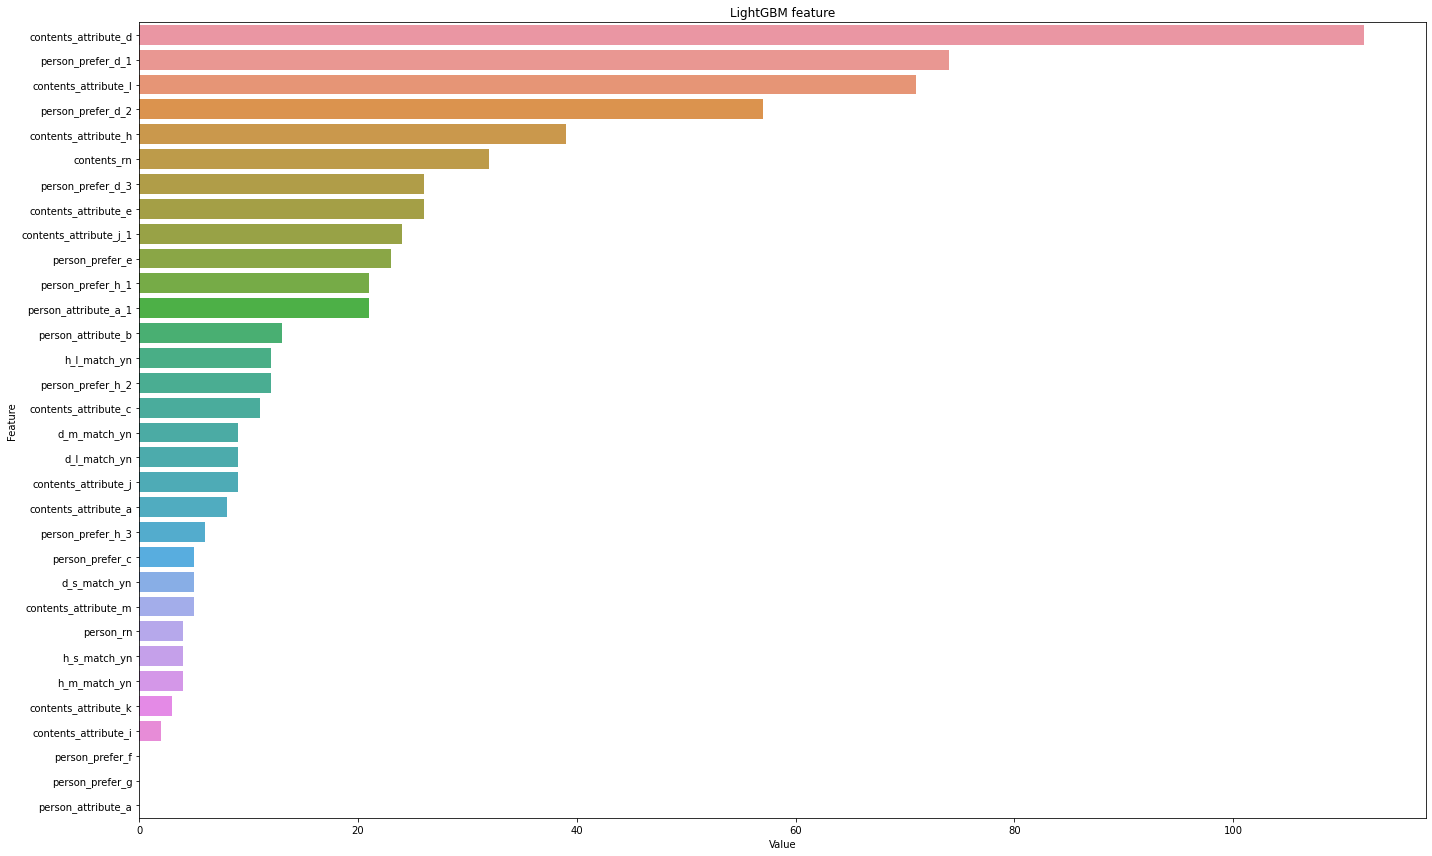

In [25]:
feature_imp= pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns =['Value', 'Feature'])

plt.figure(figsize=(20,12))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('LightGBM feature')
plt.tight_layout()
plt.show()

In [27]:
model = lgbm.LGBMClassifier(objective="binary", **study.best_params)
model.fit(X,y)

LGBMClassifier(bagging_fraction=0.7000000000000001, bagging_freq=1,
               feature_fraction=0.5, lambda_l1=0, lambda_l2=50,
               learning_rate=0.4, max_depth=19, min_data_in_leaf=250,
               min_gain_to_split=13.0, n_estimators=1020, num_leaves=70,
               objective='binary')

In [29]:
pred =model.predict(test.drop(['id', 'contents_open_dt'], axis=1))

In [30]:
pd.DataFrame(pred).value_counts()

1    25359
0    21045
dtype: int64

In [31]:
sub['target']=pred
sub.to_csv('submission.csv', index=False)